In [1]:
###IMPORT MODULES/LIBRARIES ###
import os
import warnings

import numpy as np
import math
import pickle

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import seaborn as sns
import pandas as pd

import scipy.stats as stats
from scipy.signal import correlate
from scipy.signal import find_peaks

import scipy.io as sio
from sklearn.metrics import roc_auc_score as auROC

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(suppress=True)
from tqdm import tqdm #progress bar



In [2]:
alphalevel = 0.05
bh_correction = 'no'

extractedsignalsonly = 'no'
mineventstoanalyze = 3

save_aligned_data = 'no'
save_auc_array = 'no'

delete_overlaps = 'yes'
separation_requirement = 1000

frameaveraging = 4
framerate = 30
timebetweenframes = 33.333333
averagedframerate = framerate/frameaveraging 

z_score_data = 'yes'

pre_window_size = int(10*averagedframerate)
window_size =  int((pre_window_size*2)+(1.6*averagedframerate))
post_window_size = window_size - pre_window_size

baselinefirstframe = 0
baselinelastframe = int(3*averagedframerate)
infusionframe = int(pre_window_size+(1.6*averagedframerate))
aucfirstframe = int(pre_window_size-(5*averagedframerate))
auclastframe = int(pre_window_size+(5*averagedframerate))

eventofinterest = 'activeleverall'

basedir = '../data'

In [3]:
def analyze_single_session(indir, window_size, pre_window_size):
    tempfiles = next(os.walk(indir))[2]
    npyfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' in f]
    matfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat']
    if len(npyfiles) > 1:
        npyfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' in f and not 'part2' in f and not 'part3' in f and not 'part4' in f]
        npyfile = npyfile [0]
        matfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and not 'results' in f and not 'part2' in f and not 'part3' in f and not 'part4' in f]
        matfile = matfile [0]
    else:
        npyfile = npyfiles[0]
        matfile = matfiles[0]

    signals = np.squeeze(np.load(os.path.join(indir, npyfile)))
    numrois = signals.shape[0] 

    behaviordata = sio.loadmat(os.path.join(indir, matfile))
    eventlog = np.squeeze(behaviordata['eventlog'])
    lastframe_timestamp_part1 = np.max(eventlog)

    if len(npyfiles) > 1:
        npyfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part2' in f]
        matfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part2' in f and not 'results' in f]
        npyfile2 = npyfiles2[0]
        matfile2 = matfiles2[0]
        signals2 = np.squeeze(np.load(os.path.join(indir, npyfile2))) 
        signals = np.hstack((signals, signals2))
        behaviordata2 = sio.loadmat(os.path.join(indir, matfile2))
        eventlog2 = np.squeeze(behaviordata2['eventlog'])
        eventlog2[:,1] = eventlog2[:,1]+lastframe_timestamp_part1
        eventlog = np.concatenate((eventlog,eventlog2))
        lastframe_timestamp_part2 = np.max(eventlog)
    if len(npyfiles) > 2:
        npyfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part3' in f]
        matfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part3' in f and not 'results' in f]
        npyfile3 = npyfiles3[0]
        matfile3 = matfiles3[0]
        signals3 = np.squeeze(np.load(os.path.join(indir, npyfile3))) 
        signals = np.hstack((signals, signals3))
        behaviordata3 = sio.loadmat(os.path.join(indir, matfile3))
        eventlog3 = np.squeeze(behaviordata3['eventlog'])
        eventlog3[:,1] = eventlog3[:,1]+lastframe_timestamp_part2
        eventlog = np.concatenate((eventlog,eventlog3))
        lastframe_timestamp_part3 = np.max(eventlog)
    if len(npyfiles) > 3:
        npyfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' and 'part4' in f]
        matfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part4' in f and not 'results' in f]
        npyfile4 = npyfiles4[0]
        matfile4 = matfiles4[0]
        signals4 = np.squeeze(np.load(os.path.join(indir, npyfile4))) 
        signals = np.hstack((signals, signals4))
        behaviordata4 = sio.loadmat(os.path.join(indir, matfile4))
        eventlog4 = np.squeeze(behaviordata4['eventlog'])
        eventlog4[:,1] = eventlog4[:,1]+lastframe_timestamp_part3
        eventlog = np.concatenate((eventlog,eventlog4))

    activelever = eventlog[eventlog[:,0]==22,1]
    activelevertimeout = eventlog[eventlog[:,0]==222,1]
    
    if isinstance(window_size, str): 
        return activelever, activelevertimeout

    if 'active' in eventofinterest:
        newarray = np.array([])
        temp = np.sort(np.hstack((activelever, activelevertimeout)))
        temp = np.delete(temp, np.argwhere(np.ediff1d(temp)<separation_requirement)+1)
        if eventofinterest == 'activelever':
            for i in range(len(temp)):
                if temp[i] in activelever:
                    newarray = np.append(newarray, temp[i])
            activelever = newarray
        if eventofinterest == 'activelevertimeout':
            for i in range(len(temp)):
                if temp[i] in activelevertimeout:
                    newarray = np.append(newarray, temp[i])
            activelevertimeout = newarray
        if eventofinterest == 'activeleverall':
            activeleverall = temp

    if eventofinterest == 'activelever':
        events = activelever
    elif eventofinterest == 'activelevertimeout':
        events = activelevertimeout
    elif eventofinterest == 'activeleverall':
        events = activeleverall

    if len(events) < 2:
        return np.nan*np.ones((2, window_size)), np.nan*np.ones((2, window_size)), np.nan*np.ones((2, window_size)), np.nan*np.ones((2, window_size))

    if animal == 'CTL1' or animal == 'ER-L1' or animal == 'ER-L2' or animal == 'IG-19' or animal == 'IG-28' or animal == 'PGa-T1' or animal == 'XYZ':
        frame_timestamps = np.array(assumed_frame_timestamps)
    else:
        frame_timestamps = fix_any_dropped_frames(eventlog[eventlog[:,0]==9,1])
    frame_timestamps = frame_timestamps[::frameaveraging]

    if signals.shape[1] > frame_timestamps.shape[0]:
        signals = signals[:,:frame_timestamps.shape[0]-1]

    signals /= np.nanmean(signals, axis=1)[:, None]
    
    if z_score_data == 'yes':
        for neuron in range(signals.shape[0]):
            mean = np.nanmean(signals[neuron])
            std = np.nanstd(signals[neuron])
            signals[neuron] = (signals[neuron] - mean)/std
    
    signalsT = signals.T

    if len(events) < mineventstoanalyze:
        return np.nan*np.ones((2, window_size)), np.nan*np.ones((2, window_size)), np.nan*np.ones((2, window_size)), np.nan*np.ones((2, window_size))

    def calculate_aligneddata_forevent(signalsT2, events2):
        framenumberfor_eventofinterest = np.squeeze(framenumberforevent(events2, frame_timestamps))

        numtrials = framenumberfor_eventofinterest.shape[0]
        alignedevents = np.nan*np.zeros([numtrials,window_size,numrois])

        for i in np.flip(range(numtrials)):
            eventindex = framenumberfor_eventofinterest[i]

            if np.isfinite(eventindex) and eventindex > pre_window_size and eventindex < np.shape(signalsT2)[0]-post_window_size:
                eventindex = int(eventindex)
                alignedevents[i, :, :] = signalsT2[eventindex-pre_window_size:eventindex+post_window_size, :]
            else:
                alignedevents = np.delete(alignedevents, i, axis = 0)

        return alignedevents

    alignedevents = calculate_aligneddata_forevent(signalsT, events) 

    for i in range(signals.shape[0]):
        if np.isnan(np.mean(signals[i,:])):
            print(animal, fov, 'IMAGE J ROI.ZIP CELL NUMBER %s HAS NaNs AND SHOULD BE CHANGED'%(i+1))
    
    alignedevents = np.swapaxes(alignedevents, 0,2)
        
    popevents = np.nanmean(alignedevents, axis=2)

    if save_aligned_data == 'yes':
        np.save(os.path.join(indir, 'popevents_%s_%s.npy'%(eventofinterest, separation_requirement)), popevents)
        np.save(os.path.join(indir, 'alignedevents_%s_%s.npy'%(eventofinterest, separation_requirement)), alignedevents)
    return popevents, alignedevents, events, events


def framenumberforevent(event, frame_timestamps):
    framenumber = np.nan*np.zeros(event.shape)
    for ie, e in enumerate(event):
        if np.isnan(e):
            framenumber[ie] = np.nan
        else:
            temp = np.nonzero(frame_timestamps<=e)[0]
            if temp.shape[0]>0:
                framenumber[ie] = np.nonzero(frame_timestamps<=e)[0][-1]
            else:
                framenumber[ie] = 0
    return framenumber


In [4]:
def fix_any_dropped_frames(frame_timestamps):
    first_frame = np.array([0])
    last_frame = np.array([int(np.max(frame_timestamps)+(500*timebetweenframes))])
    frame_index_temp = np.concatenate((first_frame,frame_timestamps, last_frame))
    frames_missed = []
    for i in range(len(frame_index_temp)-1):
            numframes_missed = int(np.round((frame_index_temp[i+1]-frame_index_temp[i])\
                /timebetweenframes)-1)
            if numframes_missed > 0:
                for j in range(numframes_missed):
                    frame_missed = np.array([frame_index_temp[i] + (int(timebetweenframes * (j+1)))])
                    frames_missed = np.concatenate((frames_missed, frame_missed))
    corrected_frame_index = np.array(sorted(np.concatenate((frame_index_temp, frames_missed))))
    return corrected_frame_index

def fix_assumed_frames(frames):
    dropped_frames = []
    diff_frames = np.diff(frames)
    inter_frame_interval = 33
    frame_drop_idx = np.where(diff_frames>1.5*inter_frame_interval)[0]
    for idx in frame_drop_idx:
        numframesdropped = int(np.round((frames[idx+1]-frames[idx])/(inter_frame_interval+0.0))-1)
        temp = [frames[idx]+a*inter_frame_interval for a in range(1,numframesdropped+1)]
        dropped_frames.extend(temp)
    corrected_frames = np.sort(np.concatenate((frames, np.array(dropped_frames))))
    return corrected_frames

try:
    behaviordata_noframes = sio.loadmat('../data/empty.mat')
    eventlog_noframes = np.squeeze(behaviordata_noframes['eventlog'])

    max_of_eventlog_noframes = max(eventlog_noframes[:,1])
    length_of_eventlog_noframes = len(eventlog_noframes[:,1])
    x = np.vstack((eventlog_noframes, eventlog_noframes, eventlog_noframes))
    x[length_of_eventlog_noframes:,1]= x[length_of_eventlog_noframes:,1]+max_of_eventlog_noframes
    x[length_of_eventlog_noframes*2:,1]= x[length_of_eventlog_noframes*2:,1]+(2*max_of_eventlog_noframes)

    eventlog_noframes = x

    assumed_frames = fix_any_dropped_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1])
    assumed_frame_timestamps = fix_assumed_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1])
except FileNotFoundError:
    print("empty.mat not found. Generating uniform timestamps based on signal length.")


In [5]:
###OTHER FUNCTIONS
def calculate_auROC(x,y,offset_to_zero=True):
    U, p = stats.mannwhitneyu(x,y)
    labels = np.concatenate((np.ones(x.shape), np.zeros(y.shape)))
    data = np.concatenate((x,y))
    A = auROC(labels, data)
    if offset_to_zero:
        return (2*(A-0.5), p)
    else:
        return (A, p)
    
def Benjamini_Hochberg_correction(vector_of_pvals, alpha = 0.05):
    sortedpvals = np.sort(vector_of_pvals)
    orderofpvals = np.argsort(vector_of_pvals)
    m = sortedpvals[np.isfinite(sortedpvals)].shape[0] #Total number of hypotheses
    for i in range(m):
        if sortedpvals[i] > (i+1)*alpha/m:
            k = i
            break
        elif i == m-1:
            k = m-1
        
    correctedpvals = np.copy(vector_of_pvals)
    correctedpvals[orderofpvals[k:]] = 1
    correctedpvals[np.isnan(vector_of_pvals)] = np.nan
    return correctedpvals

def iterate_dirs(basedir, days):
    for day in sorted(days):
        animals = next(os.walk(os.path.join(basedir, day)))[1]
        for animal in sorted(animals):
            FOVs = next(os.walk(os.path.join(basedir, day, animal)))[1]
            for fov in sorted(FOVs):
                yield basedir, day, animal, fov


In [6]:
tempdays = next(os.walk(os.path.join(basedir)))[1]
days = []
for t in tempdays:
    if t!= 'Cascade' and t!= 'CellTracking' and t!= 'Codes' and t != '.ipynb_checkpoints' and t != 'Other' and t!= 'Results':
        days = np.append(days, t)
numdays = len(days)

popevents_day = {}
popevents_fov = {}

for basedir, day, animal, fov in iterate_dirs(basedir, sorted(days)):
    if day not in popevents_fov:
        popevents_day[day] = np.nan*np.ones((1, window_size))
        popevents_fov[day] = {}
        print(day)
    tempfiles = next(os.walk(os.path.join(basedir, day, animal, fov)))[2]
for day in sorted(days):
    popevents_day[day] = popevents_day[day][1:,:]
    baseline = np.mean(popevents_day[day][:, baselinefirstframe:baselinelastframe], axis=1)
    popevents_day[day] = popevents_day[day] - baseline[:, None]
popevents_all = np.vstack([popevents_day[day] for day in sorted(days)])

0 EarlyAcq
1 MidAcq
2 LateAcq
3 EarlyExt
4 LastExt
5 CueRein
6 DrugRein
7 TMTRein


In [7]:
aucpvals_day = {}
aucpvals_fov = {}

for basedir, day, animal, fov in iterate_dirs(basedir, sorted(days)):
    if day not in aucpvals_fov:
        aucpvals_day[day] = np.nan*np.ones((1, 2))
        aucpvals_fov[day] = {}
    tempfiles = next(os.walk(os.path.join(basedir, day, animal, fov)))[2]
    if 'alignedevents_%s_%s.npy'%(eventofinterest, separation_requirement) in tempfiles: 
        if animal not in aucpvals_fov[day]:
            aucpvals_fov[day][animal] = {}
        aucpvals_fov[day][animal][fov] = np.load(os.path.join(basedir, day, animal, fov, 'aucpvals_%s_%s.npy'%(eventofinterest, separation_requirement)))
        aucpvals_day[day] = np.vstack((aucpvals_day[day], aucpvals_fov[day][animal][fov]))

for day in sorted(days):
    aucpvals_day[day] = aucpvals_day[day][1:, :]  # Remove the first row of NaNs

aucpvals_all = np.vstack([aucpvals_day[day] for day in sorted(days)])

data z-scored


C:\Users\boqui\AppData\Local\Temp\ipykernel_55720\3454249289.py:33: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(temp[sortresponse], cmap=plt.get_cmap('PRGn_r'), vmin=cmin, vmax=cmax, aspect='auto')
C:\Users\boqui\OneDrive\Desktop\nsync\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\boqui\OneDrive\Desktop\nsync\.venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


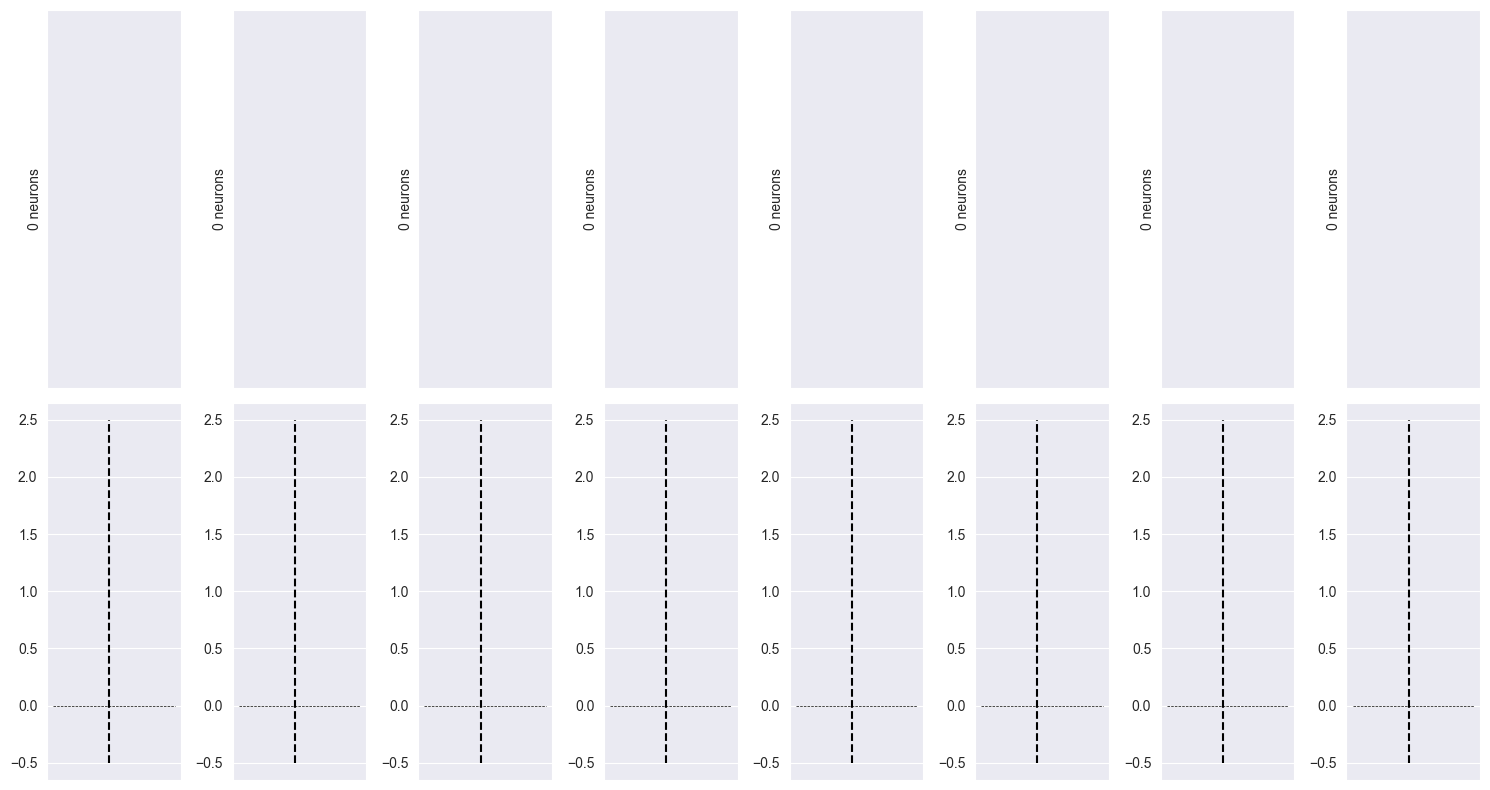

In [8]:
if numdays > 1:
    fig, axs = plt.subplots(2, numdays, figsize=(15, 8))
else: 
    fig, axs = plt.subplots(2, 2, figsize=(5, 8))
    
sns.set_style('white')

cmax = 4
cmin = -cmax
ymax = 4
ymin = -ymax

for d, day in enumerate(sorted(days)):
    temp = np.array(popevents_day[day])
    temp_std = []
    for neuron in range(temp.shape[0]):
        neuron_std = np.nanstd(temp[neuron, baselinefirstframe:baselinelastframe])
        temp_std = np.hstack((temp_std, neuron_std))
        temp[neuron, :] = temp[neuron, :]/neuron_std
    if d == 0:
        print('data z-scored')
            
    tempresponse = np.nanmean(temp, axis=1)
    sortresponse = np.argsort(tempresponse)[::-1]
    numneurons_temp = len(sortresponse)

    ax = axs[0, d]

    im = ax.imshow(temp[sortresponse], cmap=plt.get_cmap('PRGn_r'), vmin=cmin, vmax=cmax, aspect='auto')
    
    ax.grid(False)
    ax.set_ylabel('%s neurons'%numneurons_temp)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.plot([pre_window_size, pre_window_size], 
            [0, numneurons_temp], '--k', linewidth=1.5)
    ax.plot([infusionframe, infusionframe],
            [0, numneurons_temp], '--k', linewidth=1.5) 

    ax = axs[1, d]
    ax.set_xticks([])
    ax.plot(np.mean(temp, axis = 0))
    ax.plot([pre_window_size, pre_window_size],
             [-0.5,2.5],'--k', linewidth=1.5)
    ax.plot([0, window_size],
            [0,0], '--k', linewidth=0.5)

fig.tight_layout()
plt.show()

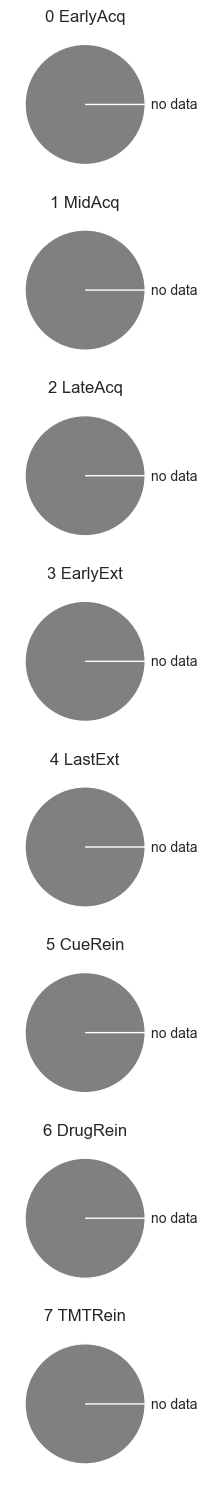

In [10]:
fig, axs = plt.subplots(numdays, figsize=(4, 15), sharex=True, sharey=False)

sns.set_style('white')
colors = ['purple', 'gray', 'green']

numneurons_day = {}

for d, day in enumerate(sorted(days)):
    numneurons_day[day] = np.shape(aucpvals_day[day] )[0]
    if numneurons_day[day] > 0:
        activatedneurons = np.count_nonzero((aucpvals_day[day] [:,1]<=alphalevel) & (aucpvals_day[day] [:,0]>=0))/numneurons_day[day]
        inhibitedneurons = np.count_nonzero((aucpvals_day[day] [:,1]<=alphalevel) & (aucpvals_day[day] [:,0]<0))/numneurons_day[day]
        nonresponders = np.count_nonzero(aucpvals_day[day] [:,1]>alphalevel)/numneurons_day[day] 
    
        counts = np.array([activatedneurons, nonresponders, inhibitedneurons])
        labels = (int(activatedneurons*1000)/10, '', int(inhibitedneurons*1000)/10) #goofy calculations to plot % in each group
    else:
        counts = np.array([0, 1, 0])
        labels = ('no data','','')
        
    ax = axs[d]
    ax.pie(counts, colors=colors, labels=labels)
    ax.set_title(day)
    fig.tight_layout()

numneurons_all = sum(numneurons_day.values())

plt.show()
plt.close()

In [11]:
cell_mapping = {}
cellcounterall = 0

for basedir, day, animal, fov in iterate_dirs(basedir, days):
    tempfiles = next(os.walk(os.path.join(basedir, day, animal, fov)))[2]
    if 'popevents_%s_%s.npy' % (eventofinterest, separation_requirement) in tempfiles: 
        temp1 = np.load(os.path.join(basedir, day, animal, fov, 'popevents_%s_%s.npy' % (eventofinterest, separation_requirement)))  
        numneurons_temp = temp1.shape[0]
        for neuron in range(numneurons_temp):
            cell_mapping[(day, animal, fov, neuron)] = cellcounterall + neuron
        cellcounterall += numneurons_temp

keys_day = {}
idxs_day = {}

for d, day in enumerate(sorted(days)):
    keys_day[day] = [key for key in cell_mapping.keys() if key[0] == day]
    idxs_day[day] = [value for key, value in cell_mapping.items() if key[0] == day]

unique_values = len(set(cell_mapping.values()))
print(f"Number of neuron values in cell_mapping: {unique_values}")

Number of neuron values in cell_mapping: 0


# CLUSTERING: ONLY USE THIS SECTION IF YOU WANT TO REDO CLUSTERING!

In [ ]:
### This function enables you to apply defined operators (based on auROC and pvalue significance) to clustering analysis.
def create_condition(aucpvals_day, auROC_op, pval_op):
    if auROC_op == '>' and pval_op == 'significant':
        return np.logical_and(aucpvals_day[:,1] <= alphalevel, aucpvals_day[:,0] >= 0)
    elif auROC_op == '<' and pval_op == 'significant':
        return np.logical_and(aucpvals_day[:,1] <= alphalevel, aucpvals_day[:,0] < 0)
    elif auROC_op == 'all' and pval_op == 'significant':
        return aucpvals_day[:,1] <= alphalevel
    elif auROC_op == '>' and pval_op == 'notsignificant':
        return np.logical_and(aucpvals_day[:,1] > alphalevel, aucpvals_day[:,0] >= 0)
    elif auROC_op == '<' and pval_op == 'notsignificant':
        return np.logical_and(aucpvals_day[:,1] > alphalevel, aucpvals_day[:,0] < 0)
    elif auROC_op == 'all' and pval_op == 'notsignificant':
        return aucpvals_day[:,1] > alphalevel
    elif auROC_op == '>' and pval_op == 'all':
        return aucpvals_day[:,0] >= 0
    elif auROC_op == '<' and pval_op == 'all':
        return aucpvals_day[:,0] < 0
    elif auROC_op == 'all' and pval_op == 'all':
        return np.ones_like(aucpvals_day[:,0], dtype=bool)

### This array is set to all zeros, and then each clustering analysis will index cluster labels into the array. 
### Protected by 'globals' function to prevent overwriting when doing multiple clustering analyses (you don't have to run this cell more than once)
### If you need to overwrite the array, just add random letters to 'clusterids_all' and rerun cell. 
if 'clusterids_all' not in globals():
    clusterids_all = np.zeros((numneurons_all))


In [ ]:
### WHAT DATA DO YOU WANT TO USE FOR CLUSTERING, BASED ON AUROC VALUE? + RESPONDERS, - RESPONDERS, OR ALL? ###
### WHAT DATA DO YOU WANT TO USE FOR CLUSTERING, BASED ON AUROC P-VALUE? SIGNIFICANT, NOT SIGNIFICANT, OR ALL? ###
auROC_operator = '>'  # 'all', ">", or "<"
pval_operator = 'significant' #'significant', 'notsignificant', or 'all'


In [ ]:
### Select data for clustering based on operators above ###
condition = create_condition(aucpvals_all, auROC_operator, pval_operator)
popevents_forclustering = popevents_all[np.where(condition)]
numneurons_forclustering = np.shape(popevents_forclustering)[0]
print(np.shape(popevents_forclustering), 'popevents_forclustering array size')


In [ ]:
### NORMALIZE RESPONSE AMPLITUDES ACROSS NEURONS TO 1?
# Calculate the maximum absolute value for each neuron
max_abs_values = np.max(np.abs(popevents_forclustering), axis=1, keepdims=True)

# Normalize each neuron's response
popevents_forclustering = popevents_forclustering / max_abs_values
print(popevents_forclustering.shape, 'popevents_forclustering array normalized')
    

In [ ]:
## CUT THE LENGTH OF IMAGING WINDOW (WINDOW SIZE) FOR CLUSTERING? ###
preseconds = 10 ###seconds before event to cluster
postseconds = 11.6 ###seconds after event to cluster
popevents_forclustering = popevents_forclustering[:, pre_window_size - int(averagedframerate*preseconds): pre_window_size + int(averagedframerate *postseconds)]
print (popevents_forclustering.shape, 'popevents_forclustering array size after cutting frames')


In [ ]:
### AVERAGE FRAMES FOR CLUSTERING? ###
cluster_frameaveraging = 1 ### MUST BE USABLE TO DIVIDE BY FRAME LENGTH DENOTED ABOVE FOR CLUSTERING. SET TO 1 AND RUN IF YOU DON'T WANT TO AVERAGE
temp = popevents_forclustering.reshape(popevents_forclustering.shape[0], popevents_forclustering.shape[1] // cluster_frameaveraging, cluster_frameaveraging) 
popevents_forclustering = temp.mean(axis = 2)
print(popevents_forclustering.shape, 'popevents_forclustering array size after frame averaging')

In [ ]:
### PLOT ARRAY FOR CLUSTERING
cmax = 0.5 # Maximum colormap value. 
trial_types = ['Active']

fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')

for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    tempresponse = np.nanmean(popevents_forclustering, axis=1)
    sortresponse = np.argsort(tempresponse)[::-1]
    sns.heatmap(popevents_forclustering[sortresponse],
                ax=ax,
                cmap=plt.get_cmap('PRGn_r'),
                vmin=-cmax,
                vmax=cmax)

    ax.axvline(preseconds*averagedframerate/cluster_frameaveraging, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from Press (frames)')
    
    ax = axs[1,t]
    sns.lineplot(data=np.mean(popevents_forclustering[:, t*window_size:(t+1)*window_size], axis=0), dashes=False,
               ax=ax)
    ax.axvline(preseconds*averagedframerate/cluster_frameaveraging, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from Press (frames)')
    ax.set_xticks([])
    
axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. fluor.')


fig.subplots_adjust(right=0.82)

fig.savefig(os.path.join(basedir, 'Results', '%s_%s_HeatmapForClustering, %s_%s.PNG'%(eventofinterest, separation_requirement, auROC_operator, pval_operator)), format='PNG')
fig.savefig(os.path.join(basedir, 'Results', '%s_%s_HeatmapForClustering, %s_%s.PDF'%(eventofinterest, separation_requirement, auROC_operator, pval_operator)), format='PDF')


In [ ]:
### Perform PCA on the data plotted above to reduce demensionality of the dataset before clustering
pca = PCA(n_components=popevents_forclustering.shape[1], whiten=True)
pca.fit(popevents_forclustering) 

with open(os.path.join(basedir, 'Results','pcaresults_%s_%s.pickle'%(auROC_operator, pval_operator)), 'wb') as f:
    pickle.dump(pca, f)
    
transformed_data = pca.transform(popevents_forclustering)

np.save(os.path.join(basedir, 'Results', 'transformed_data._%s_%s.npy'%(auROC_operator, pval_operator)), transformed_data)

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
print('Variance Explained by PC\n', x)

### Define number of PCs here using one of the two methods below. Comment out 1 method ###
num_retained_pcs = np.count_nonzero(x>5) ### based on min variance explained. usually ~5 works well

# xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size)) # or defined as the number at which the scree plot bends.
# num_retained_pcs = np.argmin(xprime) # or defined as the number at which the scree plot bends.

print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
ax.set_xlim([0,50])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(preseconds*averagedframerate/cluster_frameaveraging, linestyle='--', color='k', linewidth=0.5)    
    ax.axhline(0, linestyle='--', color='k', linewidth=0.5)

    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.text(0.5, 0.05, 'Time from Press (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)
fig.tight_layout()

fig.savefig(os.path.join(basedir, 'Results', '%s_%s_PCs_%s_%s.PDF'%(eventofinterest, separation_requirement, auROC_operator, pval_operator)), format='PDF')
fig.savefig(os.path.join(basedir, 'Results', '%s_%s_PCs_%s_%s.PNG'%(eventofinterest, separation_requirement, auROC_operator, pval_operator)), format='PNG')

    

In [ ]:
### Perform clustering based on the maximum number of PCs expected
max_n_clusters = num_retained_pcs + 1 # Maximum number of clusters expected. Almost always ends up being the name number of PCs + 1

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
### When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, as the responses of the clusters will be quite similar. 

possible_n_nearest_neighbors = np.arange(int(numneurons_forclustering/5), int((numneurons_forclustering/10)*9), int(numneurons_forclustering/4))
      
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters, nn, silhouette_scores[n_clustersidx, nnidx]))
print ('Done with model fitting')

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'

with open(os.path.join(basedir, 'Results', 'silhouette_scores_%s_%s.pickle'%(auROC_operator, pval_operator)), 'wb') as f:
        pickle.dump(temp, f)   
 
    

In [ ]:
### Use clustering results to plot silhouette scores. The higher the sillhouette the better the response "fits" with the cluster
with open(os.path.join(basedir, 'Results', 'silhouette_scores_%s_%s.pickle'%(auROC_operator, pval_operator)), 'rb') as f:
        silhouette_scores = pickle.load(f)
        
# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

model.fit(transformed_data[:,:num_retained_pcs])

clusterids_temp = model.labels_
uniqueclusterids_temp = list(set(clusterids_temp))
numclusters_temp = len(uniqueclusterids_temp)

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(numclusters_temp, temp))

# Save this optimal clustering model.
with open(os.path.join(basedir, 'Results', 'clusteringmodel_%s_%s.pickle'%(auROC_operator, pval_operator)), 'wb') as f:
    pickle.dump(model, f)


In [ ]:
def make_silhouette_plot(X, cluster_labels):
        
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    fig.savefig(os.path.join(basedir, 'Results', 'Silhouettes_%s_%s.PDF'%(auROC_operator, pval_operator)), format='PDF')
    fig.savefig(os.path.join(basedir, 'Results', 'Silhouettes_%s_%s.PNG'%(auROC_operator, pval_operator)), format='PNG')
      
make_silhouette_plot(transformed_data[:,:num_retained_pcs], clusterids_temp)    


In [ ]:
### this section inserts cluster ids into clusterids_all array, and then plots current clusters ### 
condition = create_condition(aucpvals_all, auROC_operator, pval_operator)

clusterids_all[np.where(condition)] = clusterids_temp + 1 + max(clusterids_all[np.where(~condition)])
numclusters = int(max(clusterids_all))+1

for c in range(numclusters):
    temp = popevents_all[np.where(clusterids_all == c)]
    cluster_ci = 1.96 * np.std(temp, axis=0) / np.sqrt(len(temp)) ### cluster confidence interval
    cluster_mean = np.mean(temp, axis = 0)
    plt.plot(cluster_mean,  label=f'Cluster {c}')
    plt.fill_between(range(len(cluster_mean)), cluster_mean - cluster_ci, cluster_mean + cluster_ci, alpha=0.3)

# Add legend
plt.legend()

# Add vertical dashed line at pre_window_size
plt.axvline(x=pre_window_size, color='k', linestyle='--')

# Add horizontal dashed line at y=0
plt.axhline(y=0, color='k', linestyle='--')

# Set x-axis and y-axis labels 
plt.ylabel(r'$\Delta F/F$', fontsize=12)  # Use LaTeX for delta symbol
plt.xlabel("Seconds")

# Set x-axis ticks to represent seconds from -10 to +11.6
xticks = [0, pre_window_size, window_size]
xlabels = [int(-pre_window_size/averagedframerate), 0, (window_size-pre_window_size)/averagedframerate]
plt.xticks(xticks, labels=xlabels)

plt.show()


# AFTER YOU RUN ALL DESIRED CLUSTERING ANALYSES, USE THE BELOW LINES TO REORDER CLUSTERIDS BASED ON THEIR PEAK RESPONSES, AND THEN SAVE THE CLUSTERING IDS TO YOUR DIRECTORY

In [ ]:
### REORDER CLUSTER IDS BASED ON PEAK RESPONSES, AND THEN SAVE THE DATA
# Find the peak response for each cluster, excluding cluster 0 which represents neurons that were not clustered (e.g., not significant neurons)
peak_responses = np.nan*np.ones((numclusters))
for c in range(1, numclusters):
    cluster_mean = np.mean(popevents_all[np.where(clusterids_all == c)], axis=0)
    min_peak, max_peak = min(cluster_mean), max(cluster_mean)
    if max_peak > np.abs(min_peak):
        peak_responses[c] = max_peak
    else:
        peak_responses[c] = min_peak

# Determine the new cluster IDs based on the peak of the cluster mean
sorted_clusters = np.argsort(peak_responses)[::-1]
cluster_mapping = {old_cluster: new_cluster for new_cluster, old_cluster in enumerate(sorted_clusters)}

# Create clusterids_all_renumbered
clusterids_all_renumbered = np.array([cluster_mapping[old_cluster] for old_cluster in clusterids_all])

### save clusterids_all_renumbered
# np.save(os.path.join(basedir, 'Results', 'clusterids_all.npy'), clusterids_all_renumbered)


In [ ]:
#replot the data to ensure renumbering worked correctly

for c in range(numclusters):
    temp = popevents_all[np.where(clusterids_all_renumbered == c)]
    cluster_ci = 1.96 * np.std(temp, axis=0) / np.sqrt(len(temp)) ### cluster confidence interval
    cluster_mean = np.mean(temp, axis = 0)
    label = f'Cluster {c}' if c > 0 else 'Unclustered'
    plt.plot(cluster_mean,  label=label)
    plt.fill_between(range(len(cluster_mean)), cluster_mean - cluster_ci, cluster_mean + cluster_ci, alpha=0.3)

# Add legend
plt.legend()

# Add vertical dashed line at pre_window_size
plt.axvline(x=pre_window_size, color='k', linestyle='--')

# Add horizontal dashed line at y=0
plt.axhline(y=0, color='k', linestyle='--')

# Set x-axis and y-axis labels 
plt.ylabel(r'$\Delta F/F$', fontsize=12)  # Use LaTeX for delta symbol
plt.xlabel("Seconds")

# Set x-axis ticks to represent seconds from -10 to +11.6
xticks = [0, pre_window_size, window_size]
xlabels = [int(-pre_window_size/averagedframerate), 0, (window_size-pre_window_size)/averagedframerate]
plt.xticks(xticks, labels=xlabels)

# plt.savefig(os.path.join(basedir, 'Results', 'ClusteringResults.PDF'), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'ClusteringResults.PNG'), format='PNG')

plt.show()


# TO PLOT PREVIOUSLY CLUSTERED DATA, CONTINUE HERE (DON'T RUN CLUSTERING ABOVE)

In [ ]:
### LOAD REQUIRED DATA
popevents_all = np.load(os.path.join(basedir, 'Results', 'popevents_%s_%s.npy'%(eventofinterest, separation_requirement))) ### 2D array (neurons x window_size) of all neuronal responses across all days
aucpvals_all = np.load(os.path.join(basedir, 'Results', 'aucpvals_%s_%s.npy'%(eventofinterest, separation_requirement))) ### 2D array of auROC and associated pval (neurons x 2), neurons in same order as popevents
clusterids_all = np.load(os.path.join(basedir, 'Results', 'clusterids_all.npy')) ### 1D array of cluster ids, neurons in same order as popevents
numclusters = int(max(clusterids_all))+1

print('shape of popactive %s, aucpvals %s, and clusterids %s'%(popevents_all.shape, aucpvals_all.shape, clusterids_all.shape))

# Find peak response of each cluster for subsequent graphing
peak_responses = np.nan*np.ones((numclusters))
for c in range(1, numclusters):
    cluster_mean = np.mean(popevents_all[np.where(clusterids_all == c)], axis=0)
    min_peak, max_peak = min(cluster_mean), max(cluster_mean)
    if max_peak > np.abs(min_peak):
        peak_responses[c] = max_peak
    else:
        peak_responses[c] = min_peak

# Define response direction of each cluster for future separation
cluster_response_patterns = {
    0: ([0], 'unclustered'),
    1: (np.where(peak_responses > 0)[0], 'excited'),
    2: (np.where(peak_responses < 0)[0], 'inhibited')}

# Define colors for each cluster
cluster_colors = []
for c in range(1, numclusters+1):
    if c <= 4:
        color = mcolors.to_hex(plt.cm.Purples(1-(c-1)/6))
    else:
        color = mcolors.to_hex(plt.cm.Greens(0.5+(c-5)/6))
    cluster_colors.append(color)
cluster_colors.insert(0, 'black')

# Create a dictionary for each day that includes cluster ids
clusterids_day = {}
for d, day in enumerate(sorted(days)):
    clusterids_day[day] = []
    for neuron_key in keys_day[day]:
        cell_number = cell_mapping[(neuron_key)]
        clusterids_day[day] = np.append(clusterids_day[day], clusterids_all[cell_number])

# Create a dictionary for each fov that includes cluster ids
clusterids_fov = {}
for basedir, day, animal, fov in iterate_dirs(basedir, sorted(days)):
    tempfiles = next(os.walk(os.path.join(basedir, day, animal, fov)))[2]
    if 'popevents_%s_%s.npy'%(eventofinterest, separation_requirement) in tempfiles: 
        if day not in clusterids_fov:
            clusterids_fov[day] = {}
        if animal not in clusterids_fov[day]:
            clusterids_fov[day][animal] = {}
        if fov not in clusterids_fov[day][animal]:
            temp_numneurons = np.shape(popevents_fov[day][animal][fov])[0]
            clusterids_fov[day][animal][fov] = []
            for neuron in range(temp_numneurons):
                clusterids_fov[day][animal][fov] = np.append(clusterids_fov[day][animal][fov],\
                                                             clusterids_all[cell_mapping[(day, animal, fov, neuron)]])
        


In [ ]:
### CREATE LINEPLOT FOR EACH CLUSTER
# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust the figsize as needed

# Variables used for data storage and plotting
heatmap_all = np.nan * np.ones((1, window_size))
heatmap_gap = 1  # gap inserted between clusters in heatmap as "empty neurons"

# Replot the data to ensure data was aligned, saved, and loaded correctly
for c in range(numclusters):
    temp = popevents_all[np.where(clusterids_all == c)]
    if plot_zscored_popevents == 'yes':
        temp_std = []
        for neuron in range(temp.shape[0]):
            neuron_std = np.nanstd(temp[neuron, baselinefirstframe:baselinelastframe])
            temp_std = np.hstack((temp_std, neuron_std))
            temp[neuron, :] = temp[neuron, :]/neuron_std
        if c == 0:
            print('data z-scored')
    cluster_ci = 1.96 * np.std(temp, axis=0) / np.sqrt(len(temp))  ### cluster confidence interval
    cluster_mean = np.mean(temp, axis=0)
    label = f'Cluster {c}' if c > 0 else 'Unclustered'
    ax.plot(cluster_mean, label=label, color=cluster_colors[c])
    ax.fill_between(range(len(cluster_mean)), cluster_mean - cluster_ci, cluster_mean + cluster_ci, alpha=0.3,
                    color=cluster_colors[c])

    # Fill heatmap array for next cell
    if c != 0:
        tempresponse = np.amax(temp, axis=1)
        if peak_responses[c] > 0:
            sortresponse = np.argsort(tempresponse)[::-1]
        else:
            sortresponse = np.argsort(tempresponse)
        heatmap_all = np.vstack((heatmap_all, temp[sortresponse]))
        heatmap_all = np.vstack((heatmap_all, np.nan * np.ones((heatmap_gap, window_size))))
heatmap_all = heatmap_all[1:-heatmap_gap, :]  ### delete extra rows from heatmap array

# Add legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add vertical dashed line at pre_window_size
ax.axvline(x=pre_window_size, color='k', linestyle='--')

# Add horizontal dashed line at y=0
ax.axhline(y=0, color='k', linestyle='--')

# Set x-axis and y-axis labels
ax.set_ylabel(r'$\Delta F/F$', fontsize=10)  # Use LaTeX for delta symbol
ax.set_xlabel("Seconds")

# Set x-axis ticks to represent seconds from -10 to +11.6
xticks = [0, pre_window_size, window_size]
xlabels = [int(-pre_window_size / averagedframerate), 0, (window_size - pre_window_size) / averagedframerate]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# if plot_zscored_popevents == 'no':
    # plt.savefig(os.path.join(basedir, 'Results', 'Clustering_LinePlot.PDF'), format='PDF', bbox_inches='tight')
    # plt.savefig(os.path.join(basedir, 'Results', 'Clustering_LinePlot.PNG'), format='PNG', bbox_inches='tight')
if plot_zscored_popevents == 'yes':
    plt.savefig(os.path.join(basedir, 'Results', 'Clustering_LinePlot_zscored.PDF'), format='PDF', bbox_inches='tight')
    plt.savefig(os.path.join(basedir, 'Results', 'Clustering_LinePlot_zscored.PNG'), format='PNG', bbox_inches='tight')
    
plt.show()

In [ ]:
### CREATE HEATPLOT FOR EACH CLUSTER
# Create a figure with the desired size

fig, ax = plt.subplots(figsize=(4, 8))

# Plot the heatmap
im = ax.imshow(heatmap_all, cmap=plt.get_cmap('PRGn_r'), vmin=-cmax, vmax=cmax, aspect='auto')

# Add colorbar
fig.colorbar(im, ax=ax, shrink=0.5)

# Add cluster labels to the left of the heatmap
spacetilnow = 0
for c in range(1, numclusters):
    numneuronstemp = popevents_all[np.where(clusterids_all == c)].shape[0]
    
    # Update the position for the next cluster
    spacetilnow += numneuronstemp + heatmap_gap
    
    # Add cluster label
    ax.text(-50, spacetilnow - (0.5 * numneuronstemp), f'Cluster = {c}', fontsize=10, ha='center', va='center')

ax.axvline(x=pre_window_size, color='k', linestyle='--', linewidth = 1)

ax.set_xlabel("Seconds")
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.set_yticks([])
ax.set_title('All Days', fontsize=10)

fig.tight_layout()

# plt.savefig(os.path.join(basedir, 'Results', 'Clustering_HeatMap.PDF'), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Clustering_HeatMap.PNG'), format='PNG')

plt.show()


In [ ]:
# Create a figure and axis with the desired size
fig, axs = plt.subplots(1, len(days), figsize=(10, 2), sharex=True, sharey=False)
scalebar_size = 0.3

# Replot the data to ensure data was aligned, saved, and loaded correctly
for d, day in enumerate(sorted(days)):
    ax = axs[d]
    for c in range(numclusters):
        temp = popevents_day[day][np.where(clusterids_day[day] == c)]
        cluster_ci = 1.96 * np.std(temp, axis=0) / np.sqrt(len(temp))  ### cluster confidence interval
        cluster_mean = np.mean(temp, axis=0)
        label = f'Cluster {c}' if c > 0 else 'Unclustered'
        ax.plot(cluster_mean, label=label, color=cluster_colors[c], linewidth = 1.5)
#         ax.fill_between(range(len(cluster_mean)), cluster_mean - cluster_ci, cluster_mean + cluster_ci, alpha=0.3,
#                         color=cluster_colors[c])

    # Add vertical dashed line at pre_window_size
    ax.axvline(x=pre_window_size, color='k', linestyle='--')

    # Add horizontal dashed line at y=0
    ax.axhline(y=0, color='k', linestyle='--')

    # Set y-axis labels only for the far-left graph
    if d == 0:
        ax.set_ylabel(r'%s $\Delta F/F$'%scalebar_size, fontsize=10)  # Use LaTeX for delta symbol

    # Set x-axis and y-axis labels
    ax.set_xlabel(f"{window_size / averagedframerate:.1f} Seconds")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.plot([-6, -6], [0.3, 0.3+scalebar_size], 'k-', lw = 1) ### y-scale bar with a value that is the difference between the second two digits as df/f

    # Remove the border surrounding each graph
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

fig.tight_layout()

# plt.savefig(os.path.join(basedir, 'Results', 'Clustering_LinePlot_Days.PDF'), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Clustering_LinePlot_Days.PNG'), format='PNG')

plt.show()


In [ ]:
### CREATE HEATPLOT FOR EACH CLUSTER, ON EACH DAY
# Create a figure with the desired size
fig, axs = plt.subplots(1, len(days), figsize=(12, 5), sharex=True)

# Loop through each day
for d, day in enumerate(sorted(days)):
    heatmap_day = np.nan*np.ones((1, window_size))
    spacetilnow = 0
    
    for c in range(1, numclusters):
        temp = popevents_day[day][np.where(clusterids_day[day] == c)]
        tempresponse = np.amax(temp, axis=1)
        if peak_responses[c] > 0:
            sortresponse = np.argsort(tempresponse)[::-1]
        else:
            sortresponse = np.argsort(tempresponse)
        heatmap_day = np.vstack((heatmap_day, temp[sortresponse]))
        heatmap_day = np.vstack((heatmap_day, np.nan * np.ones((heatmap_gap, window_size))))
        numneuronstemp = popevents_day[day][np.where(clusterids_day[day] == c)].shape[0]
        spacetilnow += numneuronstemp + heatmap_gap
    
    heatmap_day = heatmap_day[1:-heatmap_gap, :]  # delete extra rows from heatmap array
    ax = axs[d]
    
    # Plot the heatmap
    im = ax.imshow(heatmap_day, cmap=plt.get_cmap('PRGn_r'), vmin=-cmax, vmax=cmax, aspect='auto')
    
    ax.axvline(x=pre_window_size, color='k', linestyle='--', linewidth=1)
    ax.set_yticks([])

    # Add cluster labels to the left of the heatmap
    spacetilnow = 0
    for c in range(1, numclusters):
        numneuronstemp = popevents_day[day][np.where(clusterids_day[day] == c)].shape[0]
        spacetilnow += numneuronstemp + heatmap_gap
        ax.text(-20, spacetilnow - (0.5 * numneuronstemp), f'{c}', fontsize=10, ha='center', va='center')
    
    ax.set_xlabel("Seconds")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_title(f'Day {day},\nn = {np.count_nonzero(clusterids_day[day] != 0)} Neurons', fontsize=10)

# Adjust layout and save/show the plot
plt.tight_layout()
# plt.savefig(os.path.join(basedir, 'Results', 'Clustering_HeatMap_Days.PDF'), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Clustering_HeatMap_Days.PNG'), format='PNG')
plt.show()


In [ ]:
fig, axs = plt.subplots(4, numdays + 1, figsize=(numdays * 1.2, 3), sharex=True, sharey=False)

sns.set_style('white')

cluster_colors[0] = 'lightgray'

numneurons_cluster_day = {}

for d, day in enumerate(sorted(days)):
    numneurons_cluster_day[day] = []
    for cluster in range(numclusters):
        numneuronstemp = int(np.count_nonzero(clusterids_day[day] == cluster))
        numneurons_cluster_day[day].append(numneuronstemp)

    ax = axs[0, d]
    ax.pie(numneurons_cluster_day[day], colors=cluster_colors, wedgeprops={"edgecolor": "none"}, startangle=90)
    ax.set_title(day)
    if d == 0:
        ax.set_ylabel('All ')
        
    ax = axs[1, d]
    ax.pie(numneurons_cluster_day[day][1:], colors=cluster_colors[1:], wedgeprops={"edgecolor": "none"}, startangle=90)
    if d == 0:
        ax.set_ylabel('Sig.')
        
    ax = axs[2, d]
    ax.pie(numneurons_cluster_day[day][1:np.count_nonzero(peak_responses[1:] > 0) + 1], \
           colors=cluster_colors[1:np.count_nonzero(peak_responses[1:] > 0) + 1], wedgeprops={"edgecolor": "none"},
           startangle=90)
    if d == 0:
        ax.set_ylabel('Excited')
    
    ax = axs[3, d]
    ax.pie(numneurons_cluster_day[day][np.count_nonzero(peak_responses[1:] > 0) + 1:], \
           colors=cluster_colors[np.count_nonzero(peak_responses[1:] > 0) + 1:], wedgeprops={"edgecolor": "none"},
           startangle=90)
    if d == 0:
        ax.set_ylabel('Inhibited')

numneurons_cluster_all = []
for cluster in range(numclusters):
    numneuronstemp = int(np.count_nonzero(clusterids_all == cluster))
    numneurons_cluster_all.append(numneuronstemp)

ax = axs[0, -1]
ax.pie(numneurons_cluster_all, colors=cluster_colors, wedgeprops={"edgecolor": "none"}, startangle=90)
ax.set_title('All Days')

ax = axs[1, -1]
ax.pie(numneurons_cluster_all[1:], colors=cluster_colors[1:], wedgeprops={"edgecolor": "none"}, startangle=90)

ax = axs[2, -1]
ax.pie(numneurons_cluster_all[1:np.count_nonzero(peak_responses[1:] > 0) + 1], \
       colors=cluster_colors[1:np.count_nonzero(peak_responses[1:] > 0) + 1], wedgeprops={"edgecolor": "none"},
       startangle=90)

ax = axs[3, -1]
ax.pie(numneurons_cluster_all[np.count_nonzero(peak_responses[1:] > 0) + 1:], \
       colors=cluster_colors[np.count_nonzero(peak_responses[1:] > 0) + 1:], wedgeprops={"edgecolor": "none"},
       startangle=90)

fig.tight_layout()

# Save the figure
# fig.savefig(os.path.join(basedir, 'Results', 'Clustering_PieCharts.PDF'), format='PDF')
# fig.savefig(os.path.join(basedir, 'Results', 'Clustering_PieCharts.PNG'), format='PNG') ### Smaller File. Great for testing code.

plt.show()


In [ ]:
fig, axs = plt.subplots(4, numdays + 1, figsize=(numdays * 1.2, 3), sharex=True, sharey=False)

sns.set_style('white')

cluster_colors[0] = 'lightgray'

numneurons_cluster_day = {}
numneurons_cluster_days = np.nan*np.ones((numclusters, numdays))

for d, day in enumerate(sorted(days)):
    numneurons_cluster_day[day] = []
    for cluster in range(numclusters):
        numneuronstemp = int(np.count_nonzero(clusterids_day[day] == cluster))
        numneurons_cluster_day[day].append(numneuronstemp)
        numneurons_cluster_days[cluster, d] = numneuronstemp

    ax = axs[0, d]
    ax.pie(numneurons_cluster_day[day], colors=cluster_colors, wedgeprops={"edgecolor": "none"}, startangle=90)
    ax.set_title(day)
    if d == 0:
        ax.set_ylabel('All ')
        
    ax = axs[1, d]
    ax.pie(numneurons_cluster_day[day][1:], colors=cluster_colors[1:], wedgeprops={"edgecolor": "none"}, startangle=90)
    if d == 0:
        ax.set_ylabel('Sig.')
        
    ax = axs[2, d]
    ax.pie(numneurons_cluster_day[day][1:np.count_nonzero(peak_responses[1:] > 0) + 1], \
           colors=cluster_colors[1:np.count_nonzero(peak_responses[1:] > 0) + 1], wedgeprops={"edgecolor": "none"},
           startangle=90)
    if d == 0:
        ax.set_ylabel('Excited')
    
    ax = axs[3, d]
    ax.pie(numneurons_cluster_day[day][np.count_nonzero(peak_responses[1:] > 0) + 1:], \
           colors=cluster_colors[np.count_nonzero(peak_responses[1:] > 0) + 1:], wedgeprops={"edgecolor": "none"},
           startangle=90)
    if d == 0:
        ax.set_ylabel('Inhibited')

numneurons_cluster_all = []
for cluster in range(numclusters):
    numneuronstemp = int(np.count_nonzero(clusterids_all == cluster))
    numneurons_cluster_all.append(numneuronstemp)

ax = axs[0, -1]
ax.pie(numneurons_cluster_all, colors=cluster_colors, wedgeprops={"edgecolor": "none"}, startangle=90)
ax.set_title('All Days')

ax = axs[1, -1]
ax.pie(numneurons_cluster_all[1:], colors=cluster_colors[1:], wedgeprops={"edgecolor": "none"}, startangle=90)

ax = axs[2, -1]
ax.pie(numneurons_cluster_all[1:np.count_nonzero(peak_responses[1:] > 0) + 1], \
       colors=cluster_colors[1:np.count_nonzero(peak_responses[1:] > 0) + 1], wedgeprops={"edgecolor": "none"},
       startangle=90)

ax = axs[3, -1]
ax.pie(numneurons_cluster_all[np.count_nonzero(peak_responses[1:] > 0) + 1:], \
       colors=cluster_colors[np.count_nonzero(peak_responses[1:] > 0) + 1:], wedgeprops={"edgecolor": "none"},
       startangle=90)

fig.tight_layout()

# Save the figure
# fig.savefig(os.path.join(basedir, 'Results', 'Clustering_PieCharts.PDF'), format='PDF')
# fig.savefig(os.path.join(basedir, 'Results', 'Clustering_PieCharts.PNG'), format='PNG') ### Smaller File. Great for testing code.

plt.show()


In [ ]:
### PLOT CHANGES IN THE PROPORTION OF CELLS PER CLUSTER ACROSS DAYS

fig, axs = plt.subplots(4, 2, figsize=(5, 9), sharex=True)

### CHI SQUARE TEST
print(numneurons_cluster_days.shape)

### ROW 1
#Make a copy of numneurons_cluster_days to avoid overwriting findings from above cell
numneurons_cluster_days_proportions = numneurons_cluster_days.copy()

### Line graph showing proportion of all neurons that fit into each cluster per day
ax = axs[0, 0]
ax.set_title('proportion of all neurons')
for c in range(1, numclusters):
    for d, day in enumerate(sorted(days)):
        numneurons_cluster_days_proportions[c, d] /= numneurons_day[day]
    ax.plot(numneurons_cluster_days_proportions[c,:], color = cluster_colors[c]) 

### Heatmap showing proportion of all neurons that fit into each cluster per day
ax = axs[0, 1]
ax.set_title('proportion of all neurons')
for c in range(5, numclusters):
    numneurons_cluster_days_proportions[c,:] = -numneurons_cluster_days_proportions[c,:]
# Plot the heatmap
im = ax.imshow(numneurons_cluster_days_proportions[1:], cmap=plt.get_cmap('PRGn_r'), vmin=-.1, vmax=.1, aspect='auto')
# Add colorbar
fig.colorbar(im, ax=ax)


### ROW 2
#Make another copy of numneurons_cluster_days to avoid overwriting findings from above cell
numneurons_cluster_days_proportions = numneurons_cluster_days.copy()

### Line graph showing proportion of sig. neurons that fit into each cluster per day
ax = axs[1, 0]
ax.set_title('proportion of sig neurons')
for c in range(1, numclusters):
    for d, day in enumerate(sorted(days)):
        temp_significantneurons = np.sum(numneurons_cluster_days[1:, d])
        numneurons_cluster_days_proportions[c, d] /= temp_significantneurons
    ax.plot(numneurons_cluster_days_proportions[c,:], color = cluster_colors[c]) 

### Heatmap showing proportion of sig. neurons that fit into each cluster per day
ax = axs[1, 1]
ax.set_title('proportion of sig neurons')
for c in range(5, numclusters):
    numneurons_cluster_days_proportions[c,:] = -numneurons_cluster_days_proportions[c,:]
# Plot the heatmap
im = ax.imshow(numneurons_cluster_days_proportions[1:], cmap=plt.get_cmap('PRGn_r'), vmin=-.25, vmax=.25, aspect='auto')
# Add colorbar
fig.colorbar(im, ax=ax)


### ROW 3
#Make another copy of numneurons_cluster_days to avoid overwriting findings from above cell
numneurons_cluster_days_proportions = numneurons_cluster_days.copy()

### Line graph showing change in proportion of sig. neurons that fit into each cluster per day vs. day 1
ax = axs[2, 0]
ax.set_title('Δ proportion of all')
for c in range(1, numclusters):
    for d, day in enumerate(sorted(days)):
        numneurons_cluster_days_proportions[c, d] /= numneurons_day[day]
    numneurons_cluster_days_proportions[c, :] /= numneurons_cluster_days_proportions[c, 0]
    ax.plot(numneurons_cluster_days_proportions[c,:], color = cluster_colors[c]) 

### CHI SQUARE TEST
for c in range(1, numclusters):
    expected_proportion = numneurons_cluster_days[c, 0]/sum(numneurons_cluster_days[1:, 0])
    unexpected_proportion = 1 - expected_proportion
    for d, day in enumerate(sorted(days)):
        f_exp = [expected_proportion*sum(numneurons_cluster_days[1:, d]), unexpected_proportion*sum(numneurons_cluster_days[1:, d])]
        f_obs = [numneurons_cluster_days[c, d], sum(numneurons_cluster_days[1:, d]) -  numneurons_cluster_days[c, d]]
        chi, chi_pval = stats.chisquare(f_obs, f_exp)
        if chi > 100:
            if f_obs[0] > f_exp[0]:
                print(c, day, chi, chi_pval)

### Heatmap showing change in proportion of sig. neurons that fit into each cluster per day vs. day 1
ax = axs[2, 1]
ax.set_title('Δ proportion of all')
for c in range(5, numclusters):
    numneurons_cluster_days_proportions[c,:] = -numneurons_cluster_days_proportions[c,:]
# Plot the heatmap
im = ax.imshow(numneurons_cluster_days_proportions[1:], cmap=plt.get_cmap('PRGn_r'), vmin=-6.5, vmax=6.5, aspect='auto')
# Add colorbar
fig.colorbar(im, ax=ax)

### ROW 4
#Make another copy of numneurons_cluster_days to avoid overwriting findings from above cell
numneurons_cluster_days_proportions = numneurons_cluster_days.copy()

### Line graph showing change in proportion of sig. neurons that fit into each cluster per day vs. day 1
ax = axs[3, 0]
ax.set_title('Δ proportion of sig')
for c in range(1, numclusters):
    for d, day in enumerate(sorted(days)):
        temp_significantneurons = np.sum(numneurons_cluster_days[1:, d])
        numneurons_cluster_days_proportions[c, d] /= temp_significantneurons
    numneurons_cluster_days_proportions[c, :] /= numneurons_cluster_days_proportions[c, 0]
    ax.plot(numneurons_cluster_days_proportions[c,:], color = cluster_colors[c]) 

### Heatmap showing change in proportion of sig. neurons that fit into each cluster per day vs. day 1
ax = axs[3, 1]
ax.set_title('Δ proportion of sig')
for c in range(5, numclusters):
    numneurons_cluster_days_proportions[c,:] = -numneurons_cluster_days_proportions[c,:]
# Plot the heatmap
im = ax.imshow(numneurons_cluster_days_proportions[1:], cmap=plt.get_cmap('PRGn_r'), vmin=-2.5, vmax=2.5, aspect='auto')
# Add colorbar
fig.colorbar(im, ax=ax)


# plt.savefig(os.path.join(basedir, 'Results', 'Cluster Proportion Change Days.PDF'), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Cluster Proportion Change Days.png'), format='PNG')


# CROSS CORRELATIONS

In [ ]:
overwrite_crosscorrelations = 'no' #'yes' or 'no'. Be careful, as this analysis (if yes) takes many hours if you have a lot of neurons (mine took 6 with 16,000 neurons)

In [ ]:
from joblib import Parallel, delayed
import multiprocessing

# Define a function to calculate cross-correlation and Pearson correlation for a pair of neurons
def compute_correlations(n1, n2):
    temp1 = popevents_all[n1, :]
    temp2 = popevents_all[n2, :]

    cross_corr = correlate(temp1, temp2, mode='same')
    peak_corr_index = np.argmax(np.abs(cross_corr))
    frame_lag = int(window_size / 2) - peak_corr_index

    if frame_lag > 0:
        temp1_shifted = temp1[:window_size - frame_lag]
        temp2_shifted = temp2[frame_lag:]
    else:
        temp1_shifted = temp1[-frame_lag:]
        temp2_shifted = temp2[:window_size + frame_lag]

    time_lag = frame_lag / averagedframerate
    rval, _ = stats.pearsonr(temp1_shifted, temp2_shifted)

    return time_lag, rval

if overwrite_crosscorrelations == 'yes':
    # Create empty arrays
    timelag_all = np.nan*np.ones((numneurons_all, numneurons_all))
    crosscorr_all = np.nan*np.ones((numneurons_all, numneurons_all))
    
    # Set up parallel processing
    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(delayed(compute_correlations)(n1, n2) for n1 in range(numneurons_all) for n2 in range(numneurons_all))

    
    # Unpack results into timelag_all and crosscorr_all
    for idx, (time_lag, rval) in enumerate(results):
        n1 = idx // numneurons_all
        n2 = idx % numneurons_all
        timelag_all[n1, n2] = time_lag
        crosscorr_all[n1, n2] = rval
        
    
    # Save Arrays
    np.save(os.path.join(basedir, 'Results', 'timelag_%s_%s.npy'%(eventofinterest, separation_requirement)), timelag_all)
    np.save(os.path.join(basedir, 'Results', 'crosscorr_%s_%s.npy'%(eventofinterest, separation_requirement)), crosscorr_all)

# Load Arrays
timelag_all = np.load(os.path.join(basedir, 'Results', 'timelag_%s_%s.npy'%(eventofinterest, separation_requirement)))
crosscorr_all = np.load(os.path.join(basedir, 'Results', 'crosscorr_%s_%s.npy'%(eventofinterest, separation_requirement)))



In [ ]:
### PLOT CROSS CORRELATIONS FOR CLUSTERED AND UNCLUSTERED NEURONS

# Sort the crosscorrelation data by cluster ID, excluding cluster ID 0
sortingarray = np.argsort(clusterids_all)
crosscorr_all_sorted = crosscorr_all[sortingarray][:, sortingarray]
timelag_all_sorted = timelag_all[sortingarray][:, sortingarray]

# Mask out data where cluster ID is 0
numneurons_notsignificant = np.count_nonzero(clusterids_all == 0)
numneurons_significant = np.count_nonzero(clusterids_all > 0)

crosscorr_cluster = crosscorr_all_sorted[numneurons_notsignificant:, numneurons_notsignificant:]
timelag_cluster = timelag_all_sorted[numneurons_notsignificant:, numneurons_notsignificant:]

# Plot the sorted cross correlations and time lags
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot cross correlations using matplotlib or seaborn. Note that seaborn overemphasizes differences, so you need to make the plot very large to see actual results well
axs[0].imshow(crosscorr_cluster, vmin=-1, vmax=1, cmap='PRGn_r', aspect='auto')

# ax = axs[0]
# sns.heatmap(crosscorr_cluster, ax=ax,cmap=plt.get_cmap('PRGn_r'),vmin=-1,vmax=1)

axs[0].set_title('Cross Correlation Between Clusters', fontsize=10)

# Plot time lags
axs[1].imshow(timelag_cluster, vmin = -5, vmax = 5, cmap='PRGn_r', aspect='auto')
axs[1].set_title('Time Lags Between Clusters', fontsize=10)

# Create x and y tick labels for each cluster
start_pos = 0
xtick_positions = []
ytick_positions = []
for c in range(1, numclusters):
    numneurons_temp = len(np.where(clusterids_all == c)[0])
    end_pos = start_pos + numneurons_temp
    mid_pos = (start_pos + end_pos) // 2
    xtick_positions.append(mid_pos)
    ytick_positions.append(mid_pos)
    start_pos = end_pos
    if c != numclusters -1:
        for i in range(2):
            axs[i].axhline(start_pos, color='white', linewidth=1, linestyle='--')
            axs[i].axvline(start_pos, color='white', linewidth=1, linestyle='--')
    for i in range(2):
        axs[i].text(-150, mid_pos, f'{c}', fontsize=10, ha='center', va='center')
        axs[i].text(mid_pos, numneurons_significant+150, f'{c}', fontsize=10, ha='center', va='center')

for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
# Adjust margins to prevent axis labels from being cut off
plt.tight_layout()

# plt.savefig(os.path.join(basedir, 'Results', 'Cluster Correlation Heatmap.PDF'), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Cluster Correlation Heatmap.png'), format='PNG')

plt.close()
print('Done')
 

# WITHIN SESSION RESPONSE STABILITY

In [ ]:
### THIS SECTION ANALYZES WITHIN SESSION TRIAL STABILITY. ADJUST PARAMETERS BELOW TO YOUR LIKING

# Calculate by 'mean' or 'auROC'
measurement = 'auROC'
event = 'activeleverall' ### 'activeleverall' or 'cueresponse'

proportion_of_trials = 0.33 ### proportion of trials at beggining and end of session to compare. Low numbers may not work if there are very few trials

if measurement == 'mean':
    xlim=([-5,5])
    ylim=([-5,5])
else:
    xlim=([-1.1,1.1])
    ylim=([-1.1,1.1])
    
if event == 'cueresponse':
    epoch_baseline = [pre_window_size-int(1.6*averagedframerate), pre_window_size] ### For Cue
    epoch_event = [pre_window_size, pre_window_size+int(1.6*averagedframerate)] ### For Cue
    

In [ ]:
### CREATE ARRAYS FOR COMPARISON OF TRIAL STABILITY

# Define colors for each cluster
cluster_colors = []
for c in range(1, numclusters+1):
    if c <= 4:
        color = mcolors.to_hex(plt.cm.Purples(1-(c-1)/6))
    else:
        color = mcolors.to_hex(plt.cm.Greens(0.5+(c-5)/6))
    cluster_colors.append(color)
cluster_colors.insert(0, 'black')

cellcounter = 0
within_stability_all = np.nan*np.ones((numneurons_all, 2))

if event == 'activeleverall':
    print(event)
    for basedir, day, animal, fov in iterate_dirs(basedir, days):
        tempfiles = next(os.walk(os.path.join(basedir, day, animal, fov)))[2]
        if 'alignedevents_%s_%s.npy'%(eventofinterest, separation_requirement) in tempfiles:
            alignedevents_fov = np.load(os.path.join(basedir, day, animal, fov, 'alignedevents_%s_%s.npy'%(eventofinterest, separation_requirement)))
            numtrials = alignedevents_fov.shape[2]
            numtrialsforstability = int(np.floor(numtrials*proportion_of_trials))
            numneurons = (np.shape(alignedevents_fov)[0])
            for neuron in range(numneurons):
                if numtrialsforstability < 2:
                    within_stability_all[cellcounter+neuron,0] = np.nan
                    within_stability_all[cellcounter+neuron,1] = np.nan
                elif measurement == 'mean':
                    within_stability_all[cellcounter+neuron,0] = np.nanmean(alignedevents_fov[neuron,aucfirstframe:auclastframe,:numtrialsforstability])- \
                                                     np.nanmean(alignedevents_fov[neuron,baselinefirstframe:baselinelastframe,:numtrialsforstability])
                    within_stability_all[cellcounter+neuron,1] = np.nanmean(alignedevents_fov[neuron,aucfirstframe:auclastframe,-numtrialsforstability:])- \
                                                     np.nanmean(alignedevents_fov[neuron,baselinefirstframe:baselinelastframe,-numtrialsforstability:])
                elif measurement == 'auROC':
                    within_stability_all[cellcounter+neuron,0] = calculate_auROC(np.nanmean(alignedevents_fov[neuron,aucfirstframe:auclastframe,-numtrialsforstability:], axis = 1), \
                                                     np.nanmean(alignedevents_fov[neuron,baselinefirstframe:baselinelastframe,-numtrialsforstability:], axis = 1))[0]
                    within_stability_all[cellcounter+neuron,1] = calculate_auROC(np.nanmean(alignedevents_fov[neuron,aucfirstframe:auclastframe,:numtrialsforstability], axis = 1), \
                                                     np.nanmean(alignedevents_fov[neuron,baselinefirstframe:baselinelastframe,:numtrialsforstability], axis = 1))[0]
            cellcounter+=numneurons

if event == 'cueresponse':
    for basedir, day, animal, fov in iterate_dirs(basedir, days):
        tempfiles = next(os.walk(os.path.join(basedir, day, animal, fov)))[2]
        if 'alignedevents_%s_%s.npy'%('activeleverall', separation_requirement) in tempfiles:
            alignedevents_fov = np.load(os.path.join(basedir, day, animal, fov, 'alignedevents_%s_%s.npy'%('activeleverall', separation_requirement)))
            numneurons = (np.shape(alignedevents_fov)[0])
            if 'alignedevents_%s_%s.npy'%('activelevertimeout', separation_requirement) not in tempfiles:
                for neuron in range(numneurons):
                    within_stability_all[cellcounter+neuron,0] = np.nan
                    within_stability_all[cellcounter+neuron,1] = np.nan
            else:
                alignedevents1_fov = np.load(os.path.join(basedir, day, animal, fov, 'alignedevents_%s_%s.npy'%('activelever', separation_requirement)))
                alignedevents2_fov = np.load(os.path.join(basedir, day, animal, fov, 'alignedevents_%s_%s.npy'%('activelevertimeout', separation_requirement)))
                numtrials1 = alignedevents1_fov.shape[2]
                numtrialsforstability1 = int(np.floor(numtrials1*proportion_of_trials))
                numtrials2 = alignedevents2_fov.shape[2]
                numtrialsforstability2 = int(np.floor(numtrials2*proportion_of_trials))
                for neuron in range(numneurons):
                    alignedevents1_neuron = alignedevents1_fov[neuron, :, :]
                    alignedevents2_neuron = alignedevents2_fov[neuron, :, :]
                    alignedevents1_neuron_baseline = np.mean(alignedevents1_neuron[epoch_baseline[0]:epoch_baseline[1],:], axis = 0)
                    alignedevents2_neuron_baseline = np.mean(alignedevents2_neuron[epoch_baseline[0]:epoch_baseline[1],:], axis = 0)
                    alignedevents1_neuron = alignedevents1_neuron - alignedevents1_neuron_baseline[None, :]
                    alignedevents2_neuron = alignedevents2_neuron = alignedevents2_neuron_baseline[None, :]
                    cueresponse = alignedevents1_neuron - np.mean(alignedevents2_neuron, axis = 1)[:, None]                     
                    if numtrialsforstability1 < 2 or numtrialsforstability2 < 2:
                        within_stability_all[cellcounter+neuron,0] = np.nan
                        within_stability_all[cellcounter+neuron,1] = np.nan
                    elif measurement == 'mean':
                        within_stability_all[cellcounter+neuron,0] = np.nanmean(cueresponse[epoch_event[0]:epoch_event[1],:numtrialsforstability1])- \
                                                         np.nanmean(cueresponse[epoch_baseline[0]:epoch_baseline[1],:numtrialsforstability1])
                        within_stability_all[cellcounter+neuron,1] = np.nanmean(cueresponse[epoch_event[0]:epoch_event[1],-numtrialsforstability1:])- \
                                                         np.nanmean(cueresponse[epoch_baseline[0]:epoch_baseline[1],-numtrialsforstability1:])
                    elif measurement == 'auROC':
                        within_stability_all[cellcounter+neuron,0] = calculate_auROC(np.nanmean(cueresponse[epoch_event[0]:epoch_event[1],-numtrialsforstability1:], axis = 1), \
                                                         np.nanmean(cueresponse[epoch_baseline[0]:epoch_baseline[1],-numtrialsforstability1:], axis = 1))[0]
                        within_stability_all[cellcounter+neuron,1] = calculate_auROC(np.nanmean(cueresponse[epoch_event[0]:epoch_event[1],:numtrialsforstability1], axis = 1), \
                                                         np.nanmean(cueresponse[epoch_baseline[0]:epoch_baseline[1],:numtrialsforstability1], axis = 1))[0]
            cellcounter+=numneurons


In [ ]:
# ALL DAYS CORRELATION

# Calculate Pearson correlation
valid_indices = ~np.isnan(within_stability_all[:, 0])
rval, rpval = stats.pearsonr(within_stability_all[:, 0][valid_indices], within_stability_all[:, 1][valid_indices])
tval, tpval = stats.ttest_rel(within_stability_all[:, 0][valid_indices], within_stability_all[:, 1][valid_indices])

# Create a DataFrame from within_stability_all
df = pd.DataFrame(within_stability_all, columns=['EarlyTrials', 'LateTrials'])

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

# Subplot 1: Correlation plot
axs[0].scatter(x='EarlyTrials', y='LateTrials', data=df, 
                color='black', alpha=.2, s=1)
sns.regplot(x='EarlyTrials', y='LateTrials', data=df, ax=axs[0],
            line_kws={'color': 'red', 'linewidth': 1}, scatter=False)

axs[0].set_xlabel('Early Trials')  # Set the x-axis label
axs[0].set_ylabel('Late Trials')  # Set the y-axis label
axs[0].set_title('Trial Stability', fontsize=10)  # Set the title of the plot
print(f'r = {rval:.5f}, p = {rpval: .5f}')  # Display correlation information
print(f't = {tval:.5f}, p = {tpval: .5f}')  # Display ttest information

axs[0].set_xlim(xlim[0], xlim[1])  # Set equal aspect ratio
axs[0].set_ylim(ylim[0], ylim[1])  # Set equal aspect ratio

if measurement == 'mean':
    axs[0].set_xscale('symlog')
    axs[0].set_yscale('symlog')

# Calculate means and SEM
mean_early = np.nanmean(within_stability_all[:, 0])
mean_late = np.nanmean(within_stability_all[:, 1])
sem_early = stats.sem(within_stability_all[:, 0],  nan_policy='omit')
sem_late = stats.sem(within_stability_all[:, 1], nan_policy='omit')

# Subplot 2: Bar graph with error bars representing SEM
sns.barplot(x=['EarlyTrials', 'LateTrials'], y=[mean_early, mean_late], ax=axs[1], color = 'gray')
axs[1].errorbar(x=['EarlyTrials', 'LateTrials'], y=[mean_early, mean_late], yerr=[sem_early, sem_late], fmt='none', color='black', capsize=4)

axs[1].set_ylabel('%s %s'%(event, measurement))
axs[1].set_ylim(0, .1)

axs[1].set_title('Average Response by Group')


plt.tight_layout()

# plt.savefig(os.path.join(basedir, 'Results', 'Trial Stability, All %s %s.PDF' % (event, measurement)), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Trial Stability, All %s %s.png' % (event, measurement)), format='PNG')

plt.show()


In [ ]:
### ALL CLUSTERS CORRELATION
### CDF PLOTS FOR SPLIT BY CLUSTER ###
fig, axs = plt.subplots(2, 2, figsize=(4, 4))
sns.set_style('white')

# Create a scatter plot with a regression line for clustered neurons
for c in range(1,numclusters):
    temp_clustered = within_stability_all[np.where(clusterids_all == c)]
    
    ax = axs[0,0]
    ax.scatter(x=temp_clustered[:, 0], y=temp_clustered[:, 1], s = 1,
        color = cluster_colors[c], alpha = .2)

ax.set_ylabel('Late Trials')  # Set the y-axis label

ax.set_xlabel('Early Trials')  # Set the x-axis label
ax.set_title('clustered cells', fontsize=10)  # Set the title of the plot

temp_clustered = within_stability_all[np.where(clusterids_all > 0)]
sns.regplot(x=temp_clustered[:, 0], y=temp_clustered[:, 1], ax = ax, scatter = False,
           line_kws={'color': 'red', 'linewidth': 1})

# Create a scatter plot with a regression line for not clustered neurons
ax = axs[0,1]
temp_notclustered = within_stability_all[np.where(clusterids_all == 0)]
ax.scatter(x=temp_notclustered[:, 0], y=temp_notclustered[:, 1], s = 1,
    color = 'k', alpha = .2)
sns.regplot(x=temp_notclustered[:, 0], y=temp_notclustered[:, 1], ax = ax, scatter = False,
           line_kws={'color': 'red', 'linewidth': 1})

ax.set_ylabel('Late Trials')  # Set the y-axis label
ax.set_xlabel('Early Trials')  # Set the x-axis label
ax.set_title('unclustered cells', fontsize=10)  # Set the title of the plot

# Calculate means and SEM
mean_early = np.nanmean(within_stability_all[:, 0][np.where(clusterids_all > 0)])
mean_late = np.nanmean(within_stability_all[:, 1][np.where(clusterids_all > 0)])
sem_early = stats.sem(within_stability_all[:, 0][np.where(clusterids_all > 0)],  nan_policy='omit')
sem_late = stats.sem(within_stability_all[:, 1][np.where(clusterids_all > 0)], nan_policy='omit')

# Subplot 2: Bar graph with error bars representing SEM
ax = axs[1, 0]
sns.barplot(x=['EarlyTrials', 'LateTrials'], y=[mean_early, mean_late], ax=ax, color = 'purple')
ax.errorbar(x=['EarlyTrials', 'LateTrials'], y=[mean_early, mean_late], yerr=[sem_early, sem_late], fmt='none', color='black', capsize=4)

# Calculate means and SEM
mean_early = np.nanmean(within_stability_all[:, 0][np.where(clusterids_all == 0)])
mean_late = np.nanmean(within_stability_all[:, 1][np.where(clusterids_all == 0)])
sem_early = stats.sem(within_stability_all[:, 0][np.where(clusterids_all == 0)],  nan_policy='omit')
sem_late = stats.sem(within_stability_all[:, 1][np.where(clusterids_all == 0)], nan_policy='omit')

# Subplot 2: Bar graph with error bars representing SEM
ax = axs[1, 1]
sns.barplot(x=['EarlyTrials', 'LateTrials'], y=[mean_early, mean_late], ax=ax, color = 'gray')
ax.errorbar(x=['EarlyTrials', 'LateTrials'], y=[mean_early, mean_late], yerr=[sem_early, sem_late], fmt='none', color='black', capsize=4)

# Calculate Pearson correlations and T-tests
valid_indices = ~np.isnan(temp_clustered[:, 0]) & ~np.isnan(temp_clustered[:, 1])
rval, rpval = stats.pearsonr(temp_clustered[:, 0][valid_indices], temp_clustered[:, 1][valid_indices])
tval, tpval = stats.ttest_rel(temp_clustered[:, 0][valid_indices],temp_clustered[:, 1][valid_indices])
print(f'clustered r = {rval:.5f}, p = {rpval: .5f}')  # Display correlation information
print(f'clustered t = {tval:.5f}, p = {tpval: .5f}')  # Display ttest information

valid_indices = ~np.isnan(temp_notclustered[:, 0]) & ~np.isnan(temp_notclustered[:, 1])
rval, rpval = stats.pearsonr(temp_notclustered[:, 0][valid_indices],temp_notclustered[:, 1][valid_indices])
tval, tpval = stats.ttest_rel(temp_notclustered[:, 0][valid_indices],temp_notclustered[:, 1][valid_indices])
print(f'not clustered r = {rval:.5f}, p = {rpval: .5f}')  # Display correlation information
print(f'not clustered t = {tval:.5f}, p = {tpval: .5f}')  # Display ttest information

for column in range(2):
    ax = axs[0, column]
    ax.set_xlim(xlim[0], xlim[1])  
    ax.set_ylim(ylim[0], ylim[1]) 
    if measurement == 'mean':
        ax.set_xscale('symlog')
        ax.set_yscale('symlog')
    ax = axs[1, column]
    ax.set_ylim(0, 0.25)  
    
plt.tight_layout()  

# plt.savefig(os.path.join(basedir, 'Results', 'Trial Stability, Clusters %s %s.PDF'%(event, measurement)), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Trial Stability, Clusters %s %s.png'%(event, measurement)), format='PNG')

plt.show()



In [ ]:
### ALL CLUSTERS BY DAY CORRELATION
### CDF PLOTS FOR SPLIT BY CLUSTER ###
fig, axs = plt.subplots(2, numdays, figsize=(1.8*numdays, 3.5))
sns.set_style('white')

heatmap_array = np.nan*np.ones((2, numdays))

for d, day in enumerate(sorted(days)):
    # Create a scatter plot with a regression line for clustered neurons on each day
    for c in range(1,numclusters):
        temp_clustered = within_stability_all[idxs_day[day]][np.where(clusterids_all[idxs_day[day]] == c )]
        ax = axs[0, d]
        ax.scatter(x=temp_clustered[:, 0], y=temp_clustered[:, 1], s = 3,
            color = cluster_colors[c], alpha = .2)
    if d != 0:
        ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

    ax.set_title(day, fontsize=10)  # Set the title of the plot

    temp_clustered = within_stability_all[idxs_day[day]][np.where(clusterids_all[idxs_day[day]] > 0 )]
    sns.regplot(x=temp_clustered[:, 0], y=temp_clustered[:, 1], ax = ax, scatter = False,
               line_kws={'color': 'red', 'linewidth': 1})
    
    # Create a scatter plot with a regression line for not clustered neurons
    ax = axs[1, d]
    temp_notclustered = within_stability_all[idxs_day[day]][np.where(clusterids_all[idxs_day[day]] == 0)]
    ax.scatter(x=temp_notclustered[:, 0], y=temp_notclustered[:, 1], s = 3,
        color = 'k', alpha = .2)
    sns.regplot(x=temp_notclustered[:, 0], y=temp_notclustered[:, 1], ax = ax, scatter = False,
               line_kws={'color': 'red', 'linewidth': 1})
    
    if d != 0:
        ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    
    for row in axs:
        for ax in row:
            ax.set_xlim(xlim[0], xlim[1])  
            ax.set_ylim(ylim[0], ylim[1]) 
            if measurement == 'mean':
                ax.set_xscale('symlog')
                ax.set_yscale('symlog')
    
    # Calculate Pearson correlations
    if np.count_nonzero(~np.isnan(temp_clustered[:,0])) > 2:
        valid_indices = ~np.isnan(temp_clustered[:, 0]) & ~np.isnan(temp_clustered[:, 1])
        rval, pval = stats.pearsonr(temp_clustered[:, 0][valid_indices], temp_clustered[:, 1][valid_indices])
        print(day, 'clustered, r = %s, p = %s'%(rval, pval))
    heatmap_array[0, d] = rval

    if np.count_nonzero(~np.isnan(temp_notclustered[:,0])) > 2:
        valid_indices = ~np.isnan(temp_notclustered[:, 0]) & ~np.isnan(temp_notclustered[:, 1])
        rval, pval = stats.pearsonr(temp_notclustered[:, 0][valid_indices],temp_notclustered[:, 1][valid_indices])
        print(day, 'notclustered, r = %s, p = %s'%(rval, pval))
    heatmap_array[1, d] = rval

plt.tight_layout()  

# plt.savefig(os.path.join(basedir, 'Results', 'Trial Stability Correlation, Day %s %s.PDF'%(event, measurement)), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Trial Stability Correlation, Day %s %s.png'%(event, measurement)), format='PNG')

plt.show()


In [ ]:

# Extract the purple and grey segments from the respective colormaps
prgn_r = plt.get_cmap('PRGn_r')
rdgy_r = plt.get_cmap('RdGy_r')

# Define the number of colors you want from each colormap segment
n_colors = 256
n_half_colors = n_colors // 2

# Create a new colormap by combining the two segments
colors = np.vstack((
    rdgy_r(np.linspace(0, 0.5, n_half_colors)),
    prgn_r(np.linspace(0.5, 1, n_half_colors))
))

# Create the custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

# Now plot using the custom colormap
fig, axs = plt.subplots(1, figsize=(2, 3), sharex=True)

# First heatmap
ax = axs
sns.heatmap(heatmap_array.T, cmap=custom_cmap, vmin=-0.8, vmax=0.8, ax=ax, cbar=True, square=False)
ax.set_title('r-vals trial stability')
ax.set_xlabel('Clustered or NC')
ax.set_ylabel('Day')


# Adjust layout and save figures
plt.tight_layout()
# plt.savefig(os.path.join(basedir, 'Results', 'Trial Stability Heatmap Rvals, Day %s %s.PDF' % (event, measurement)), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Trial Stability Heatmap Rvals, Day %s %s.png' % (event, measurement)), format='PNG')
plt.show()



In [ ]:
## ALL CLUSTERS BY DAY BAR GRAPHS
### CDF PLOTS FOR SPLIT BY CLUSTER ###
warnings.filterwarnings('ignore') ### temporarily ignore warnings, will turn back on at end. This is due to SEM being calculated when there is no data in some cases (e.g., cue response)

fig, axs = plt.subplots(2, numdays, figsize=(1*numdays, 3), sharey = True)
sns.set_style('white')

for d, day in enumerate(sorted(days)):    
    temp_clustered = within_stability_all[idxs_day[day]][np.where(clusterids_all[idxs_day[day]] > 0)]
    temp_notclustered = within_stability_all[idxs_day[day]][np.where(clusterids_all[idxs_day[day]] == 0 )]

    # Calculate means and SEM of clustered
    mean_early = np.nanmean(temp_clustered[:, 0])
    mean_late = np.nanmean(temp_clustered[:, 1])
    if math.isnan(mean_early) == False:
        sem_early = stats.sem(temp_clustered[:, 0],  nan_policy='omit')
        sem_late = stats.sem(temp_clustered[:, 1], nan_policy='omit')
    
    # Subplot row 1: Bar graph with error bars representing SEM for clustered data
    ax = axs[0, d]
    if math.isnan(mean_early) == False:
        sns.barplot(x=['Early', 'Late'], y=[mean_early, mean_late], ax=ax, color = 'purple')
        ax.errorbar(x=['Early', 'Late'], y=[mean_early, mean_late], yerr=[sem_early, sem_late], fmt='none', color='black', capsize=4)
    
    ax.set_title(day, fontsize=10)  # Set the title of the plot
    if d != 0:
        ax.get_yaxis().set_visible(False)

    # Calculate means and SEM of not clustered
    mean_early = np.nanmean(temp_notclustered[:, 0])
    mean_late = np.nanmean(temp_notclustered[:, 1])
    if math.isnan(mean_early) == False:
        sem_early = stats.sem(temp_notclustered[:, 0],  nan_policy='omit')
        sem_late = stats.sem(temp_notclustered[:, 1], nan_policy='omit')

    # Subplot row 2: Bar graph with error bars representing SEM for clustered data
    ax = axs[1, d]
    if math.isnan(mean_early) == False:
        sem_early = stats.sem(temp_notclustered[:, 0],  nan_policy='omit')
        sem_late = stats.sem(temp_notclustered[:, 1], nan_policy='omit')
        
        sns.barplot(x=['Early', 'Late'], y=[mean_early, mean_late], ax=ax, color = 'gray')
        ax.errorbar(x=['Early', 'Late'], y=[mean_early, mean_late], yerr=[sem_early, sem_late], fmt='none', color='black', capsize=4)
        
    if d != 0:
        ax.get_yaxis().set_visible(False)

    # Calculate T-test values 
    if np.count_nonzero(~np.isnan(temp_clustered[:,0])) > 2:
        valid_indices = ~np.isnan(temp_clustered[:, 0]) & ~np.isnan(temp_clustered[:, 1])
        tval, tpval = stats.ttest_rel(temp_clustered[:, 0][valid_indices], temp_clustered[:, 1][valid_indices])
        print(day, f'clustered t = {tval:.5f}, p = {tpval: .5f}')  # Display ttest information

    if np.count_nonzero(~np.isnan(temp_notclustered[:,0])) > 2:
        valid_indices = ~np.isnan(temp_notclustered[:, 0]) & ~np.isnan(temp_notclustered[:, 1])
        tval, tpval = stats.pearsonr(temp_notclustered[:, 0][valid_indices],temp_notclustered[:, 1][valid_indices])
        print(f'notclustered t = {tval:.5f}, p = {tpval: .5f}')  # Display ttest information

# plt.savefig(os.path.join(basedir, 'Results', 'Trial Stability BarChart, Day %s %s.PDF'%(event, measurement)), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Trial Stability BarChart, Day %s %s.png'%(event, measurement)), format='PNG')

plt.show()

warnings.filterwarnings('default') ### restores warnings


In [ ]:
### ALL CLUSTERS BY DAY BAR GRAPHS
### CDF PLOTS FOR SPLIT BY CLUSTER ###
warnings.filterwarnings('ignore') ### temporarily ignore warnings, will turn back on at end. This is due to SEM being calculated when there is no data in some cases (e.g., cue response)
fig, axs = plt.subplots(numclusters, numdays, figsize=(1*numdays, 2*numclusters), sharey = True)
sns.set_style('white')
for c in range(numclusters):
    for d, day in enumerate(sorted(days)):    
        temp_clustered = within_stability_all[idxs_day[day]][np.where(clusterids_all[idxs_day[day]] == c)]

        # Calculate means and SEM of clustered
        mean_early = np.nanmean(temp_clustered[:, 0])
        mean_late = np.nanmean(temp_clustered[:, 1])
        if math.isnan(mean_early) == False:
            sem_early = stats.sem(temp_clustered[:, 0],  nan_policy='omit')
            sem_late = stats.sem(temp_clustered[:, 1], nan_policy='omit')

        # Subplot row 1: Bar graph with error bars representing SEM for clustered data
        ax = axs[c, d]
        if math.isnan(mean_early) == False:
            sns.barplot(x=['Early', 'Late'], y=[mean_early, mean_late], ax=ax, color = cluster_colors[c])
            ax.errorbar(x=['Early', 'Late'], y=[mean_early, mean_late], yerr=[sem_early, sem_late], fmt='none', color='black', capsize=4)

        if c == 0:
            ax.set_title(day, fontsize=10)  # Set the title of the plot
        
        if c != numclusters-1:
            ax.get_xaxis().set_visible(False)

        if d != 0:
            ax.get_yaxis().set_visible(False)

        # Calculate T-test values 
        if np.count_nonzero(~np.isnan(temp_clustered[:,0])) > 2:
            valid_indices = ~np.isnan(temp_clustered[:, 0]) & ~np.isnan(temp_clustered[:, 1])
            tval, tpval = stats.ttest_rel(temp_clustered[:, 0][valid_indices], temp_clustered[:, 1][valid_indices])
            print(day, 'cluster = ', c, f'clustered t = {tval:.5f}, p = {tpval: .5f}')  # Display ttest information


# plt.savefig(os.path.join(basedir, 'Results', 'Trial Stability BarChart, Cluster %s %s.PDF'%(event, measurement)), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Trial Stability BarChart, Cluster %s %s.png'%(event, measurement)), format='PNG')

plt.show()
    
warnings.filterwarnings('default') ### restores warnings


In [ ]:
### EACH CLUSTER CORRELATION
### CDF PLOTS FOR SPLIT BY CLUSTER ###
fig, axs = plt.subplots(1, numclusters, figsize=(numdays*2, 2))
sns.set_style('white')

for c in range(numclusters):
    temp = within_stability_all[np.where(clusterids_all == c)]

    # Calculate Pearson correlation
#     rval, pval = stats.pearsonr(temp[:,0], temp[:,1])
    
    ax = axs[c]
    
    # Create a scatter plot with a regression line
    sns.regplot(x=temp[:, 0], y=temp[:, 1], ax=ax, 
           line_kws={'color': 'red', 'linewidth': 1}, scatter_kws={'color':cluster_colors[c], 'alpha': 0.1, 's': 10})

    if c == 0:
        ax.set_ylabel('Late Trials')  # Set the y-axis label
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(xlim[0], xlim[1])  # Set equal aspect ratio
    ax.set_ylim(ylim[0], ylim[1])  # Set equal aspect ratio
    
    ax.set_xlabel('Early Trials')  # Set the x-axis label
    ax.set_title(f'cluster = {c}', fontsize=10)  # Set the title of the plot

    plt.tight_layout()
    
plt.show()




# BETWEEN SESSION RESPONSE STABILITY

In [ ]:
# LOAD TRACKING IDS FOR EACH DAY AND ANIMAL
tracking_ids = {}
tempfiles = next(os.walk(os.path.join(basedir, 'CellTracking', 'AllDays')))[2]
for csvfile in sorted(tempfiles):
    if os.path.splitext(csvfile)[1] == '.csv':
        animal = csvfile.split("_")[0]
        with open(os.path.join(basedir, 'CellTracking', 'AllDays', csvfile)) as temp_packaged:
            temp = np.loadtxt(temp_packaged, delimiter=",")
            tracking_ids[animal] = (temp[:, :numdays] - 1)

In [ ]:
# CREATE DICTIONARIES FOR EACH VARIABLE OF INTEREST WITH DATA ALIGNED BY TRACKING ID

max_numneurons = 3000 # Set to arbitrarily high number that exceeds the maximum number of neurons in any fov on any day, but is lower than the number that you put in for cells that weren't tracked

# Create empty dictionaries for each variable
tracked_animals = []
tracked_popevents_fov = {}
tracked_aucpvals_fov = {}
tracked_clusterids_fov = {}

# Loop through each folder to load/create data for each fov
for basedir, day, animal, fov in iterate_dirs(basedir, sorted(days)):     
    # Check to ensure popevents has been created for each fov, otherwise skip that fov
    try: 
        popevents_fov[day][animal][fov]
    except KeyError:
        continue
        
    # Create nested dictionaries for each variable (popevents, aucpvals, etc) for each fov, and fill with empty array (np.nans)
    # Skips fovs that do not have tracking ids loaded
    if animal not in tracked_popevents_fov:
        tracked_animals = np.append(tracked_animals, animal)
        temp_numneurons = np.shape(tracking_ids[animal])[0]
        tracked_popevents_fov[animal] = np.nan*np.ones((numdays, temp_numneurons, window_size))
        tracked_aucpvals_fov[animal] = np.nan*np.ones((numdays, temp_numneurons, 2))
        tracked_clusterids_fov[animal] = np.nan*np.ones((numdays, temp_numneurons))

for animal in tracked_popevents_fov.keys():
    temp_numneurons = len(tracking_ids[animal])
    for d, day in enumerate(sorted(days)):
        try:
            tempkeys = popevents_fov[day][animal].keys()
            fovkey = list(tempkeys)[0]
        except KeyError:
            continue
            
        for tracked_neuron in range(temp_numneurons):
            temp_cellid = tracking_ids[animal][tracked_neuron, d].astype(int)
            if temp_cellid < max_numneurons:
                tracked_popevents_fov[animal][d, tracked_neuron, :] = popevents_fov[day][animal][fovkey][temp_cellid,:]
                tracked_aucpvals_fov[animal][d, tracked_neuron, :] = aucpvals_fov[day][animal][fovkey][temp_cellid,:]
                tracked_clusterids_fov[animal][d, tracked_neuron] = clusterids_fov[day][animal][fovkey][temp_cellid]


In [ ]:
# CREATE POPEVENT, AUCPVAL, AND CLUSTER ID ARRAYS WHERE RESPONSES ARE TRACKED ACROSS ANY TWO SESSIONS (day1, day2)

max_trackedneurons_all = 39000 #set to higher number than the number of tracked neurons for all day-to-day comparisons combined
max_trackedneurons_day = 3000
trackedcellcounter_all = 0

###Arrays for any day-to-day comparisons
tracked_popevents_all = np.nan*np.ones((max_trackedneurons_all, window_size*2))
tracked_aucpvals_all = np.nan*np.ones((max_trackedneurons_all, 4))
tracked_clusterids_all = np.nan*np.ones((max_trackedneurons_all, 2))

###Arrays for specific day-to-day comparisons
tracked_popevents_days = {}
tracked_aucpvals_days = {}
tracked_clusterids_days = {}


###Loop through day-to-day comparisons and animals and fill the empty arrays above
for d1, day1 in enumerate(sorted(days)):
    print(day1)
    if day1 not in tracked_popevents_days:
        tracked_popevents_days[day1] = {}
        tracked_aucpvals_days[day1] = {}
        tracked_clusterids_days[day1] = {}

    for d2, day2 in enumerate(sorted(days)):
        tracked_popevents_days[day1][day2] = np.nan*np.ones((max_trackedneurons_day, window_size * 2))
        tracked_aucpvals_days[day1][day2] = np.nan*np.ones((max_trackedneurons_day, 4))
        tracked_clusterids_days[day1][day2] = np.nan*np.ones((max_trackedneurons_day, 2))
        trackedcellcounter_day = 0
            
        for tracked_animal in sorted(tracked_animals):
            temp_numneurons = np.shape(tracking_ids[tracked_animal])[0]

            for tracked_neuron in range(temp_numneurons):
                response1 = tracked_popevents_fov[tracked_animal][d1, tracked_neuron, :]
                response2 = tracked_popevents_fov[tracked_animal][d2, tracked_neuron, :]
                neuron_responses = np.hstack((response1, response2))

                aucpvals1 = tracked_aucpvals_fov[tracked_animal][d1, tracked_neuron, :]
                aucpvals2 = tracked_aucpvals_fov[tracked_animal][d2, tracked_neuron, :]
                neuron_aucpvals = np.hstack((aucpvals1, aucpvals2))

                cluster1 = tracked_clusterids_fov[tracked_animal][d1, tracked_neuron]
                cluster2 = tracked_clusterids_fov[tracked_animal][d2, tracked_neuron]
                neuron_clusters = np.hstack((cluster1, cluster2))

                    
                if not np.any(np.isnan(neuron_responses)):
                    tracked_popevents_days[day1][day2][trackedcellcounter_day, :] = neuron_responses
                    tracked_aucpvals_days[day1][day2][trackedcellcounter_day, :] = neuron_aucpvals
                    tracked_clusterids_days[day1][day2][trackedcellcounter_day, :] = neuron_clusters
                    trackedcellcounter_day += 1

                    if d1 != d2:
                        tracked_popevents_all[trackedcellcounter_all, :] = neuron_responses
                        tracked_aucpvals_all[trackedcellcounter_all, :] = neuron_aucpvals
                        tracked_clusterids_all[trackedcellcounter_all, :] = neuron_clusters
                        trackedcellcounter_all += 1
                        
            if tracked_animal == sorted(tracked_animals)[-1]:
                tracked_popevents_days[day1][day2] = tracked_popevents_days[day1][day2][:trackedcellcounter_day, :]
                tracked_aucpvals_days[day1][day2] = tracked_aucpvals_days[day1][day2][:trackedcellcounter_day, :]
                tracked_clusterids_days[day1][day2] = tracked_clusterids_days[day1][day2][:trackedcellcounter_day, :]

tracked_popevents_all = tracked_popevents_all[:trackedcellcounter_all, :]
tracked_aucpvals_all = tracked_aucpvals_all[:trackedcellcounter_all, :]
tracked_clusterids_all = tracked_clusterids_all[:trackedcellcounter_all, :]

# Create shuffled control array for tracked popevent arrays 
shuffled_popevents_days = {}

for d1, day1 in enumerate(sorted(days)):
    shuffled_popevents_days[day1] = {}
    
    for d2, day2 in enumerate(sorted(days)):
        responses1 = tracked_popevents_days[day1][day2][:, :window_size]  # Create a copy to avoid modifying the original array
        responses2 = tracked_popevents_days[day1][day2][:, window_size:]
        
        rangeofneurons = range(np.shape(tracked_popevents_days[day1][day2])[0])
        
        shuffled_rangeofneurons = np.random.permutation(rangeofneurons)
        shuffled_responses2 = responses2[shuffled_rangeofneurons, :]
        shuffled_popevents_days[day1][day2] = np.hstack((responses1, shuffled_responses2))

        

BETWEEN SESSION TRACKING: PLOT RESPONSES FOR DAY TO DAY COMPARISONS

In [ ]:
### CREATE POPEVENT HEATMAPS FOR ALL DAYS, SHOWING TRACKED RESPONSES ON ONE DAY VS ANY OTHER DAY. 
fig, axs = plt.subplots(1, 2, figsize=(5, 3)) ### NOTE!!! MAKE LARGE IF USING SEABORN! IF THE GRAPH IS SMALL, THE HEATMAP WILL NOT BE PRESENTED IN A MANNER THAT CORRECTLY REFLECTS THE DATA

cmax = 0.3
cmin = -0.3

tempresponse = np.nanmean(tracked_popevents_all[:, :window_size], axis=1)
sortresponse = np.argsort(tempresponse)[::-1]
temp_numneurons = len(sortresponse)
for subplot in range(2):
    ax = axs[subplot]
    
    if subplot == 0:
        temp = tracked_popevents_all[:, :window_size]
    else:
        temp = tracked_popevents_all[:, window_size:]
        
    # Plot the heatmap using matplotlib or seaborn (sns)
    im = ax.imshow(temp[sortresponse], cmap=plt.get_cmap('PRGn_r'), vmin=cmin, vmax=cmax, aspect='auto') #matplotlib
    fig.colorbar(im, ax=ax, shrink=0.2) #matplotlib
    
#     sns.heatmap(tracked_popevents_all[sortresponse], cmap='PRGn_r', vmin=-cmax, vmax=cmax, ax = ax) #seaborn

    ax.axvline(x=pre_window_size, color='k', linestyle='--', linewidth = 1)

    ax.set_xticks([])
    ax.set_xlabel('Seconds', fontsize=10)
    ax.set_yticks([])
    ax.set_ylabel('%s TrackedResponses'%temp_numneurons, fontsize=10)
    ax.set_title('All Days', fontsize=10)

fig.tight_layout()

# plt.savefig(os.path.join(basedir, 'Results', 'Tracking_HeatMap_All.PDF'), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Tracking_HeatMap_All.PNG'), format='PNG')

plt.show()


In [ ]:
### CREATE LINEPLOTS SHOWING RESPONSE TYPE (NS, +, vs -) ADAPTATIONS FOR ANY DAY TO DAY COMPARISON

# First, plot response types (+, -, or ns) on day clusters were defined (day 1) versus the next day (day 2)
fig, axs = plt.subplots(1, 2, figsize=(4, 2.5))
scalebar_size = 0.1

response_types = ['notsignificant', 'excited', 'inhibited']
response_colors = [cluster_colors[0], cluster_colors[1], 'green']
for rt, response_type in enumerate(response_types):
    if rt == 0:
        temp = tracked_popevents_all[np.where(tracked_clusterids_all[:,0] == 0)]
    elif rt == 1:
        temp = tracked_popevents_all[np.where(np.logical_and(tracked_clusterids_all[:,0] >= 1, tracked_clusterids_all[:,0] <= 5))]
    elif rt == 2:
        temp = tracked_popevents_all[np.where(tracked_clusterids_all[:,0] >= 5)]
        
    cluster_ci = 1.96 * np.std(temp, axis=0) / np.sqrt(len(temp))  ### cluster confidence interval
    cluster_mean = np.mean(temp, axis=0)
    label = f'Cluster {c}' if c > 0 else 'Unclustered'       

    ax = axs[0]
    ax.plot(cluster_mean[:window_size], label=label, color=response_colors[rt], linewidth = 1)
    ax.fill_between(range(len(cluster_mean[:window_size])), cluster_mean[:window_size] - cluster_ci[:window_size], \
                    cluster_mean[:window_size] + cluster_ci[:window_size], alpha=0.3, color=response_colors[rt]) 
    ax.set_title('(Any) Day 1')

    ax = axs[1]
    ax.plot(cluster_mean[window_size:], label=label, color=response_colors[rt], linewidth = 1)
    ax.fill_between(range(len(cluster_mean[window_size:])), cluster_mean[window_size:] - cluster_ci[window_size:], \
                    cluster_mean[window_size:] + cluster_ci[window_size:], alpha=0.3, color=response_colors[rt]) 
    ax.set_title('(Any) Day 2')

for subplot in range(len(axs)):
    ax = axs[subplot]
    # Add vertical dashed line at pre_window_size
    ax.axvline(x=pre_window_size, color='k', linestyle='--', linewidth = 0.5)
    # Add horizontal dashed line at y=0
    ax.axhline(y=0, color='k', linestyle='--', linewidth = 0.5)
    
    
    if subplot == 0:
        ax.set_ylabel(r'%s $\Delta F/F$'%scalebar_size, fontsize=10)  # Use LaTeX for delta symbol
    
    # Set x-axis and y-axis labels
    ax.set_xlabel(f"{window_size / averagedframerate:.1f} Seconds")
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    
    ax.plot([-6, -6], [0.05, 0.05+scalebar_size], 'k-', lw = 1) ### y-scale bar with a value that is the difference between the second two digits as df/f

    # Remove the border surrounding each graph
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

fig.tight_layout()

# plt.savefig(os.path.join(basedir, 'Results', 'Session Stability, ResponseType LinePlots.PDF'),format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Session Stability, ResponseType LinePlots.png'), format='PNG')

plt.show()
    

In [ ]:
### CREATE LINEPLOTS SHOWING RESPONSE TYPE (NS, +, vs -) ADAPTATIONS FOR SPECIFIC DAY-TO-DAY COMPARISONS

fig, axs = plt.subplots(numdays, numdays*2, figsize=(25, 12.5))
scalebar_size = 0.1

response_types = ['notsignificant', 'excited', 'inhibited']
response_colors = [cluster_colors[0], cluster_colors[1], 'green']

for d1, day1 in enumerate(sorted(days)):
    for d2, day2 in enumerate(sorted(days)):
        for rt, response_type in enumerate(response_types):
            if rt == 0:
                temp = tracked_popevents_days[day1][day2][np.where(tracked_clusterids_days[day1][day2][:,0] == 0)]
            elif rt == 1:
                temp = tracked_popevents_days[day1][day2][np.where(np.logical_and(tracked_clusterids_days[day1][day2][:,0] >= 1,\
                                                                                  tracked_clusterids_days[day1][day2][:,0] <= 4))]
            elif rt == 2:
                temp = tracked_popevents_days[day1][day2][np.where(tracked_clusterids_days[day1][day2][:,0] >= 5)]

            cluster_ci = 1.96 * np.std(temp, axis=0) / np.sqrt(len(temp))  ### cluster confidence interval
            cluster_mean = np.mean(temp, axis=0)
            label = f'Cluster {c}' if c > 0 else 'Unclustered'       

            ax = axs[d1, d2*2]
            ax.plot(cluster_mean[:window_size], label=label, color=response_colors[rt], linewidth = 1)
#             ax.fill_between(range(len(cluster_mean[:window_size])), cluster_mean[:window_size] - cluster_ci[:window_size], \
#                             cluster_mean[:window_size] + cluster_ci[:window_size], alpha=0.3, color=response_colors[rt]) 
            ax.set_title(f'{day1} \u2192') # set title and create arrow (\u2192)
            ax.axvline(x=pre_window_size, color='k', linestyle='--', linewidth = 0.5)
            ax.axhline(y=0, color='k', linestyle='--', linewidth = 0.5)
            if d2 == 0:
                ax.set_ylabel(r'%s $\Delta F/F$'%scalebar_size, fontsize=10)  # Use LaTeX for delta symbol
            
            # Set x-axis and y-axis labels
            ax.set_xticklabels([])
            ax.set_yticklabels([])  
           
            # Remove the border surrounding each graph
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)            
            
            
            ax = axs[d1, (d2*2)+1]
            ax.plot(cluster_mean[window_size:], label=label, color=response_colors[rt], linewidth = 1)
#             ax.fill_between(range(len(cluster_mean[window_size:])), cluster_mean[window_size:] - cluster_ci[window_size:], \
#                             cluster_mean[window_size:] + cluster_ci[window_size:], alpha=0.3, color=response_colors[rt]) 
            ax.set_title(f' \u2192 {day2}') # set title and create arrow (\u2192)
            
            ax.axvline(x=pre_window_size, color='k', linestyle='--', linewidth = 0.5)
            ax.axhline(y=0, color='k', linestyle='--', linewidth = 0.5)
            
            # Set x-axis and y-axis labels
            ax.set_xticklabels([])
            ax.set_yticklabels([])  

            # Remove the border surrounding each graph
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)

fig.tight_layout()

# plt.savefig(os.path.join(basedir, 'Results', 'Session Stability, ResponseType LinePlots EachDay.PDF'),format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Session Stability, ResponseType LinePlots EachDay.png'), format='PNG')

plt.show()

In [ ]:
### CREATE LINEPLOTS SHOWING CLUSTER ADAPTATIONS FOR ANY DAY TO DAY COMPARISON

# First, plot cluster responses on day cluster was defined (day 1) versus the next day (day 2)
fig, axs = plt.subplots(1, 2, figsize=(4, 2.5))
scalebar_size = 0.1

for c in range(numclusters):
    temp = tracked_popevents_all[np.where(tracked_clusterids_all[:,0] == c)]
    cluster_ci = 1.96 * np.std(temp, axis=0) / np.sqrt(len(temp))  ### cluster confidence interval
    cluster_mean = np.mean(temp, axis=0)
    label = f'Cluster {c}' if c > 0 else 'Unclustered'       

    ax = axs[0]
    ax.plot(cluster_mean[:window_size], label=label, color=cluster_colors[c], linewidth = 1)
    ax.fill_between(range(len(cluster_mean[:window_size])), cluster_mean[:window_size] - cluster_ci[:window_size], \
                    cluster_mean[:window_size] + cluster_ci[:window_size], alpha=0.3, color=cluster_colors[c]) 
    ax.set_title('(Any) Day 1')

    ax = axs[1]
    ax.plot(cluster_mean[window_size:], label=label, color=cluster_colors[c], linewidth = 1)
    ax.fill_between(range(len(cluster_mean[window_size:])), cluster_mean[window_size:] - cluster_ci[window_size:], \
                    cluster_mean[window_size:] + cluster_ci[window_size:], alpha=0.3, color=cluster_colors[c]) 
    ax.set_title('(Any) Day 2')

for subplot in range(len(axs)):
    ax = axs[subplot]
    # Add vertical dashed line at pre_window_size
    ax.axvline(x=pre_window_size, color='k', linestyle='--', linewidth = 0.5)
    # Add horizontal dashed line at y=0
    ax.axhline(y=0, color='k', linestyle='--', linewidth = 0.5)
    
    
    if subplot == 0:
        ax.set_ylabel(r'%s $\Delta F/F$'%scalebar_size, fontsize=10)  # Use LaTeX for delta symbol
    
    # Set x-axis and y-axis labels
    ax.set_xlabel(f"{window_size / averagedframerate:.1f} Seconds")
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    
    ax.plot([-6, -6], [0.15, 0.15+scalebar_size], 'k-', lw = 1) ### y-scale bar with a value that is the difference between the second two digits as df/f

    # Remove the border surrounding each graph
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

fig.tight_layout()

# plt.savefig(os.path.join(basedir, 'Results', 'Session Stability, Cluster LinePlots.PDF'),format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Session Stability, Cluster LinePlots.png'), format='PNG')

plt.show()


In [ ]:
### CREATE LINEPLOTS SHOWING RESPONSE TYPE (NS, +, vs -) ADAPTATIONS FOR SPECIFIC DAY-TO-DAY COMPARISONS

fig, axs = plt.subplots(numdays, numdays*2, figsize=(25, 12.5))
scalebar_size = 0.1

response_types = ['notsignificant', 'excited', 'inhibited']
response_colors = [cluster_colors[0], cluster_colors[1], 'green']

for d1, day1 in enumerate(sorted(days)):
    for d2, day2 in enumerate(sorted(days)):
        for c in range(numclusters):
            temp = tracked_popevents_days[day1][day2][np.where(tracked_clusterids_days[day1][day2][:,0] == c)]

            cluster_ci = 1.96 * np.std(temp, axis=0) / np.sqrt(len(temp))  ### cluster confidence interval
            cluster_mean = np.mean(temp, axis=0)
            label = f'Cluster {c}' if c > 0 else 'Unclustered'       

            ax = axs[d1, d2*2]
            ax.plot(cluster_mean[:window_size], label=label, color=cluster_colors[c], linewidth = 1)
#             ax.fill_between(range(len(cluster_mean[:window_size])), cluster_mean[:window_size] - cluster_ci[:window_size], \
#                             cluster_mean[:window_size] + cluster_ci[:window_size], alpha=0.3, color=response_colors[rt]) 
            ax.set_title(f'{day1} \u2192') # set title and create arrow (\u2192)
            ax.axvline(x=pre_window_size, color='k', linestyle='--', linewidth = 0.5)
            ax.axhline(y=0, color='k', linestyle='--', linewidth = 0.5)
            if d2 == 0:
                ax.set_ylabel(r'%s $\Delta F/F$'%scalebar_size, fontsize=10)  # Use LaTeX for delta symbol
            
            # Set x-axis and y-axis labels
            ax.set_xticklabels([])
            ax.set_yticklabels([])  
           
            # Remove the border surrounding each graph
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)            
            
            
            ax = axs[d1, (d2*2)+1]
            ax.plot(cluster_mean[window_size:], label=label, color=cluster_colors[c], linewidth = 1)
#             ax.fill_between(range(len(cluster_mean[window_size:])), cluster_mean[window_size:] - cluster_ci[window_size:], \
#                             cluster_mean[window_size:] + cluster_ci[window_size:], alpha=0.3, color=response_colors[rt]) 
            ax.set_title(f' \u2192 {day2}') # set title and create arrow (\u2192)
            
            ax.axvline(x=pre_window_size, color='k', linestyle='--', linewidth = 0.5)
            ax.axhline(y=0, color='k', linestyle='--', linewidth = 0.5)
            
            # Set x-axis and y-axis labels
            ax.set_xticklabels([])
            ax.set_yticklabels([])  

            # Remove the border surrounding each graph
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)

fig.tight_layout()

# plt.savefig(os.path.join(basedir, 'Results', 'Session Stability, Cluster LinePlots EachDay.PDF'),format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Session Stability, Cluster LinePlots EachDay.png'), format='PNG')

plt.show()

BETWEEN SESSION TRACKING: PLOT RESPONSE CORRELATIONS (PEARSONS CALCULATED BY COMPARING RESPONSE SHAPE BETWEEN TWO DAYS) FOR DAY TO DAY COMPARISONS

In [ ]:
# Create Pearson-R arrays for tracked popevents and shuffled popevents
# Shuffling array is created by shuffling popevent order in each fov, rather than all fovs, to ensure correlations aren't due to within fov response similarities
tracked_rval_days = {}
shuffled_rval_days = {}

for d1, day1 in enumerate(sorted(days)):
    if day1 not in tracked_rval_days:
        tracked_rval_days[day1] = {}
        shuffled_rval_days[day1] = {}
    for d2, day2 in enumerate(sorted(days)):
        if day2 not in tracked_rval_days[day1]:
            tracked_rval_days[day1][day2] = []
            shuffled_rval_days[day1][day2] = []
        temp_numneurons = tracked_popevents_days[day1][day2].shape[0]
        for tracked_neuron in range(temp_numneurons):
            temp_tracked_rval = stats.pearsonr(tracked_popevents_days[day1][day2][tracked_neuron, 0:window_size], \
                                       tracked_popevents_days[day1][day2][tracked_neuron, window_size:])[0]
            temp_shuffled_rval = stats.pearsonr(shuffled_popevents_days[day1][day2][tracked_neuron, 0:window_size], \
                           shuffled_popevents_days[day1][day2][tracked_neuron, window_size:])[0]
            tracked_rval_days[day1][day2] = np.append(tracked_rval_days[day1][day2], temp_tracked_rval)
            shuffled_rval_days[day1][day2] = np.append(shuffled_rval_days[day1][day2], temp_shuffled_rval)
        
#         # t-test comparing tracked and shuffled r-values for each day to day comparison
#         if d1 != d2:
#             tval, pval = stats.ttest_ind(tracked_rval_days[day1][day2], shuffled_rval_days[day1][day2])
#             print('day 1 = %s, day 2 = %s, vs shuffled ttest = %s, pval = %s'%(day1, day2, tval, pval))


tracked_rvals_all = []
shuffled_rvals_all = []

tracked_heatmap_array = np.nan*np.ones((numdays, numdays))
shuffled_heatmap_array = np.nan*np.ones((numdays, numdays))
for d1, day1 in enumerate(sorted(days)):
    for d2, day2 in enumerate(sorted(days)):
        tracked_heatmap_array[d1, d2] = np.nanmedian(tracked_rval_days[day1][day2])
        shuffled_heatmap_array[d1, d2] = np.nanmedian(shuffled_rval_days[day1][day2])
        if d1 != d2:
            tracked_rvals_all = np.append(tracked_rvals_all, tracked_rval_days[day1][day2])
            shuffled_rvals_all = np.append(shuffled_rvals_all, shuffled_rval_days[day1][day2])
            

In [ ]:
#CREATE A HEATMAP USING ABOVE ARRAYS COMPARING PEARSON Rs FOR ALL DAY TO DAY COMPARISONS (TRACKED AND SHUFFLED)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 5))

cmax = 0.2
cmin = -0.2

for subplot in range(3):
    ax = axs[subplot]
    if subplot == 0:
        temp = tracked_heatmap_array
        axs[0].set_title('Pearson Rs\nTracked Heatmap')

    elif subplot == 1:
        temp = shuffled_heatmap_array
        axs[1].set_title('Pearson Rs\nShuffled Heatmap')
        
    else:
        temp = tracked_heatmap_array - shuffled_heatmap_array
        axs[2].set_title('Pearson Rs\nTracked-Shuffled Heatmap')
    
    # Plot heatmap
    im = ax.imshow(temp, vmax=cmax, vmin=cmin, cmap='coolwarm')
    fig.colorbar(im, ax=ax, shrink=0.2)
    
    # Set x-axis and y-axis tick labels
    ax.set_xticks(np.arange(len(days)))
    ax.set_yticks(np.arange(len(days)))
    ax.set_xticklabels(sorted(days), rotation = 85)
    ax.set_yticklabels(sorted(days))

fig.tight_layout()

# plt.savefig(os.path.join(basedir, 'Results', 'Tracking_PearsonHeatMap_All.PDF'), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Tracking_PearsonHeatMap_All.PNG'), format='PNG')
            
plt.show()


In [ ]:
# CREATE R-VALUE HEATMAPS FOR EACH CLUSTER, WITH DAY-TO-DAY COMPARISONS
tracked_cluster_rval_days = {}
shuffled_cluster_rval_days = {}
tracked_cluster_rvals_all = {}
shuffled_cluster_rvals_all = {}

for c in range(numclusters):
    tracked_cluster_rval_days[c] = {}
    shuffled_cluster_rval_days[c] = {}
    tracked_cluster_rvals_all[c] = []
    shuffled_cluster_rvals_all[c] = []
    
    for d1, day1 in enumerate(sorted(days)):
        tracked_cluster_rval_days[c][day1] = {}
        shuffled_cluster_rval_days[c][day1] = {}
        
        for d2, day2 in enumerate(sorted(days)):
            tracked_cluster_rval_days[c][day1][day2] = tracked_rval_days[day1][day2][np.where(tracked_clusterids_days[day1][day2][:, 0] == c)]
            shuffled_cluster_rval_days[c][day1][day2] = shuffled_rval_days[day1][day2][np.where(tracked_clusterids_days[day1][day2][:, 0] == c)]

            if d1 != d2:
                tracked_cluster_rvals_all[c] = np.append(tracked_cluster_rvals_all[c], tracked_cluster_rval_days[c][day1][day2])
                shuffled_cluster_rvals_all[c] = np.append(shuffled_cluster_rvals_all[c], shuffled_cluster_rval_days[c][day1][day2])

            
tracked_cluster_heatmap_array = {}
shuffled_cluster_heatmap_array = {}
for c in range(numclusters):
    tracked_cluster_heatmap_array[c] = np.nan*np.ones((numdays, numdays))
    shuffled_cluster_heatmap_array[c] = np.nan*np.ones((numdays, numdays))
    for d1, day1 in enumerate(sorted(days)):
        for d2, day2 in enumerate(sorted(days)):
            tracked_cluster_heatmap_array[c][d1, d2] = np.nanmedian(tracked_cluster_rval_days[c][day1][day2])
            shuffled_cluster_heatmap_array[c][d1, d2] = np.nanmedian(shuffled_cluster_rval_days[c][day1][day2])

# Create subplots
rows = 2 ### 2 if you want to plot tracked and shuffled, 3 if you want to plot difference as well. 1 won't work unless you change ax = axs to 1 index for axs (c)
fig, axs = plt.subplots(rows, 9, figsize=(12, rows*2.5))

cmax = 0.8
cmin = -0.8

for row in range(rows):
    for c in range(numclusters):
        ax = axs[row, c]
        if row == 0:
            ax.set_title('Cluster %s'%c)
            temp = tracked_cluster_heatmap_array[c]
        elif row == 1:
            temp = shuffled_cluster_heatmap_array[c]
        elif row == 2:
            temp = tracked_cluster_heatmap_array[c]-shuffled_cluster_heatmap_array[c]

        # Plot heatmap
        im = ax.imshow(temp, vmax=cmax, vmin=cmin, cmap='coolwarm')

        # Set x-axis and y-axis tick labels
        ax.set_xticks(np.arange(len(days)))
        ax.set_xticklabels(sorted(days), rotation = 85)

        if c == 0:
            ax.set_yticks(np.arange(len(days)))
            ax.set_yticklabels(sorted(days))
        else:
            ax.set_yticks([])

fig.tight_layout()

# plt.savefig(os.path.join(basedir, 'Results', 'Tracking_PearsonHeatMap_Clusters.PDF'), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Tracking_PearsonHeatMap_Clusters.PNG'), format='PNG')
            
plt.show()


In [ ]:
# CDF OF PEARSON R-VALUES FOR ALL DAY TO DAY COMPARISONS
fig, axs = plt.subplots(1, numclusters + 1, figsize=(15, 2))

bins = np.arange(-1,1,.001)

ax = axs[0]
ax.hist((tracked_rvals_all, shuffled_rvals_all),  density=True, cumulative=True,\
       label = ['tracked', 'shuffled'], histtype='step',\
        linestyle = ('-'), color = ['black', 'grey'], linewidth=1, bins = bins)
ax.axvline(x=np.median(shuffled_rvals_all), color='r', linestyle='--', linewidth=1)
ax.legend()
ax.set_xlabel('Pearson-R Values')
ax.set_ylabel('CDF')
ax.set_title('All Neurons')

print('All Tracked Cells', stats.ttest_ind(tracked_rvals_all, shuffled_rvals_all))

for c in range(numclusters):
    ax = axs[c+1]
    ax.hist((shuffled_rvals_all, tracked_cluster_rvals_all[c]),  density=True, cumulative=True, histtype='step',\
        linestyle = ('-'), color = ['grey', cluster_colors[c]], linewidth=1, bins = bins)
    ax.axvline(x=np.median(shuffled_rvals_all), color='r', linestyle='-', linewidth=1)
    ax.set_xlabel('Pearson-R Values')
    ax.set_yticks([])
    ax.set_title('Cluster %s'%c)

    print('Cluster %s'%c, stats.ttest_ind(tracked_cluster_rvals_all[c], shuffled_rvals_all))


# ax = axs[-1]
# ax.hist(shuffled_rvals_all,  density=True, cumulative=True, histtype='step',\
#         linestyle = ('--'), color = ['grey'], linewidth=1, bins = bins)
# for c in range(numclusters):
#     plt.hist(tracked_cluster_rvals_all[c], density=True, cumulative=True,histtype='step',\
#         linestyle = ('-'), color = [cluster_colors[c]], linewidth=1, bins = bins)
# ax.axvline(x=0, color='r', linestyle='--', linewidth=1)
# ax.set_xlabel('Pearson-R Values')
# ax.set_yticks([])
# ax.set_title('Each Cluster')


fig.tight_layout()

# plt.savefig(os.path.join(basedir, 'Results', 'Tracking_PearsonCDFs_Clusters.PDF'), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Tracking_PearsonCDFs_Clusters.PNG'), format='PNG')

plt.show()


BETWEEN SESSION TRACKING: PLOT MEAN OR AUROC RESPONSES FOR DAY TO DAY COMPARISONS AND ANALYZE USING PEARSON

In [ ]:
### Create array for all day to day comparisons that indicates average response on one day vs another day

# Day to day correlations based on mean response or auROC value?
measurement = 'auROC' #mean or auROC

if measurement == 'mean':
    session_stability_all = np.nan*np.ones((np.shape(tracked_popevents_all)[0], 2))
    session_stability_all[:, 0] = np.mean(tracked_popevents_all[:, aucfirstframe:auclastframe], axis = 1)
    session_stability_all[:, 1] = np.mean(tracked_popevents_all[:, window_size+aucfirstframe:window_size+auclastframe], axis = 1)
    xlim=([-5,5])
    ylim=([-5,5])
else:
    session_stability_all = np.nan*np.ones((np.shape(tracked_aucpvals_all)[0], 2))
    session_stability_all[:, 0] = (tracked_aucpvals_all[:, 0]) ### column 0 of tracked_aucpvals_all is auROC for day 1, column 1 is associated pvalue
    session_stability_all[:, 1] = (tracked_aucpvals_all[:, 2]) ### column 2 of tracked_aucpvals_all is auROC for day 2, column 3 is associated pvalue
    xlim=([-1.1,1.1])
    ylim=([-1.1,1.1])


In [ ]:
# ALL DAYS AND ALL CLUSTERS, CORRELATIONS

# Calculate Pearson correlation
rval, rpval = stats.pearsonr(session_stability_all[:, 0], session_stability_all[:, 1])
tval, tpval = stats.ttest_rel(session_stability_all[:, 0], session_stability_all[:, 1])

# Create a DataFrame from within_stability_all
df = pd.DataFrame(session_stability_all, columns=['Day 1', 'Day 2'])

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

# Subplot 1: Correlation plot
axs[0].scatter(x='Day 1', y='Day 2', data=df, 
                color='black', alpha=1, s=.1)
sns.regplot(x='Day 1', y='Day 2', data=df, ax=axs[0],
            line_kws={'color': 'red', 'linewidth': 1}, scatter=False)

axs[0].set_xlabel('Day 1')  # Set the x-axis label
axs[0].set_ylabel('Day 2')  # Set the y-axis label
axs[0].set_title('Session Stability', fontsize=10)  # Set the title of the plot
print(f'r = {rval:.5f}, p = {rpval: .5f}')  # Display correlation information
print(f't = {tval:.5f}, p = {tpval: .5f}')  # Display ttest information

# axs[0].set_xlim(xlim[0], xlim[1])  # Set equal aspect ratio
# axs[0].set_ylim(ylim[0], ylim[1])  # Set equal aspect ratio

if measurement == 'mean':
    axs[0].set_xscale('symlog')
    axs[0].set_yscale('symlog')

# Calculate means and SEM
mean_early = np.nanmean(session_stability_all[:, 0])
mean_late = np.nanmean(session_stability_all[:, 1])
sem_early = stats.sem(session_stability_all[:, 0],  nan_policy='omit')
sem_late = stats.sem(session_stability_all[:, 1], nan_policy='omit')

# Subplot 2: Bar graph with error bars representing SEM
sns.barplot(x=['Day 1', 'Day 2'], y=[mean_early, mean_late], ax=axs[1], color = 'gray')
axs[1].errorbar(x=['Day 1', 'Day 2'], y=[mean_early, mean_late], yerr=[sem_early, sem_late], fmt='none', color='black', capsize=4)

axs[1].set_ylabel('%s'%(measurement))
axs[1].set_ylim(0, .1)

axs[1].set_title('Average Response by Group')


plt.tight_layout()

# plt.savefig(os.path.join(basedir, 'Results', 'Session Stability, All %s.PDF' % (measurement)),format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Session Stability, All %s.png' % (measurement)), format='PNG')

plt.show()


In [ ]:
### ALL CLUSTERS CORRELATION, BY MEAN RESPONSE
### CDF PLOTS FOR SPLIT BY CLUSTER ###
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
sns.set_style('white')

# Create a scatter plot with a regression line for clustered neurons
for c in range(1, numclusters):
    temp_clustered = session_stability_all[np.where(tracked_clusterids_all[:,0] == c)]
    ax = axs[0,0]
    ax.scatter(x=temp_clustered[:, 0], y=temp_clustered[:, 1], s = 1,
        color = cluster_colors[c], alpha = .2)

ax.set_ylabel('Day 2')  # Set the y-axis label

ax.set_xlabel('Day 1')  # Set the x-axis label
ax.set_title('clustered cells', fontsize=10)  # Set the title of the plot

temp_clustered = session_stability_all[np.where(tracked_clusterids_all[:,0] > 0)]
sns.regplot(x=temp_clustered[:, 0], y=temp_clustered[:, 1], ax = ax, scatter = False, line_kws={'color': 'red', 'linewidth': 1})

# Create a scatter plot with a regression line for not clustered neurons
ax = axs[0,1]
temp_notclustered = session_stability_all[np.where(tracked_clusterids_all[:,0] == 0)]
ax.scatter(x=temp_notclustered[:, 0], y=temp_notclustered[:, 1], s = 1, color = 'k', alpha = .2)
sns.regplot(x=temp_notclustered[:, 0], y=temp_notclustered[:, 1], ax = ax, scatter = False, line_kws={'color': 'red', 'linewidth': 1})

ax.set_ylabel('Day 2')  # Set the y-axis label
ax.set_xlabel('Day 1')  # Set the x-axis label
ax.set_title('unclustered cells', fontsize=10)  # Set the title of the plot

# Calculate means and SEM
mean_early = np.nanmean(session_stability_all[:, 0][np.where(tracked_clusterids_all[:,0] > 0)])
mean_late = np.nanmean(session_stability_all[:, 1][np.where(tracked_clusterids_all[:,0] > 0)])
sem_early = stats.sem(session_stability_all[:, 0][np.where(tracked_clusterids_all[:,0] > 0)],  nan_policy='omit')
sem_late = stats.sem(session_stability_all[:, 1][np.where(tracked_clusterids_all[:,0] > 0)], nan_policy='omit')

# Subplot 2: Bar graph with error bars representing SEM
ax = axs[1, 0]
sns.barplot(x=['Day1', 'Day2'], y=[mean_early, mean_late], ax=ax, color = 'purple')
ax.errorbar(x=['Day1', 'Day2'], y=[mean_early, mean_late], yerr=[sem_early, sem_late], fmt='none', color='black', capsize=4)

# Calculate means and SEM
mean_early = np.nanmean(session_stability_all[:, 0][np.where(tracked_clusterids_all[:,0] == 0)])
mean_late = np.nanmean(session_stability_all[:, 1][np.where(tracked_clusterids_all[:,0] == 0)])
sem_early = stats.sem(session_stability_all[:, 0][np.where(tracked_clusterids_all[:,0] == 0)],  nan_policy='omit')
sem_late = stats.sem(session_stability_all[:, 1][np.where(tracked_clusterids_all[:,0] == 0)], nan_policy='omit')

# Subplot 2: Bar graph with error bars representing SEM
ax = axs[1, 1]
sns.barplot(x=['Day1', 'Day2'], y=[mean_early, mean_late], ax=ax, color = 'gray')
ax.errorbar(x=['Day1', 'Day2'], y=[mean_early, mean_late], yerr=[sem_early, sem_late], fmt='none', color='black', capsize=4)

# Calculate Pearson correlations and T-tests
rval, rpval = stats.pearsonr(temp_clustered[:, 0], temp_clustered[:, 1])
tval, tpval = stats.ttest_rel(temp_clustered[:, 0],temp_clustered[:, 1])
print(f'clustered r = {rval:.5f}, p = {rpval: .5f}')  # Display correlation information
print(f'clustered t = {tval:.5f}, p = {tpval: .5f}')  # Display ttest information

rval, rpval = stats.pearsonr(temp_notclustered[:, 0],temp_notclustered[:, 1])
tval, tpval = stats.ttest_rel(temp_notclustered[:, 0],temp_notclustered[:, 1])
print(f'not clustered r = {rval:.5f}, p = {rpval: .5f}')  # Display correlation information
print(f'not clustered t = {tval:.5f}, p = {tpval: .5f}')  # Display ttest information

for column in range(2):
    ax = axs[0, column]
    ax.set_xlim(xlim[0], xlim[1])  
    ax.set_ylim(ylim[0], ylim[1]) 
    if measurement == 'mean':
        ax.set_xscale('symlog')
        ax.set_yscale('symlog')
    ax = axs[1, column]
    ax.set_ylim(0, 0.25)  
    
plt.tight_layout()  

# plt.savefig(os.path.join(basedir, 'Results', 'Session Stability, Clusters Mean Correlation.PDF'), format='PDF')
# plt.savefig(os.path.join(basedir, 'Results', 'Session Stability, Clusters Mean Correlation.png'), format='PNG')

plt.show()



# DECODING, START HERE IF YOU WANT A NEW DECODING ANALYSIS

In [ ]:
def binaryclassifier(y, X):
    hyperparameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                     'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
    clf = GridSearchCV(SVC(), hyperparameters, cv=10)
    if np.any(np.isnan(X)):
        accuracy=np.nan
        print ('nan detected in single neuron! within ', fov)
    if y.shape[0] < 20:
        accuracy=np.nan
    else:
        clf.fit(X, y)
        accuracy = clf.best_score_
    return accuracy

def svmregression(y, X):
    hyperparameters = {'kernel': ['rbf'], 'C': np.logspace(-3, 3, 5),
                      'epsilon': np.logspace(-3, 3, 5),
                      'gamma': np.logspace(-5, 5, 10)}
    clf = GridSearchCV(SVR(), hyperparameters, cv=10)
    if np.all(np.isnan(X)):
        R2=np.nan
    else:
        clf.fit(X, y)
        """y_pred = clf.predict(X)
        plt.plot(y,y_pred,'ko')"""
        R2 = clf.best_score_
    #reference for 10-fold cross-validation http://web.cs.iastate.edu/~jtian/cs573/Papers/Kohavi-IJCAI-95.pdf
    return R2

# DECODING - NO NEED TO RUN IF YOU'VE ALREADY SAVED DECODING RESULTS

In [ ]:
### SAVE NEW DECODING OR LOAD PREVIOUS? 
save_decoding_array = 'yes' ###'yes' or 'no'

### SAVE/LOAD CUE OR INFUSION DECODING?
decoding_stimulus = 'Lever' ### 'Cue' or 'Infusion'

### INCREASE OR DECREASE NUMBER OF TRIALS TO EVEN TRIAL NUMBERS? 'NONE' AND 'UPSAMPLE' MAY GIVE INCORRECT RESULTS DUE TO TRIAL BIAS,
trial_sampling = 'downsample' ###'upsample', 'downsample', or 'none'

### HOW MANY TIMES DO YOU WANT TO REPEAT SHUFFLING ANALYSIS FOR EACH NEURON? THIS WILL TAKE TIME FOR EACH SHUFFLE BUT MAY PREVENT ARBITRARY DECODING IN SHUFFLED DATASETS
numshuffles = 1


In [ ]:
# ### THIS DECODING ALGORITHM HAS BEEN VALIDATED (CORRELATIONS WITH T-TESTS, AUROC, MEAN ADAPTATIONS. IT COMPARES THE FLUORESCENCE AVERAGE OF A BASELINE EPOCH TO CUE EPOCH###
# ###DECODING. Note: this takes time (e.g., ~45 minutes for 3500 neurons).
# days = ['0 EarlyAcq', '1 MidAcq', '2 LateAcq', '5 CueRein']

# if decoding_stimulus == 'Cue':
#     epoch_baseline = [pre_window_size-int(1*averagedframerate), pre_window_size] ### For Cue
#     epoch_event = [pre_window_size-int(1*averagedframerate), pre_window_size+int(3*averagedframerate)] ### For Cue

# elif decoding_stimulus == 'Infusion':
#     epoch_baseline = [infusionframe-int(3*averagedframerate), infusionframe] ### For Infusion
#     epoch_event = [infusionframe, infusionframe+int(3*averagedframerate)]### For Infusion

# ### Save data for all decoded neurons and save to an array that is organized using cell_mapping function
# if save_decoding_array == 'yes':
#     decoding_all = np.nan*np.ones((numneurons_all))
#     decoding_shuffled_all = np.nan*np.ones((numneurons_all))
#     for basedir, day, animal, fov in iterate_dirs(basedir, days):
#         tempfiles = next(os.walk(os.path.join(basedir, day, animal, fov)))[2]
#         if 'alignedevents_%s_%s.npy'%('activelever', '1000') in tempfiles\
#                        and 'alignedevents_%s_%s.npy'%('activelevertimeout', '1000') in tempfiles: 
        
#             temp1 = np.load(os.path.join(basedir, day, animal, fov, 'alignedevents_%s_%s.npy'%('activelever', '1000')))  
#             temp2 = np.load(os.path.join(basedir, day, animal, fov, 'alignedevents_%s_%s.npy'%('activelevertimeout', '1000')))  
            
#             temp1_numtrials = np.shape(temp1)[2]
#             temp2_numtrials = np.shape(temp2)[2]
                        
#             numneurons = np.shape(temp1)[0]

#             temp_unshuffled = []
#             temp_shuffled = []

#             ####Downsample number of trials to ensure equal number of trial types between comparitors (e.g., activerewarded vs activetimeout presses)
#             if trial_sampling == 'downsample':
#                 if temp1_numtrials != temp2_numtrials: 
#                     mintrials = min(temp1_numtrials, temp2_numtrials)
#                     temp1 = temp1[:, :, :mintrials]
#                     temp2 = temp2[:, :, :mintrials]

#             ###Upsample number of trials to ensure equal number of trial types between comparitors (e.g., activerewarded vs activetimeout presses)
#             elif trial_sampling == 'upsample':
#                 if temp1_numtrials != temp2_numtrials: 
#                     maxtrials = max(temp1_numtrials, temp2_numtrials)            
#                     if temp1_numtrials < temp2_numtrials:

#                         # Repeat trials in temp1
#                         repeat_indices = np.random.choice(temp1_numtrials, maxtrials - temp1_numtrials, replace=True)
#                         temp1 = np.concatenate((temp1, temp1[:, :, repeat_indices]), axis=2)

#                     else:
#                         # Repeat trials in temp2
#                         repeat_indices = np.random.choice(temp2_numtrials, maxtrials - temp2_numtrials, replace=True)
#                         temp2 = np.concatenate((temp2, temp2[:, :, repeat_indices]), axis=2)
                
#             reinforced_numtrials = np.shape(temp1)[2]
#             timeout_numtrials = np.shape(temp2)[2]
            
#             if reinforced_numtrials > 9 and timeout_numtrials > 9:

#                 reinforced_responses = temp1[:, epoch_event[0]:epoch_event[1], :]
#                 timeout_responses = temp2[:, epoch_event[0]:epoch_event[1], :]

#                 reinforced_baselines = np.nanmean(temp1[:, epoch_baseline[0]:epoch_baseline[1], :], axis = 1)
#                 timeout_baselines = np.nanmean(temp2[:, epoch_baseline[0]:epoch_baseline[1], :], axis = 1)

#                 reinforced_responses = reinforced_responses - reinforced_baselines[:,None,:]
#                 timeout_responses = timeout_responses - timeout_baselines[:,None,:]

#                 labels = np.hstack((np.zeros(reinforced_numtrials), np.ones(timeout_numtrials)))

#                 ###Extract time series data for the current neuron from alignedevents1 and alignedevents2
#                 for neuron in tqdm(range(numneurons), desc=f"Processing {day} - {animal} - {fov}"):

#                     ###Stack time series data for the current neuron from both samples
#                     features_neuron = np.hstack((reinforced_responses[neuron, :, :], timeout_responses[neuron, :, :])).T

#                     ###Apply binary classifier function
#                     decoding_neuron = binaryclassifier(labels, features_neuron)                    
                    
#                     ###Shuffle labels and perform shuffled binary classifier function as a control
#                     temp_shuffled_neuron = np.nan*np.ones((numshuffles)) ### Shuffled analysis will be repeated based on "numshuffles" defined above
                    
#                     for i in range(numshuffles):
#                         labels_shuffled = np.random.permutation(labels)
#                         temp_shuffled_neuron[i] = binaryclassifier(labels_shuffled, features_neuron)
                    
#                     decoding_shuffled_neuron = np.mean(temp_shuffled_neuron)
                    
#                     temp_unshuffled = np.append(decoding_neuron, temp_unshuffled)
#                     temp_shuffled = np.append(decoding_shuffled_neuron, temp_shuffled)

#                     ###Use cell_mapping dictionary to infer the position of the neuron
#                     position = cell_mapping[(day, animal, fov, neuron)]
#                     decoding_all[position] = decoding_neuron
#                     decoding_shuffled_all[position] = decoding_shuffled_neuron

#                 print(day, animal, stats.ttest_rel(temp_unshuffled, temp_shuffled), reinforced_numtrials, timeout_numtrials)
   
#     if decoding_stimulus == 'Cue':                   
#         np.save(os.path.join(basedir, 'Results', 'decoding_cue.npy'), decoding_all)  
#         np.save(os.path.join(basedir, 'Results', 'decoding_cue_shuffled.npy'), decoding_shuffled_all) 
#     elif decoding_stimulus == 'Infusion':
#         np.save(os.path.join(basedir, 'Results', 'decoding_infusion.npy'), decoding_all)  
#         np.save(os.path.join(basedir, 'Results', 'decoding_infusion_shuffled.npy'), decoding_shuffled_all) 
    
# ###Load Data and Create Arrays for Each Day
# if decoding_stimulus == 'Cue':
#     decoding_all = np.load(os.path.join(basedir, 'Results', 'decoding_cue.npy'))
#     decoding_shuffled_all = np.load(os.path.join(basedir, 'Results', 'decoding_cue_shuffled.npy'))
# elif decoding_stimulus == 'Infusion':
#     decoding_all = np.load(os.path.join(basedir, 'Results', 'decoding_infusion.npy'))
#     decoding_shuffled_all = np.load(os.path.join(basedir, 'Results', 'decoding_infusion_shuffled.npy'))
# decoding_all -= np.nanmean(decoding_shuffled_all)
# decoding_shuffled_all -= np.nanmean(decoding_shuffled_all)

# decoding_day = {}
# decoding_shuffled_day = {}
# keys_day = {}

# for d, day in enumerate(sorted(days)):
#     decoding_day[day] = []
#     decoding_shuffled_day[day] = []
#     keys_day[day] = [key for key in cell_mapping.keys() if key[0] == day]
#     for neuron_key in keys_day[day]:
#         cell_number = cell_mapping[(neuron_key)]
#         decoding_day[day] = np.append(decoding_day[day], decoding_all[cell_number])
#         decoding_shuffled_day[day] = np.append(decoding_shuffled_day[day], decoding_shuffled_all[cell_number])
#     print(day, stats.ttest_rel(decoding_day[day], decoding_shuffled_day[day], nan_policy = 'omit'))


    

In [ ]:
# ### THIS DECODING ALGORITHM HAS BEEN VALIDATED (CORRELATIONS WITH T-TESTS, AUROC, MEAN ADAPTATIONS. IT COMPARES THE FLUORESCENCE AVERAGE OF A BASELINE EPOCH TO CUE EPOCH###
# ###DECODING. Note: this takes time (e.g., ~45 minutes for 3500 neurons).

# if decoding_stimulus == 'Lever':
#     epoch_baseline = [0, int(1*averagedframerate)] ### For Lever baseline
#     epoch_event = [pre_window_size-int(1*averagedframerate), pre_window_size] ### For Cue


# ### Save data for all decoded neurons and save to an array that is organized using cell_mapping function
# if save_decoding_array == 'yes':
#     decoding_all = np.nan*np.ones((numneurons_all))
#     decoding_shuffled_all = np.nan*np.ones((numneurons_all))
#     for basedir, day, animal, fov in iterate_dirs(basedir, days):
#         tempfiles = next(os.walk(os.path.join(basedir, day, animal, fov)))[2]
#         if 'alignedevents_%s_%s.npy'%('activeleverall', separation_requirement) in tempfiles: 
        
#             temp1 = np.load(os.path.join(basedir, day, animal, fov, 'alignedevents_%s_%s.npy'%('activeleverall', separation_requirement)))  
            
#             numtrials = np.shape(temp1)[2]           
#             numneurons = np.shape(temp1)[0]
            
#             temp_unshuffled = []
#             temp_shuffled = []
            
            
#             if numtrials > 9:
#                 responses = temp1[:, epoch_event[0]:epoch_event[1], :]
#                 baselines = temp1[:, epoch_baseline[0]:epoch_baseline[1], :]

#                 labels = np.hstack((np.zeros(numtrials), np.ones(numtrials)))

#                 ###Extract time series data for the current neuron from alignedevents1 and alignedevents2
#                 for neuron in tqdm(range(numneurons), desc=f"Processing {day} - {animal} - {fov}"):

#                     ###Stack time series data for the current neuron from both samples
#                     features_neuron = np.hstack((responses[neuron, :, :], baselines[neuron, :, :])).T

#                     ###Apply binary classifier function
#                     decoding_neuron = binaryclassifier(labels, features_neuron)                    
                    
#                     ###Shuffle labels and perform shuffled binary classifier function as a control
#                     temp_shuffled_neuron = np.nan*np.ones((numshuffles)) ### Shuffled analysis will be repeated based on "numshuffles" defined above
                    
#                     for i in range(numshuffles):
#                         labels_shuffled = np.random.permutation(labels)
#                         temp_shuffled_neuron[i] = binaryclassifier(labels_shuffled, features_neuron)
                    
#                     decoding_shuffled_neuron = np.mean(temp_shuffled_neuron)
                    
#                     temp_unshuffled = np.append(decoding_neuron, temp_unshuffled)
#                     temp_shuffled = np.append(decoding_shuffled_neuron, temp_shuffled)

#                     ###Use cell_mapping dictionary to infer the position of the neuron
#                     position = cell_mapping[(day, animal, fov, neuron)]
#                     decoding_all[position] = decoding_neuron
#                     decoding_shuffled_all[position] = decoding_shuffled_neuron

#                 print(day, animal, stats.ttest_rel(temp_unshuffled, temp_shuffled))
   
#     if decoding_stimulus == 'Lever':                   
#         np.save(os.path.join(basedir, 'Results', 'decoding_lever.npy'), decoding_all)  
#         np.save(os.path.join(basedir, 'Results', 'decoding_lever_shuffled.npy'), decoding_shuffled_all) 

    
# ###Load Data and Create Arrays for Each Day
# if decoding_stimulus == 'Lever':
#     decoding_all = np.load(os.path.join(basedir, 'Results', 'decoding_lever.npy'))
#     decoding_shuffled_all = np.load(os.path.join(basedir, 'Results', 'decoding_lever_shuffled.npy'))

# decoding_all -= np.nanmean(decoding_shuffled_all)
# decoding_shuffled_all -= np.nanmean(decoding_shuffled_all)

# decoding_day = {}
# decoding_shuffled_day = {}
# keys_day = {}

# for d, day in enumerate(sorted(days)):
#     decoding_day[day] = []
#     decoding_shuffled_day[day] = []
#     keys_day[day] = [key for key in cell_mapping.keys() if key[0] == day]
#     for neuron_key in keys_day[day]:
#         cell_number = cell_mapping[(neuron_key)]
#         decoding_day[day] = np.append(decoding_day[day], decoding_all[cell_number])
#         decoding_shuffled_day[day] = np.append(decoding_shuffled_day[day], decoding_shuffled_all[cell_number])
#     print(day, stats.ttest_rel(decoding_day[day], decoding_shuffled_day[day], nan_policy = 'omit'))


    

In [ ]:
### THIS DECODING ALGORITHM HAS BEEN VALIDATED (CORRELATIONS WITH T-TESTS, AUROC, MEAN ADAPTATIONS. IT COMPARES THE FLUORESCENCE AVERAGE OF A BASELINE EPOCH TO CUE EPOCH###
###DECODING. Note: this takes time (e.g., ~45 minutes for 3500 neurons).

if decoding_stimulus == 'Lever':
    epoch_baseline = [0, int(3*averagedframerate)] ### For Lever baseline
    epoch_event = [pre_window_size-int(3*averagedframerate), pre_window_size] ### For Cue
    numframes = epoch_baseline[1]-epoch_baseline[0]


### Save data for all decoded neurons and save to an array that is organized using cell_mapping function
if save_decoding_array == 'yes':
    decoding_all = np.nan*np.ones((numneurons_all))
    decoding_shuffled_all = np.nan*np.ones((numneurons_all))
    for basedir, day, animal, fov in iterate_dirs(basedir, days):
        tempfiles = next(os.walk(os.path.join(basedir, day, animal, fov)))[2]
        if 'alignedevents_%s_%s.npy'%('activeleverall', separation_requirement) in tempfiles: 
        
            temp1 = np.load(os.path.join(basedir, day, animal, fov, 'alignedevents_%s_%s.npy'%('activeleverall', separation_requirement)))  
            
            numtrials = np.shape(temp1)[2]           
            numneurons = np.shape(temp1)[0]
            
            temp_unshuffled = []
            temp_shuffled = []
            
            responses = temp1[:, epoch_event[0]:epoch_event[1], :]
            baselines = temp1[:, epoch_baseline[0]:epoch_baseline[1], :]

            labels = np.hstack((np.zeros(numframes), np.ones(numframes)))

            ###Extract time series data for the current neuron from alignedevents1 and alignedevents2
            for neuron in tqdm(range(numneurons), desc=f"Processing {day} - {animal} - {fov}"):

                ###Stack time series data for the current neuron from both samples
                features_neuron = np.vstack((responses[neuron, :, :], baselines[neuron, :, :]))
                features_neuron = np.nanmean(features_neuron, axis = 1)
                features_neuron = features_neuron.reshape(-1, 1)

                ###Apply binary classifier function
                decoding_neuron = binaryclassifier(labels, features_neuron)                    

                ###Shuffle labels and perform shuffled binary classifier function as a control
                temp_shuffled_neuron = np.nan*np.ones((numshuffles)) ### Shuffled analysis will be repeated based on "numshuffles" defined above

                for i in range(numshuffles):
                    labels_shuffled = np.random.permutation(labels)
                    temp_shuffled_neuron[i] = binaryclassifier(labels_shuffled, features_neuron)

                decoding_shuffled_neuron = np.mean(temp_shuffled_neuron)

                temp_unshuffled = np.append(decoding_neuron, temp_unshuffled)
                temp_shuffled = np.append(decoding_shuffled_neuron, temp_shuffled)

                ###Use cell_mapping dictionary to infer the position of the neuron
                position = cell_mapping[(day, animal, fov, neuron)]
                decoding_all[position] = decoding_neuron
                decoding_shuffled_all[position] = decoding_shuffled_neuron

            print(day, animal, stats.ttest_rel(temp_unshuffled, temp_shuffled))
   
    if decoding_stimulus == 'Lever':                   
        np.save(os.path.join(basedir, 'Results', 'decoding_lever.npy'), decoding_all)  
        np.save(os.path.join(basedir, 'Results', 'decoding_lever_shuffled.npy'), decoding_shuffled_all) 

    
###Load Data and Create Arrays for Each Day
if decoding_stimulus == 'Lever':
    decoding_all = np.load(os.path.join(basedir, 'Results', 'decoding_lever.npy'))
    decoding_shuffled_all = np.load(os.path.join(basedir, 'Results', 'decoding_lever_shuffled.npy'))

decoding_all -= np.nanmean(decoding_shuffled_all)
decoding_shuffled_all -= np.nanmean(decoding_shuffled_all)

decoding_day = {}
decoding_shuffled_day = {}
keys_day = {}

for d, day in enumerate(sorted(days)):
    decoding_day[day] = []
    decoding_shuffled_day[day] = []
    keys_day[day] = [key for key in cell_mapping.keys() if key[0] == day]
    for neuron_key in keys_day[day]:
        cell_number = cell_mapping[(neuron_key)]
        decoding_day[day] = np.append(decoding_day[day], decoding_all[cell_number])
        decoding_shuffled_day[day] = np.append(decoding_shuffled_day[day], decoding_shuffled_all[cell_number])
    print(day, stats.ttest_rel(decoding_day[day], decoding_shuffled_day[day], nan_policy = 'omit'))


    

In [ ]:
### CDF PLOTS FOR ALL NEURONS ###
### FIGURE SETTINGS ###
fig, axs = plt.subplots(1, len(days), figsize=(2.5*len(days), 2), sharex=True, sharey=False)

sns.set_style('white')
colors = ['black', 'gray']
bins = np.arange(-0.3,0.6,0.001) ###insert <min and >max of decoding values as left two nummbers, right number is binsize

for d, day in enumerate(sorted(days)):
    ax=axs[d]
    ax.hist(([decoding_day[day]-np.nanmean(decoding_shuffled_day[day]), decoding_shuffled_day[day]-np.nanmean(decoding_shuffled_day[day])]),  density=True, cumulative=True,\
       label = ['Actual','Shuffled'], histtype='step',\
        linestyle = ('-'), color = colors, linewidth=1, bins=bins)
    ax.axvline(0, linestyle='--', color='r', linewidth=1.5)
    ax.set_xlim(-0.3,0.6)
    ax.set_ylim(-0.05,1.05)
    
    ax.set_title(day)
    ax.set_xlabel('Decoding Value')
    ax.set_ylabel('CDF')
    if d != 0:
        ax.set_yticks([])
    if d == len(days)-1:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

fig.tight_layout()

# fig.savefig(os.path.join(basedir, 'Results', '%s Decoding All.PDF'%decoding_stimulus), format='PDF')
# fig.savefig(os.path.join(basedir, 'Results', '%s Decoding All.png'%decoding_stimulus), format='PNG')


In [ ]:
### BOX AND STRIP PLOTS FOR ALL NEURONS ###
### FIGURE SETTINGS ###
fig, ax = plt.subplots(figsize=(5, 4))  # Adjust the figure size as needed

sns.set_style('white')
colors = [cluster_colors[2], 'gray']

# Prepare data for the box plot
data = []
labels = []
group_labels = []

for day in sorted(days):
    actual_values = decoding_day[day] - np.nanmean(decoding_shuffled_day[day])
    shuffled_values = decoding_shuffled_day[day] - np.nanmean(decoding_shuffled_day[day])
    data.extend(actual_values)
    labels.extend(['Actual'] * len(actual_values))
    group_labels.extend([day] * len(actual_values))
    data.extend(shuffled_values)
    labels.extend(['Shuffled'] * len(shuffled_values))
    group_labels.extend([day] * len(shuffled_values))

# Create a DataFrame for the box plot
df = pd.DataFrame({'Decoding Value': data, 'Type': labels, 'Day': group_labels})

# Plot the box plot
sns.boxplot(x='Day', y='Decoding Value', hue='Type', data=df, palette=colors, dodge=1, ax=ax, linewidth=1, fliersize=0, width=0.8, boxprops=dict(alpha=0.3), whiskerprops=dict(alpha=0), capprops=dict(alpha=0), medianprops=dict(alpha=1))

# Plot the strip plot
sns.stripplot(x='Day', y='Decoding Value', hue='Type', size=1, alpha=0.5, data=df, palette=colors, dodge=0.1, jitter=0.1, ax=ax)

# Reduce legend duplication
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels, loc='upper left', bbox_to_anchor=(1, 1))

ax.set_xlim(-0.5, len(days) - 0.5)
ax.set_ylim(-0.25, 0.5)
ax.set_title('Decoding Values Across Days')
ax.set_xlabel('Day')
ax.set_ylabel('Decoding Value')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.tight_layout()

# Save the figure
fig.savefig(os.path.join(basedir, 'Results', '%s Decoding StripPlot.PDF'%decoding_stimulus), format='PDF')
fig.savefig(os.path.join(basedir, 'Results', '%s Decoding StripPlot.png'%decoding_stimulus), format='PNG')
plt.show()


In [ ]:
### CDF PLOTS FOR SPLIT BY CLUSTER ###
fig, axs = plt.subplots(1, numclusters, figsize=(10, 2), sharex=True, sharey=False)
sns.set_style('white')

for c in range(numclusters):
    decoding_cluster = []
    decoding_shuffled_cluster = []
    for d, day in enumerate(sorted(days)):   
        decoding_temp = decoding_day[day][np.where(clusterids_day[day] == c)] 
        decoding_shuffled_temp = decoding_shuffled_day[day][np.where(clusterids_day[day] == c)] 
        
        decoding_temp = decoding_temp - np.nanmean(decoding_shuffled_temp)
        decoding_shuffled_temp = decoding_shuffled_temp - np.nanmean(decoding_shuffled_temp)
        
        decoding_cluster = np.hstack((decoding_cluster, decoding_temp))
        decoding_shuffled_cluster = np.hstack((decoding_shuffled_cluster, decoding_shuffled_temp))
        
    ax = axs[c]
    ax.hist(([decoding_cluster, decoding_shuffled_cluster]),  density=True, cumulative=True,\
        label = ['Actual','Shuffled'], histtype='step',\
        linestyle = ('-'), color = [cluster_colors[c], 'grey'], linewidth=1, bins=bins)
    ax.axvline(np.nanmean(decoding_shuffled_day[day]), linestyle='--', color='r', linewidth=1)
    ax.set_xlim(-0.3,0.6)
    ax.set_ylim(-0.05,1.05)
    ax.set_title(f'Cluster {c}' if c > 0 else 'Unclustered')
    
    if c == 0:
        ax.set_ylabel('CDF')
    else:
        ax.set_yticks([])
fig.tight_layout()
    

# fig.savefig(os.path.join(basedir, 'Results', 'Decoding_CDF_Clusters.PDF'), format='PDF')
# fig.savefig(os.path.join(basedir, 'Results', 'Decoding_CDF_Clusters.png'), format='PNG')

In [ ]:
### BOX AND STRIP PLOTS FOR ALL NEURONS ###
### FIGURE SETTINGS ###
fig, ax = plt.subplots(figsize=(5, 4))  # Adjust the figure size as needed

sns.set_style('white')
colors = [cluster_colors[2], 'gray']

# Prepare data for the box plot
data = []
labels = []
group_labels = []

for c in range(numclusters):
    decoding_cluster = []
    decoding_shuffled_cluster = []
    for day in sorted(days):
        decoding_temp = decoding_day[day][np.where(clusterids_day[day] == c)]
        decoding_shuffled_temp = decoding_shuffled_day[day][np.where(clusterids_day[day] == c)]

        decoding_temp = decoding_temp - np.nanmean(decoding_shuffled_temp)
        decoding_shuffled_temp = decoding_shuffled_temp - np.nanmean(decoding_shuffled_temp)

        decoding_cluster.extend(decoding_temp)
        decoding_shuffled_cluster.extend(decoding_shuffled_temp)

    # Add data for the current cluster
    data.extend(decoding_cluster)
    labels.extend(['Actual'] * len(decoding_cluster))
    group_labels.extend([f'Cluster {c}' if c > 0 else 'Unclustered'] * len(decoding_cluster))
    data.extend(decoding_shuffled_cluster)
    labels.extend(['Shuffled'] * len(decoding_shuffled_cluster))
    group_labels.extend([f'Cluster {c}' if c > 0 else 'Unclustered'] * len(decoding_shuffled_cluster))

# Create a DataFrame for the box plot
df = pd.DataFrame({'Decoding Value': data, 'Type': labels, 'Cluster': group_labels})

# Plot the box plot
sns.boxplot(x='Cluster', y='Decoding Value', hue='Type', data=df, palette=colors, dodge=1, ax=ax, linewidth=1, fliersize=0, width=0.8, boxprops=dict(alpha=0.3), whiskerprops=dict(alpha=0), capprops=dict(alpha=0), medianprops=dict(alpha=1))

# Plot the strip plot
sns.stripplot(x='Cluster', y='Decoding Value', hue='Type', size=1, alpha=0.5, data=df, palette=colors, dodge=0.1, jitter=0.1, ax=ax)

# Reduce legend duplication
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels, loc='upper left', bbox_to_anchor=(1, 1))

ax.set_xlim(-0.5, numclusters - 0.5)
ax.set_ylim(-0.25, 0.5)
ax.set_title('Decoding Values Across Days')
ax.set_xlabel('Cluster')
ax.set_ylabel('Decoding Value')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.tight_layout()

# Save the figure
# fig.savefig(os.path.join(basedir, 'Results', 'Decoding_Box_Strip_Plots_Clusters.PDF'), format='PDF')
# fig.savefig(os.path.join(basedir, 'Results', 'Decoding_Box_Strip_Plots_Clusters.png'), format='PNG')
plt.show()


In [ ]:
# ### HEATMAP FOR THE DATA PLOTTED ABOVE ###
# ### FIGURE SETTINGS ###

data_for_heatmap = 'mean' ### 'mean' or 'zscore' or 'ttest'

if data_for_heatmap == 'mean':
    heatcmin = 0.0
    heatcmax = 0.2

elif data_for_heatmap == 'zscore':
    heatcmin = 0.6
    heatcmax = 1.2
    
elif data_for_heatmap == 'ttest':
    heatcmin = -0.01
    heatcmax = 6

sns.set_style('white')

heatmap_array = np.nan*np.ones((len(days)))

for d, day in enumerate(sorted(days)):
    decoding_temp = decoding_day[day] - np.nanmean(decoding_shuffled_day[day])
    decoding_shuffled_temp = decoding_shuffled_day[day] - np.nanmean(decoding_shuffled_day[day])

    ttest = stats.ttest_rel(decoding_temp, decoding_shuffled_temp, nan_policy = 'omit')
    print(day, ttest)
    
    if data_for_heatmap == 'mean':
        heatmap_array[d] = np.nanmean(decoding_temp)

    elif data_for_heatmap == 'zscore':
        mean_shuffled_cluster = np.nanmean(decoding_shuffled_temp)
        std_shuffled_cluster = np.nanstd(decoding_temp)
        heatmap_array[d] = (np.nanmean(decoding_temp) - mean_shuffled_cluster) / std_shuffled_cluster

    elif data_for_heatmap == 'ttest':
        tvalue, pvalue = stats.ttest_ind(decoding_temp, decoding_shuffled_temp, nan_policy='omit')
        heatmap_array[d] = tvalue
        
heatmap_array = heatmap_array.reshape(1,len(days))
# Create the heatmap
plt.figure(figsize=(3, 2))
ax = sns.heatmap(heatmap_array, vmin=heatcmin, vmax=heatcmax, cmap='Purples')

xtick_labels = [day for day in sorted(days)]
ax.set_xticklabels(xtick_labels, rotation=90)

ax.set_xlabel('Day')
plt.title('Decoding Heatmap', fontsize=10)

# Adjust margins to prevent axis labels from being cut off
plt.tight_layout()

fig.savefig(os.path.join(basedir, 'Results', 'Decoding_HeatMap_Days.PDF'), format='PDF')
fig.savefig(os.path.join(basedir, 'Results', 'Decoding_HeatMap_Days.png'), format='PNG')

plt.show()


In [ ]:
### CDF PLOTS FOR SPLIT BY RESPONSE TYPE (e.g., excited vs inhibited) ###
# Define response direction of each cluster for future separation
clusters_unclustered = [0]
clusters_excited = np.where(peak_responses > 0)[0]
clusters_inhibited = np.where(peak_responses < 0)[0]

response_types = 3

### CDF PLOTS FOR SPLIT BY CLUSTER ###
fig, axs = plt.subplots(response_types, len(days), figsize=(2.5*len(days), 1.5*response_types), sharex=True, sharey=False)
sns.set_style('white')

response_type_colors = ['black', 'purple', 'green']

for d, day in enumerate(sorted(days)):   
    for response_type in range(response_types):
        if response_type == 0:
            decoding_temp = decoding_day[day][np.where(np.isin(clusterids_day[day], clusters_unclustered))] 
            decoding_shuffled_temp = decoding_shuffled_day[day][np.where(np.isin(clusterids_day[day], clusters_unclustered))]
        elif response_type == 1:
            decoding_temp = decoding_day[day][np.where(np.isin(clusterids_day[day], clusters_excited))] 
            decoding_shuffled_temp = decoding_shuffled_day[day][np.where(np.isin(clusterids_day[day], clusters_excited))]       
        elif response_type == 2:
            decoding_temp = decoding_day[day][np.where(np.isin(clusterids_day[day], clusters_inhibited))] 
            decoding_shuffled_temp = decoding_shuffled_day[day][np.where(np.isin(clusterids_day[day], clusters_inhibited))] 
        
        decoding_temp = decoding_temp - np.nanmean(decoding_shuffled_temp)
        decoding_shuffled_temp = decoding_shuffled_temp - np.nanmean(decoding_shuffled_temp)

        ax = axs[response_type, d]
        ax.hist(([decoding_temp, decoding_shuffled_temp]),  density=True, cumulative=True,\
            label = ['Actual','Shuffled'], histtype='step',\
            linestyle = ('-'), color = [response_type_colors[response_type], 'grey'], linewidth=1, bins=bins)
        ax.axvline(np.nanmean(decoding_shuffled_day[day]), linestyle='--', color='r', linewidth=1)
        ax.set_xlim(-0.3,0.6)
        ax.set_ylim(-0.05,1.05)
        if response_type == 0:
            ax.set_title(day)
    
        if response_type == 0 and d == 0:
            ax.set_ylabel('unclustered')
        elif response_type == 1 and d == 0:
            ax.set_ylabel('excited')
        elif response_type == 2 and d == 0:
            ax.set_ylabel('inhibited')

fig.savefig(os.path.join(basedir, 'Results', 'Decoding_CDF_ResponseTypes.PDF'), format='PDF')
fig.savefig(os.path.join(basedir, 'Results', 'Decoding_CDF_ResponseTypes.png'), format='PNG')



In [ ]:
# ### HEATMAP FOR THE DATA PLOTTED ABOVE ###
# ### FIGURE SETTINGS ###

sns.set_style('white')

if data_for_heatmap == 'mean':
    heatcmin = 0
    heatcmax = 0.3

elif data_for_heatmap == 'zscore':
    heatcmin = 0.6
    heatcmax = 3
    
elif data_for_heatmap == 'ttest':
    heatcmin = -0.01
    heatcmax = 6
    
heatmap_array = np.nan*np.ones((response_types, len(days)))

for d, day in enumerate(sorted(days)):
    for rt in range(response_types):
        if rt == 0:
            decoding_temp = decoding_day[day][np.where(np.isin(clusterids_day[day], clusters_unclustered))] 
            decoding_shuffled_temp = decoding_shuffled_day[day][np.where(np.isin(clusterids_day[day], clusters_unclustered))]
        elif rt == 1:
            decoding_temp = decoding_day[day][np.where(np.isin(clusterids_day[day], clusters_excited))] 
            decoding_shuffled_temp = decoding_shuffled_day[day][np.where(np.isin(clusterids_day[day], clusters_excited))]       
        elif rt == 2:
            decoding_temp = decoding_day[day][np.where(np.isin(clusterids_day[day], clusters_inhibited))] 
            decoding_shuffled_temp = decoding_shuffled_day[day][np.where(np.isin(clusterids_day[day], clusters_inhibited))] 
        
        decoding_temp = decoding_temp - np.nanmean(decoding_shuffled_temp)
        decoding_shuffled_temp = decoding_shuffled_temp - np.nanmean(decoding_shuffled_temp)
        
        ttest = stats.ttest_rel(decoding_temp, decoding_shuffled_temp, nan_policy = 'omit')
        print(day, rt, ttest)

        if data_for_heatmap == 'mean':
            heatmap_array[rt, d] = np.nanmean(decoding_temp)

        elif data_for_heatmap == 'zscore':
            mean_shuffled_cluster = np.nanmean(decoding_shuffled_temp)
            std_shuffled_cluster = np.nanstd(decoding_temp)
            heatmap_array[rt, d] = (np.nanmean(decoding_temp) - mean_shuffled_cluster) / std_shuffled_cluster

        elif data_for_heatmap == 'ttest':
            tvalue, pvalue = stats.ttest_ind(decoding_temp, decoding_shuffled_temp, nan_policy='omit')
            heatmap_array[rt, d] = tvalue

# Create the heatmap
plt.figure(figsize=(3, 2.5))
ax = sns.heatmap(heatmap_array, vmin=heatcmin, vmax=heatcmax, cmap='Purples')
xtick_labels = [day for day in sorted(days)]
ax.set_xticklabels(xtick_labels, rotation=60)
ytick_labels = ['Response Type {}'.format(rt) if rt > 0 else 'Unclustered' for rt in range(response_types)]
ax.set_yticklabels(ytick_labels, rotation=0)

ax.set_xlabel('Day')
plt.title('Decoding Heatmap', fontsize=10)

# Adjust margins to prevent axis labels from being cut off
plt.tight_layout()

fig.savefig(os.path.join(basedir, 'Results', 'Decoding_HeatMap_ResponseTypes.PDF'), format='PDF')
fig.savefig(os.path.join(basedir, 'Results', 'Decoding_HeatMap_ResponseTypes.png'), format='PNG')

plt.show()


In [ ]:
### CDF PLOTS FOR SPLIT BY CLUSTER ###
fig, axs = plt.subplots(numclusters, len(days), figsize=(1.5*len(days), 1*numclusters), sharex=True, sharey=False)
sns.set_style('white')

for d, day in enumerate(sorted(days)):   
    for c in range(numclusters):
        decoding_temp = decoding_day[day][np.where(clusterids_day[day] == c)] 
        decoding_shuffled_temp = decoding_shuffled_day[day][np.where(clusterids_day[day] == c)] 
        
        decoding_temp = decoding_temp - np.nanmean(decoding_shuffled_temp)
        decoding_shuffled_temp = decoding_shuffled_temp - np.nanmean(decoding_shuffled_temp)
        
        ax = axs[c, d]
        ax.hist(([decoding_temp, decoding_shuffled_temp]),  density=True, cumulative=True,\
            label = ['Actual','Shuffled'], histtype='step',\
            linestyle = ('-'), color = [cluster_colors[c], 'grey'], linewidth=1, bins=bins)
        ax.axvline(np.nanmean(decoding_shuffled_day[day]), linestyle='--', color='r', linewidth=1)
        ax.set_xlim(-0.3,0.6)
        ax.set_ylim(-0.05,1.05)
        if c == 0:
            ax.set_title(day)
        if d == 0:
            ax.set_ylabel(f'Cluster {c}' if c > 0 else 'Unclustered')
        else:
            ax.set_yticks([])

fig.savefig(os.path.join(basedir, 'Results', 'Decoding_CDF_Clusters.PDF'), format='PDF')
fig.savefig(os.path.join(basedir, 'Results', 'Decoding_CDF_Clusters.png'), format='PNG')



In [ ]:
# ### BOX AND STRIP PLOTS FOR EACH CLUSTER ALL DAYS ###
# ### FIGURE SETTINGS ###
# fig, ax = plt.subplots(figsize=(5, 4))  # Adjust the figure size as needed

# sns.set_style('white')
# # colors = [cluster_colors[2], 'gray']

# # Prepare data for the box plot
# data = []
# labels = []
# group_labels = []

# for cluster in range(numclusters):
#     actual_values = []
#     for day in sorted(days):
#         actual_values_day = decoding_day[day] - np.nanmean(decoding_shuffled_day[day])
#         shuffled_values_day = decoding_shuffled_day[day] - np.nanmean(decoding_shuffled_day[day])
#         data.extend(actual_values)
#         labels.extend(['Actual'] * len(actual_values))
#         group_labels.extend([day] * len(actual_values))
#         data.extend(shuffled_values)
#         labels.extend(['Shuffled'] * len(shuffled_values))
#         group_labels.extend([day] * len(shuffled_values))

# # Create a DataFrame for the box plot
# df = pd.DataFrame({'Decoding Value': data, 'Type': labels, 'Day': group_labels})

# # Plot the box plot
# sns.boxplot(x='Day', y='Decoding Value', hue='Type', data=df, palette=colors, dodge=1, ax=ax, linewidth=1, fliersize=0, width=0.8, boxprops=dict(alpha=0.3), whiskerprops=dict(alpha=0), capprops=dict(alpha=0), medianprops=dict(alpha=1))

# # Plot the strip plot
# sns.stripplot(x='Day', y='Decoding Value', hue='Type', size=1, alpha=0.5, data=df, palette=colors, dodge=0.1, jitter=0.1, ax=ax)

# # Reduce legend duplication
# handles, labels = ax.get_legend_handles_labels()
# unique_labels = list(set(labels))
# unique_handles = [handles[labels.index(label)] for label in unique_labels]
# ax.legend(unique_handles, unique_labels, loc='upper left', bbox_to_anchor=(1, 1))

# ax.set_xlim(-0.5, len(days) - 0.5)
# ax.set_ylim(-0.25, 0.5)
# ax.set_title('Decoding Values Across Days')
# ax.set_xlabel('Day')
# ax.set_ylabel('Decoding Value')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# fig.tight_layout()

# # Save the figure
# fig.savefig(os.path.join(basedir, 'Results', '%s Decoding StripPlot.PDF'%decoding_stimulus), format='PDF')
# fig.savefig(os.path.join(basedir, 'Results', '%s Decoding StripPlot.png'%decoding_stimulus), format='PNG')
# plt.show()

In [ ]:
# ### HEATMAP SUMMARY, ANOVA, AND TUKEYS POSTHOCS FOR THE DATA PLOTTED ABOVE ###
# ### FIGURE SETTINGS ###

sns.set_style('white')

heatmap_array = np.nan*np.ones((numclusters, len(days)))

for d, day in enumerate(sorted(days)):
    for c in range(numclusters):
        decoding_temp = decoding_day[day][np.where(clusterids_day[day] == c)]
        decoding_shuffled_temp = decoding_shuffled_day[day][np.where(clusterids_day[day] == c)]
        
        decoding_temp = decoding_temp - np.nanmean(decoding_shuffled_temp)
        decoding_shuffled_temp = decoding_shuffled_temp - np.nanmean(decoding_shuffled_temp)
        
        print(day, 'cluster = %s'%c, stats.ttest_rel(decoding_temp, decoding_shuffled_temp, nan_policy = 'omit'))

        if data_for_heatmap == 'mean':
            if np.count_nonzero(decoding_temp > -1) >= 2:
                heatmap_array[c, d] = np.nanmean(decoding_temp)

        elif data_for_heatmap == 'zscore':
            mean_shuffled_cluster = np.nanmean(decoding_shuffled_temp)
            std_shuffled_cluster = np.nanstd(decoding_temp)
            heatmap_array[c, d] = (np.nanmean(decoding_temp) - mean_shuffled_cluster) / std_shuffled_cluster

        elif data_for_heatmap == 'ttest':
            tvalue, pvalue = stats.ttest_ind(decoding_temp, decoding_shuffled_temp, nan_policy='omit')
            heatmap_array[c, d] = tvalue

# Create the heatmap
plt.figure(figsize=(3, 4))
ax = sns.heatmap(heatmap_array, vmin=0, vmax=0.4, cmap='Purples')
xtick_labels = [day for day in sorted(days)]
ax.set_xticklabels(xtick_labels, rotation=60)
ytick_labels = ['Cluster {}'.format(c) if c > 0 else 'Unclustered' for c in range(numclusters)]
ax.set_yticklabels(ytick_labels, rotation=0)

ax.set_xlabel('Day')
plt.title('Decoding Heatmap', fontsize=10)

# Adjust margins to prevent axis labels from being cut off
plt.tight_layout()

fig.savefig(os.path.join(basedir, 'Results', 'Decoding_HeatMap_Clusters.PDF'), format='PDF')
fig.savefig(os.path.join(basedir, 'Results', 'Decoding_HeatMap_Clusters.png'), format='PNG')

plt.show()



# SPIKE INFERENCE (FIRST USE CASCADE CO-LAB CODE TO CREATE SPIKE PREDICTIONS)

In [ ]:
### DEFINE THESE VARIABLES FOR CREATING SPIKE PREDICTION MEASUREMENTS

save_cascade_measures = 'yes' #'yes' to save new cascade measures. 'no' to load saved data for each FOV

dataset = 'baseline' #'baseline' or 'behavior' sessions?

# Define the start and end times to analyze (in minutes)
if dataset == 'baseline':
    startmin = 0 #start time in minutes
    endmin = 5 #end time in minutes
elif dataset == 'behavior':
    startmin = 0 #start time in minutes
    endmin = 120 #end time in minutes

window_predictions = [int(startmin*averagedframerate*60), int(endmin*averagedframerate*60)]
window_frames = window_predictions[1]-window_predictions[0]

### SELECTS ALL DAYS WITHIN A DIRECTORY. HAVE TO REDO THIS BECAUSE OF LIMITED DAY SAMPLING IN DECODING ABOVE###
tempdays = next(os.walk(os.path.join(basedir)))[1]
days = []
for t in tempdays:
    if t!= 'Cascade' and t!= 'CellTracking' and t!= 'Codes' and t != '.ipynb_checkpoints' and t != 'Other' and t!= 'Results':
        days = np.append(days, t)
numdays = len(days)




In [ ]:
### IF SAVING CASCADE MEASURES, FIRST LOAD YOUR SPIKE PREDICTIONS DATA SO THAT YOU CAN QUANTIFY EACH MEASURE 
if save_cascade_measures == 'yes':
    predictions_fov = {}
    for basedir, day, animal, fov in iterate_dirs(basedir, sorted(days)):
        tempfiles = next(os.walk(os.path.join(basedir, day, animal, fov)))[2]
        if day not in predictions_fov:
            predictions_fov[day] = {}
        if animal not in predictions_fov[day]:
            predictions_fov[day][animal] = {}
        if dataset == 'baseline':
            try:
                predictions_fov[day][animal][fov] = \
                                np.load(os.path.join(basedir, day, animal, fov, 'baseline_predictions.npy'))[:, window_predictions[0]:window_predictions[1]]
            except FileNotFoundError:
                print('No baseline data for: ', day, animal, fov)
                continue
        if dataset == 'behavior':
            try:
                predictions_fov[day][animal][fov] = \
                                np.load(os.path.join(basedir, day, animal, fov, 'behavior_predictions.npy'))[:, window_predictions[0]:window_predictions[1]]
            except FileNotFoundError:
                print('No behavior data for: ', day, animal, fov)
                continue


In [ ]:
### IF SAVING CASCADE MEASURES, DEFINE YOUR FUNCTION FOR CALCULATING AND EXTRACTING EACH MEASURE FROM EACH DATASET (E.G., EACH FOV)
def calculate_cascade_measures(data):
    numneurons = data.shape[0]
    cascade_measures = np.nan*np.ones((numneurons, 9))
    for neuron in range(numneurons):
        predictions_neuron = data[neuron, :] 
        
        if np.all(np.isnan(predictions_neuron)) == False:
            
            # Calculate basal firing properties for each neuron (basal firing rate, mean firing rate, maximum spike rate)
            basalfiring_neuron = np.nanquantile(predictions_neuron, 0.25)
            meanfiring_neuron = np.nanmean(predictions_neuron)
            maxfiring_neuron = np.nanmax(predictions_neuron)
            
            # Find spike bursts for each neuron
            predictions_subtracted = predictions_neuron-basalfiring_neuron
            burst_frames, burst_dict = find_peaks(predictions_subtracted,\
                    distance = averagedframerate, width = (3, 3*averagedframerate), height = (1.5))  # Find frame number for bursts
            
            # Calculate burst firing properties for each neuron (basal firing rate, mean firing rate, maximum spike rate)
            burstfreq_neuron = np.nanmean(len(burst_frames)/np.count_nonzero(predictions_neuron >= 0)*averagedframerate) # Get the frequency of bursts
            burstisi_neuron = np.nanmean(np.diff(burst_frames)) # Get the average inter-burst-intervals between bursts
            burstamp_neuron = np.nanmean(predictions_neuron[burst_frames])  # Get the average peak amplitude of bursts
            burstampchange_neuron = np.nanmean(burst_dict['width_heights'])
            burstwidth_neuron = np.nanmean(burst_dict['widths']/averagedframerate)
            signalnoise_neuron = ((burstampchange_neuron*burstfreq_neuron)/(basalfiring_neuron))
            
            # Insert each calculation into "cascade_measures" array
            cascade_measures_neuron = [basalfiring_neuron, meanfiring_neuron, maxfiring_neuron, \
                                       burstfreq_neuron, burstisi_neuron, burstamp_neuron, burstampchange_neuron, \
                                       burstwidth_neuron, signalnoise_neuron]
            cascade_measures[neuron, :] = cascade_measures_neuron
        
        else:
            continue
            
    return cascade_measures
    

In [ ]:
### SAVE OR LOAD CASCADE MEASURES FOR ALL CELLS. CREATE DICTIONARY ARRAYS FOR EACH FOV AND EACH DAY.
cascade_measures_fov = {}
cascade_measures_day = {}

for basedir, day, animal, fov in iterate_dirs(basedir, sorted(days)):
    tempfiles = next(os.walk(os.path.join(basedir, day, animal, fov)))[2]
    
    if day not in cascade_measures_fov:
        cascade_measures_day[day] = np.nan*np.ones((1, 9))
        cascade_measures_fov[day] = {}

    if animal not in cascade_measures_fov[day]:
        cascade_measures_fov[day][animal] = {}
        cascade_measures_fov[day][animal] = {}
        
    if fov not in cascade_measures_fov[day][animal]:
        
        ### SAVE CASCADE MEASURES FOR EACH FOV
        if save_cascade_measures == 'yes':
            try:
                cascade_measures_fov[day][animal][fov] = calculate_cascade_measures(predictions_fov[day][animal][fov])
                np.save(os.path.join(basedir, day, animal, fov, 'cascade_measures_%s.npy'%dataset), cascade_measures_fov[day][animal][fov])
            except KeyError:
                continue
        
        ### LOAD CASCADE MEASURES FOR EACH FOV
        try:
            cascade_measures_fov[day][animal][fov] = np.load(os.path.join(basedir, day, animal, fov, 'cascade_measures_%s.npy'%dataset))
        except FileNotFoundError:
            continue
                
        # Stack Cascade Measures From Each FOV For Each Day
        cascade_measures_day[day] = np.vstack((cascade_measures_day[day], cascade_measures_fov[day][animal][fov]))
            

for day in sorted(days):
    cascade_measures_day[day] = cascade_measures_day[day][1:, :]
               


In [ ]:
### NOW THAT WE'VE SAVED/LOADED DATA, WE ARE READY TO PLOT
plot_by_subtraction = 'no' #Plot data as a change from day 1 ('yes')?
daysforbaselines = sorted(days)[:]


In [ ]:
### PLOT CASCADE MEASURES AS BAR GRAPHS FOR EACH DAY ###
measurements = ['Basal Firing (Hz)', 'Mean Firing (Hz)', 'Max Firing (Hz)', 'Burst Freq (Hz)', \
                'Burst ISI (s)', 'Burst Amp (Hz)', 'Burst Amp (ΔHz)', 'Burst Width (s)', 'SNR']

fig, axs = plt.subplots(1, len(measurements), figsize=(11, 3))

for m, measurement in enumerate(measurements):
    # Calculate means and SEMs for each day
    means = []
    sems = []
    all_values = []
    
    for day in sorted(daysforbaselines):
        if plot_by_subtraction == 'yes':
            values = cascade_measures_day[day][:, m]-np.nanmean(cascade_measures_day['0 EarlyAcq'][:, m])
        else:
            values = cascade_measures_day[day][:, m]
        means.append(np.nanmean(values))
        sems.append(np.nanstd(values) / np.sqrt(np.count_nonzero(values > -1000)))
        all_values = np.append(all_values, values)

    # Create DataFrame for plotting
    plot_df = pd.DataFrame({'Day': sorted(daysforbaselines), 'Mean': means, 'SEM': sems})

    # Plot bar plot with error bars
    ax = axs[m]
    sns.barplot(x='Day', y='Mean', yerr=plot_df['SEM'], data=plot_df, ax=ax, capsize=0.2)
    ax.set_title(measurement)
    ax.set_xlabel('Day')
    ax.set_ylabel(None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
   
    # Calculate min and max for binning data
    ax.set_ylim (np.nanquantile(all_values, 0.3), np.nanquantile(all_values, 0.7))

plt.tight_layout()
plt.show()


CASCADE MEASURES BY CLUSTER

In [ ]:
### TO PLOT CASCADE MEASURES BY EACH CLUSTER, WE MUST HAVE DATA LOADED ONLY FOR CELLS THAT WERE CLUSTERED. HERE WE RELOAD THAT DATA
cascade_measures_fov = {}
cascade_measures_day = {}
for basedir, day, animal, fov in iterate_dirs(basedir, sorted(days)):
    tempfiles = next(os.walk(os.path.join(basedir, day, animal, fov)))[2]
    
    if day not in cascade_measures_fov:
        cascade_measures_day[day] = np.nan*np.ones((1, 9))
        cascade_measures_fov[day] = {}
        cascade_measures_fov[day] = {}

    if animal not in cascade_measures_fov[day]:
        cascade_measures_fov[day][animal] = {}
        cascade_measures_fov[day][animal] = {}
        
    if fov not in cascade_measures_fov[day][animal]:
        
        ### LOAD CASCADE MEASURES FOR EACH FOV, BUT ONLY IF CLUSTERING DATA IS AVAILABLE
        try: 
            tempnumneurons = np.shape(np.load(os.path.join(basedir, day, animal, fov, 'aucpvals_%s_%s.npy'%(eventofinterest, separation_requirement))))[0]
        except FileNotFoundError:
            continue
            
        try:
            tempnumneurons = np.shape(np.load(os.path.join(basedir, day, animal, fov, 'aucpvals_%s_%s.npy'%(eventofinterest, separation_requirement))))[0]
            cascade_measures_fov[day][animal][fov] = np.load(os.path.join(basedir, day, animal, fov, 'cascade_measures_%s.npy'%dataset))
            
            numneuronstest = np.load(os.path.join(basedir, day, animal, fov, 'aucpvals_%s_%s.npy'%(eventofinterest, separation_requirement)))
            if numneuronstest.shape[0] != cascade_measures_fov[day][animal][fov].shape[0]:
                print('Issue! NumNeurons in Loaded Dataset != NumNeurons in Folder', day, animal, fov, x.shape, cascade_measures_fov[day][animal][fov].shape)
        
        except FileNotFoundError:
            cascade_measures_fov[day][animal][fov] = np.nan*np.ones((tempnumneurons, 9))
            
                
        # Stack Cascade Measures From Each FOV For Each Day
        cascade_measures_day[day] = np.vstack((cascade_measures_day[day], cascade_measures_fov[day][animal][fov]))

for day in sorted(days):
    cascade_measures_day[day] = cascade_measures_day[day][1:, :]
               


In [ ]:
### PLOT CASCADE MEASURES AS BAR GRAPHS BY EACH CELLS THAT WERE IN RESPONDING CLUSTERS VS NON RESPONDING ###
measurements = ['Basal Firing (Hz)', 'Mean Firing (Hz)', 'Max Firing (Hz)', 'Burst Freq (Hz)', \
                'Burst ISI (s)', 'Burst Amp (Hz)', 'Burst Amp (ΔHz)', 'Burst Width (s)', 'SNR']

fig, axs = plt.subplots(2, len(measurements), figsize=(11, 6), sharey = 'col')

for c in range(2):
    for m, measurement in enumerate(measurements):
        # Calculate means and SEMs for each day
        means = []
        sems = []
        all_values = []
        
        for day in sorted(daysforbaselines):
            if plot_by_subtraction == 'yes':
                if c == 0:
                    values = cascade_measures_day[day][:, m][np.where(clusterids_day[day] == 0)]\
                                        -np.nanmean(cascade_measures_day['0 EarlyAcq'][:, m][np.where(clusterids_day['0 EarlyAcq'] == 0)])
                else:
                    values = cascade_measures_day[day][:, m][np.where(clusterids_day[day] > 0)]\
                                        -np.nanmean(cascade_measures_day['0 EarlyAcq'][:, m][np.where(clusterids_day['0 EarlyAcq'] > 0)])            
            else:
                if c == 0:
                    values = cascade_measures_day[day][:, m][np.where(clusterids_day[day] == 0)]
                else:
                    values = cascade_measures_day[day][:, m][np.where(clusterids_day[day] > 0)]

            means.append(np.nanmean(values))
            sems.append(np.nanstd(values) / np.sqrt(np.count_nonzero(values > -1000)))
            all_values = np.append(all_values, values)

        # Create DataFrame for plotting
        plot_df = pd.DataFrame({'Day': sorted(daysforbaselines), 'Mean': means, 'SEM': sems})

        # Plot bar plot with error bars
        ax = axs[c, m]
        sns.barplot(x='Day', y='Mean', yerr=plot_df['SEM'], data=plot_df, ax=ax, capsize=0.2)
        ax.set_title(measurement)
        ax.set_xlabel('Day')
        ax.set_ylabel(None)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

        # Calculate min and max for binning data
        ax.set_ylim (np.nanquantile(all_values, 0.25), np.nanquantile(all_values, 0.75))

plt.tight_layout()
plt.show()


In [ ]:
### PLOT CASCADE MEASURES AS BAR GRAPHS BY EACH CELLS THAT WERE IN RESPONDING CLUSTERS VS NON RESPONDING ###
measurements = ['Basal Firing (Hz)', 'Mean Firing (Hz)', 'Max Firing (Hz)', 'Burst Freq (Hz)', \
                'Burst ISI (s)', 'Burst Amp (Hz)', 'Burst Amp (ΔHz)', 'Burst Width (s)', 'SNR']

fig, axs = plt.subplots(numclusters, len(measurements), figsize=(11, 3*numclusters), sharey = 'col')

heatmap_array = np.nan*np.ones((numclusters, len(daysforbaselines), len(measurements)))

for c in range(numclusters):
    for m, measurement in enumerate(measurements):
        # Calculate means and SEMs for each day
        means = []
        sems = []
        all_values = []
        control_values = cascade_measures_day['0 EarlyAcq'][:, m][np.where(clusterids_day['0 EarlyAcq'] == c)]

        for d, day in enumerate(sorted(daysforbaselines)):
            if plot_by_subtraction == 'yes':
                values = cascade_measures_day[day][:, m][np.where(clusterids_day[day] == c)]\
                                    -np.nanmean(control_values)
            else:
                values = cascade_measures_day[day][:, m][np.where(clusterids_day[day] == c)]
                
            means.append(np.nanmean(values))
            sems.append(np.nanstd(values) / np.sqrt(np.count_nonzero(values > -1000)))
            
#             heatmap_array[c, d, m] = stats.ttest_ind(values, control_values, nan_policy = 'omit')[0]
#             heatmap_array[c, d, m] = calculate_auROC(values[np.where(values > -1000)], control_values[np.where(control_values > -1000)])[0]
            heatmap_array[c, d, m] = (np.nanmean(values) - np.nanmean(control_values)) / (stats.sem(values, nan_policy = 'omit'))

            if m == 4:
                heatmap_array[c, d, m] = -heatmap_array[c, d, m]
            all_values = np.append(all_values, values)

        # Create DataFrame for plotting
        plot_df = pd.DataFrame({'Day': sorted(daysforbaselines), 'Mean': means, 'SEM': sems})

        # Plot bar plot with error bars
        ax = axs[c, m]
        sns.barplot(x='Day', y='Mean', yerr=plot_df['SEM'], data=plot_df, ax=ax, capsize=0.2, color = cluster_colors[c])
        ax.set_title(measurement)
        ax.set_xlabel('Day')
        ax.set_ylabel(None)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

        # Calculate min and max for binning data
        ax.set_ylim (np.nanquantile(all_values, 0.1), np.nanquantile(all_values, 0.95))

plt.tight_layout()
plt.show()


In [ ]:
### PLOT HEATMAPS REPRESENTING AVERAGE CHANGES FOR EACH CLUSTER, ON EACH DAY
fig, axs = plt.subplots(1,len(daysforbaselines)-1, figsize=(10, 2))

for d, day in enumerate(sorted(daysforbaselines[1:])):
    ax = axs[d]
    sns.heatmap(heatmap_array[:, d+1, :], cmap = 'coolwarm', vmax = 5, vmin = -5, ax = axs[d])
    ax.set_title(day)
    if d == 0:
        ax.set_ylabel('Cluster')
    else:
        ax.set_ylabel(None)
        ax.set_yticklabels([])
    ax.set_xlabel(None)
    xtick_labels = measurements[:6]
#     ax.set_xticklabels(xtick_labels, rotation=90)

plt.show()

fig, axs = plt.subplots(1, figsize=(2, 2))

sns.heatmap(np.nanmean(heatmap_array[:, 1:, :], axis = 1), cmap = 'coolwarm', vmax = 5, vmin = -5)
axs.set_ylabel('Cluster')
axs.set_xlabel('Measure of Spiking')
axs.set_xlabel(None)
xtick_labels = measurements[:]
# axs.set_xticklabels(xtick_labels, rotation=90)

plt.show()

# BETWEEN SESSION SPIKE PREDICTION STABILITY

In [ ]:
cells_tracked_alldays = 'no' ### haven't updated this yet

In [ ]:
# LOAD TRACKING IDS FOR EACH DAY AND ANIMAL
tracking_ids = {}
tempfiles = next(os.walk(os.path.join(basedir, 'CellTracking', 'AllDays')))[2]
for csvfile in sorted(tempfiles):
    if os.path.splitext(csvfile)[1] == '.csv':
        animal = csvfile.split("_")[0]
        with open(os.path.join(basedir, 'CellTracking', 'AllDays', csvfile)) as temp_packaged:
            temp = np.loadtxt(temp_packaged, delimiter=",")
            tracking_ids[animal] = (temp[:, :numdays] - 1)

In [ ]:
# CREATE DICTIONARIES FOR EACH VARIABLE OF INTEREST WITH DATA ALIGNED BY TRACKING ID

# Create empty dictionaries for each variable
tracked_cmeasures_fov = {}
tracked_animals = []

# Loop through each folder to load/create data for each fov
for basedir, day, animal, fov in iterate_dirs(basedir, sorted(days)):     
    # Check to ensure popevents has been created for each fov, otherwise skip that fov
    try: 
        popevents_fov[day][animal][fov]
    except KeyError:
        continue
        
    # Create nested dictionaries for each variable (cascade meassures baseline) for each fov, and fill with empty array (np.nans)
    # Skips fovs that do not have tracking ids loaded
    if animal not in tracked_cmeasures_fov:
        tracked_animals = np.append(tracked_animals, animal)
        temp_numneurons = np.shape(tracking_ids[animal])[0]
        tracked_cmeasures_fov[animal] = np.nan*np.ones((numdays, temp_numneurons, 9))

for animal in tracked_popevents_fov.keys():
    temp_numneurons = len(tracking_ids[animal])
    for d, day in enumerate(sorted(days)):
        try:
            tempkeys = popevents_fov[day][animal].keys()
            fovkey = list(tempkeys)[0]
        except KeyError:
            continue

        for tracked_neuron in range(temp_numneurons):
            if cells_tracked_alldays == 'yes':
                ### HAVEN"T UPDATED THIS YET
                temp_cellid = tracking_ids[animal][tracked_neuron, d].astype(int)
#                 temp_cellid_alldays = tracking_ids[animal][tracked_neuron, :].astype(int)
#                 if temp_cellid < max_numneurons:
#                     x = cascade_measures_fov[day][animal][fovkey][temp_cellid,:]
        
            else:
                temp_cellid = tracking_ids[animal][tracked_neuron, d].astype(int)
                if temp_cellid < max_numneurons:
                    tracked_cmeasures_fov[animal][d, tracked_neuron, :] = cascade_measures_fov[day][animal][fovkey][temp_cellid,:]
        

In [ ]:
# CREATE POPEVENT, AUCPVAL, AND CLUSTER ID ARRAYS WHERE RESPONSES ARE TRACKED ACROSS ANY TWO SESSIONS (day1, day2)

trackedcellcounter_all = 0

###Arrays for any day-to-day comparisons
tracked_cmeasures_all = np.nan*np.ones((max_trackedneurons_all, 18))

###Arrays for specific day-to-day comparisons
tracked_cmeasures_days = {}

###Loop through day-to-day comparisons and animals and fill the empty arrays above
for d1, day1 in enumerate(sorted(days)):
    if day1 not in tracked_cmeasures_days:
        tracked_cmeasures_days[day1] = {}

    for d2, day2 in enumerate(sorted(days)):
        tracked_cmeasures_days[day1][day2] = np.nan*np.ones((max_trackedneurons_day, 18))
        
        trackedcellcounter_day = 0
        for tracked_animal in sorted(tracked_animals):
            temp_numneurons = np.shape(tracking_ids[tracked_animal])[0]

            for tracked_neuron in range(temp_numneurons):
                response1 = tracked_popevents_fov[tracked_animal][d1, tracked_neuron, :]
                response2 = tracked_popevents_fov[tracked_animal][d2, tracked_neuron, :]
                neuron_responses = np.hstack((response1, response2))
                
                cmeasures1 = tracked_cmeasures_fov[tracked_animal][d1, tracked_neuron, :]
                cmeasures2 = tracked_cmeasures_fov[tracked_animal][d2, tracked_neuron, :]
                neuron_cmeasures = np.hstack((cmeasures1, cmeasures2))

                if not np.any(np.isnan(neuron_responses)):
                    tracked_cmeasures_days[day1][day2][trackedcellcounter_day, :] = neuron_cmeasures
                    trackedcellcounter_day += 1

                    if d1 != d2:
                        tracked_cmeasures_all[trackedcellcounter_all, :] = neuron_cmeasures
                        trackedcellcounter_all += 1
                        
            if tracked_animal == sorted(tracked_animals)[-1]:
                tracked_cmeasures_days[day1][day2] = tracked_cmeasures_days[day1][day2][:trackedcellcounter_day, :]
                
tracked_cmeasures_all = tracked_cmeasures_all[:trackedcellcounter_all, :]

        

BETWEEN SESSION TRACKING: PLOT RESPONSES FOR DAY TO DAY COMPARISONS

In [ ]:
reference_day = '5 CueRein' #Day at which data is tracked from, and clusters are identified through
baseline_day = '0 EarlyAcq' #Day at which data is normalized to (starting point = 0)
daysforbaselines = sorted(days)[:]

In [ ]:
### PLOT THE CHANGE IN CASCADE MEASURES IN TRACKED NEURONS

fig, axs = plt.subplots(1, len(measurements), figsize=(11, 3))

for m, measurement in enumerate(measurements):
    
    # Calculate means and SEMs for each day
    means = []
    sems = []
    all_values = []

    for d, day in enumerate(sorted(daysforbaselines)):
        values_cue = tracked_cmeasures_days[reference_day][day][:, m]
        values_comparison = tracked_cmeasures_days[reference_day][day][:, m+(len(measurements))]
        values = values_comparison-np.nanmean(values_cue)
        if day == baseline_day:
            print(measurement, day, stats.ttest_rel(values_cue, values_comparison, nan_policy = 'omit'))
        

        means.append(np.nanmean(values))
        sems.append(np.nanstd(values) / np.sqrt(np.count_nonzero(values > -1000)))

    means = means - means[0]

    # Create DataFrame for plotting
    plot_df = pd.DataFrame({'Day': sorted(daysforbaselines), 'Mean': means, 'SEM': sems})

    # Plot bar plot with error bars
    ax = axs[m]
    sns.barplot(x='Day', y='Mean', yerr=plot_df['SEM'], data=plot_df, ax=ax, capsize=0.2)
    ax.set_title(measurement)
    ax.set_xlabel('Day')
    ax.set_ylabel(None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
   
plt.tight_layout()
plt.show()
  
      
      

In [ ]:
### PLOT THE CHANGE IN CASCADE MEASURES IN TRACKED NEURONS, SPLIT BY CLUSTERED AND NON CLUSTERED CELLS

fig, axs = plt.subplots(2, len(measurements), figsize=(11, 6), sharey = 'col')

for c in range(2):
    for m, measurement in enumerate(measurements):

        # Calculate means and SEMs for each day
        means = []
        sems = []
        all_values = []

        for d, day in enumerate(sorted(daysforbaselines)):
            if c == 0:
                values_cue = tracked_cmeasures_days[reference_day][day][:, m][np.where(tracked_clusterids_days[reference_day][day][:,0] == 0)]
                values_comparison = tracked_cmeasures_days[reference_day][day][:, m+(len(measurements))][np.where(tracked_clusterids_days[reference_day][day][:,0] == 0)]
                values = values_comparison-np.nanmean(values_cue)

            else:
                values_cue = tracked_cmeasures_days[reference_day][day][:, m][np.where(tracked_clusterids_days[reference_day][day][:,0] > 0)]
                values_comparison = tracked_cmeasures_days[reference_day][day][:, m+(len(measurements))][np.where(tracked_clusterids_days[reference_day][day][:,0] > 0)]
                values = values_comparison-np.nanmean(values_cue)
                
            if d == 0:
                print('cluster=',c, measurement, day, stats.ttest_rel(values_cue, values_comparison, nan_policy = 'omit'))


            means.append(np.nanmean(values))
            sems.append(np.nanstd(values) / np.sqrt(np.count_nonzero(values > -1000)))

        means = means - means[0]

        # Create DataFrame for plotting
        plot_df = pd.DataFrame({'Day': sorted(daysforbaselines), 'Mean': means, 'SEM': sems})

        # Plot bar plot with error bars
        ax = axs[c, m]
        sns.barplot(x='Day', y='Mean', yerr=plot_df['SEM'], data=plot_df, ax=ax, capsize=0.2)
        ax.set_title(measurement)
        ax.set_xlabel('Day')
        ax.set_ylabel(None)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
   
plt.tight_layout()
plt.show()
  
      
      

In [ ]:
### PLOT THE CHANGE IN CASCADE MEASURES IN TRACKED NEURONS, SPLIT BY CLUSTERED AND NON CLUSTERED CELLS

fig, axs = plt.subplots(3, len(measurements), figsize=(11, 7.5), sharey = 'col')

for rt in range(len(response_types)):
    for m, measurement in enumerate(measurements):

        # Calculate means and SEMs for each day
        means = []
        sems = []
        all_values = []

        for d, day in enumerate(sorted(daysforbaselines)):
            if rt == 0:
                values_cue = tracked_cmeasures_days[reference_day][day][:, m][np.where(tracked_clusterids_days[reference_day][day][:,0] == 0)]
                values_comparison = tracked_cmeasures_days[reference_day][day][:, m+(len(measurements))][np.where(tracked_clusterids_days[reference_day][day][:,0] == 0)]
                values = values_comparison-np.nanmean(values_cue)

            elif rt == 1:
                values_cue = tracked_cmeasures_days[reference_day][day][:, m][np.logical_and(tracked_clusterids_days[reference_day][day][:,0] > 0, tracked_clusterids_days[reference_day][day][:,0] < 5)]
                values_comparison = tracked_cmeasures_days[reference_day][day][:, m+(len(measurements))][np.logical_and(tracked_clusterids_days[reference_day][day][:,0] > 0, tracked_clusterids_days[reference_day][day][:,0] < 5)]
                values = values_comparison-np.nanmean(values_cue)
            
            elif rt == 2:
                values_cue = tracked_cmeasures_days[reference_day][day][:, m][np.where(tracked_clusterids_days[reference_day][day][:,0] >= 5)]
                values_comparison = tracked_cmeasures_days[reference_day][day][:, m+(len(measurements))][np.where(tracked_clusterids_days[reference_day][day][:,0] >= 5)]
                values = values_comparison-np.nanmean(values_cue)
                
            if d == 0:
                print(response_types[rt], measurement, day, stats.ttest_rel(values_cue, values_comparison, nan_policy = 'omit'))


            means.append(np.nanmean(values))
            sems.append(np.nanstd(values) / np.sqrt(np.count_nonzero(values > -1000)))

        means = means - means[0]

        # Create DataFrame for plotting
        plot_df = pd.DataFrame({'Day': sorted(daysforbaselines), 'Mean': means, 'SEM': sems})

        # Plot bar plot with error bars
        ax = axs[rt, m]
        sns.barplot(x='Day', y='Mean', yerr=plot_df['SEM'], data=plot_df, ax=ax, capsize=0.2, color = response_colors[rt])
        ax.set_title(measurement)
        ax.set_xlabel('Day')
        ax.set_ylabel(None)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
   
plt.tight_layout()
plt.show()

In [ ]:
### PLOT THE CHANGE IN CASCADE MEASURES IN TRACKED NEURONS, SPLIT BY EACH CLUSTER

fig, axs = plt.subplots(numclusters, len(measurements), figsize=(11, 3*numclusters), sharey = 'col')

heatmap_array = np.nan*np.ones((numclusters, len(daysforbaselines), len(measurements)))

for c in range(numclusters):
    for m, measurement in enumerate(measurements):

        # Calculate means and SEMs for each day
        means = []
        sems = []
        all_values = []

        for d, day in enumerate(sorted(daysforbaselines)):
            values_cue = tracked_cmeasures_days[reference_day][day][:, m][np.where(tracked_clusterids_days[reference_day][day][:,0] == c)]
            values_comparison = tracked_cmeasures_days[reference_day][day][:, m+(len(measurements))][np.where(tracked_clusterids_days[reference_day][day][:,0] ==c)]
            values = values_comparison-np.mean(values_cue)
                
#             if d == 0:
#                 print('cluster=',c, measurement, day, stats.ttest_rel(values_cue, values_comparison, nan_policy = 'omit'))

            means.append(np.nanmean(values))
            sems.append(np.nanstd(values) / np.sqrt(np.count_nonzero(values > -1000)))
            heatmap_array[c, d, m] = np.nanmean(values)/stats.sem(values, nan_policy = 'omit')

            if m == 4:
                heatmap_array[c, d, m] = -heatmap_array[c, d, m]
        
        means = means - means[0]

        # Create DataFrame for plotting
        plot_df = pd.DataFrame({'Day': sorted(daysforbaselines), 'Mean': means, 'SEM': sems})

        # Plot bar plot with error bars
        ax = axs[c, m]
        sns.barplot(x='Day', y='Mean', yerr=plot_df['SEM'], data=plot_df, ax=ax, capsize=0.2, color = cluster_colors[c])
        ax.set_title(measurement)
        ax.set_xlabel('Day')
        ax.set_ylabel(None)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
   
plt.tight_layout()
plt.show()

In [ ]:
### PLOT HEATMAPS REPRESENTING AVERAGE CHANGES FOR EACH CLUSTER, ON EACH DAY
fig, axs = plt.subplots(1,len(daysforbaselines), figsize=(7.5, 1.5))

heatmap_array = heatmap_array - heatmap_array[:, 0, :][:, np.newaxis, :]

for d, day in enumerate(sorted(daysforbaselines)):
    ax = axs[d]
    sns.heatmap(heatmap_array[:, d, :], cmap = 'coolwarm',  ax = axs[d], vmax = 8, vmin = -8)
    ax.set_title(day)
    if d == 0:
        ax.set_ylabel('Cluster')
    else:
        ax.set_ylabel(None)
        ax.set_yticklabels([])
    ax.set_xlabel(None)
#     xtick_labels = measurements[:3]
#     ax.set_xticklabels(xtick_labels, rotation=90)

plt.show()

fig, axs = plt.subplots(1, figsize=(2, 2))

sns.heatmap(np.nanmean(heatmap_array[:, :, [0,1,3,4,5,6,8]], axis = 1), cmap = 'coolwarm', vmax = 5, vmin = -5)
axs.set_ylabel('Cluster')
axs.set_xlabel('Measure of Spiking')
axs.set_xlabel(None)
# xtick_labels = measurements[:]
# axs.set_xticklabels(xtick_labels, rotation=90)

plt.show()

In [ ]:
reference_days = ['5 CueRein', '6 DrugRein', '7 TMTRein'] #Day at which data is tracked from, and clusters are identified through
# reference_days = ['3 EarlyExt', '5 CueRein', '6 DrugRein', '7 TMTRein'] #Day at which data is tracked from, and clusters are identified through
# reference_days = ['0 EarlyAcq', '1 MidAcq', '2 LateAcq'] #Day at which data is tracked from, and clusters are identified through

baseline_day = '4 LastExt' #Day at which data is normalized to (starting point = 0)


In [ ]:
fig, axs = plt.subplots(len(reference_days)+1, len(measurements), figsize=(15, 2*(len(reference_days)+1)))
for m, measurement in enumerate(measurements):
    filtered_cmeasures_all = []
    filtered_aucpvals_all = []
    for rd, reference_day in enumerate(reference_days):
        valid_indices = np.where(
        np.isfinite(tracked_aucpvals_days[reference_day][baseline_day][:,0]) & 
        np.isfinite(tracked_cmeasures_days[reference_day][baseline_day][:,m]) &
        np.isfinite(tracked_cmeasures_days[reference_day][baseline_day][:,m+len(measurements)]))[0]

        # Filter the arrays to only include valid values
        filtered_aucpvals = tracked_aucpvals_days[reference_day][baseline_day][:,1][valid_indices]
        filtered_cmeasures_cue = tracked_cmeasures_days[reference_day][baseline_day][:, m][valid_indices]
        filtered_cmeasures_comparison = tracked_cmeasures_days[reference_day][baseline_day][:, m+(len(measurements))][valid_indices]
        filtered_cmeasures = filtered_cmeasures_cue - filtered_cmeasures_comparison
        print(measurement, reference_day, stats.spearmanr(filtered_cmeasures, filtered_aucpvals))

        ax = axs[rd, m]
        sns.regplot(x= filtered_cmeasures, y=filtered_aucpvals, ax = ax, scatter = False, line_kws={'color': 'red', 'linewidth': 1})
        ax.scatter(x = filtered_cmeasures, y = filtered_aucpvals, s = 1, color = 'k', alpha = 0.2)
        ax.set_title(measurement)
        if m == 0:
            ax.set_ylabel('auROC P-Value')
        ax.set_xlabel('delta %s'%measurement)
        if m != 0:
            ax.set_yticks([])
            
        filtered_cmeasures_all = np.concatenate((filtered_cmeasures_all, filtered_cmeasures))
        filtered_aucpvals_all = np.concatenate((filtered_aucpvals_all, filtered_aucpvals))
        
    ax = axs[rd+1, m]
    sns.regplot(x=filtered_cmeasures_all, y=filtered_aucpvals_all, ax = ax, scatter = False, line_kws={'color': 'red', 'linewidth': 1})
    ax.scatter(x = filtered_cmeasures_all, y = filtered_aucpvals_all, s = 1, color = 'k', alpha = 0.2)
    ax.set_title(measurement)
    if m == 0:
        ax.set_ylabel('auROC')
    ax.set_xlabel('delta %s'%measurement)
    if m != 0:
        ax.set_yticks([])
        
    print(measurement, 'AllDays', stats.spearmanr(filtered_cmeasures_all, filtered_aucpvals_all))


        
                

In [ ]:
fig, axs = plt.subplots(len(reference_days)+1, len(measurements), figsize=(15, 2*(len(reference_days)+1)))
for m, measurement in enumerate(measurements):
    filtered_cmeasures_all = []
    filtered_responses_all = []
    for rd, reference_day in enumerate(reference_days):
        valid_indices = np.where(
        np.isfinite(np.mean(tracked_popevents_days[reference_day][baseline_day], axis = 1)) & 
        np.isfinite(tracked_cmeasures_days[reference_day][baseline_day][:,m]) &
        np.isfinite(tracked_cmeasures_days[reference_day][baseline_day][:,m+len(measurements)]))[0]

        # Filter the arrays to only include valid values
        filtered_responses = tracked_popevents_days[reference_day][baseline_day][valid_indices]
        filtered_responses = np.abs(np.nanmean(filtered_responses[:, aucfirstframe:auclastframe], axis = 1))
        filtered_cmeasures_cue = tracked_cmeasures_days[reference_day][baseline_day][:, m][valid_indices]
        filtered_cmeasures_comparison = tracked_cmeasures_days[reference_day][baseline_day][:, m+(len(measurements))][valid_indices]
        filtered_cmeasures = filtered_cmeasures_cue - filtered_cmeasures_comparison
        print(measurement, reference_day, stats.spearmanr(filtered_cmeasures, filtered_responses))

        ax = axs[rd, m]
        sns.regplot(x=filtered_cmeasures, y=filtered_responses, ax = ax, scatter = False, line_kws={'color': 'red', 'linewidth': 1})
        ax.scatter(x = filtered_cmeasures, y = filtered_responses, s = 1, color = 'k', alpha = 0.2)
        ax.set_title(measurement)
        if m == 0:
            ax.set_ylabel('Response Amplitude')
        ax.set_xlabel('delta %s'%measurement)
        if m != 0:
            ax.set_yticks([])

        filtered_cmeasures_all = np.concatenate((filtered_cmeasures_all, filtered_cmeasures))
        filtered_responses_all = np.concatenate((filtered_responses_all, filtered_responses))
        
    ax = axs[rd+1, m]
    sns.regplot(x=filtered_cmeasures_all, y=filtered_responses_all, ax = ax, scatter = False, line_kws={'color': 'red', 'linewidth': 1})
    ax.scatter(x = filtered_cmeasures_all, y = filtered_responses_all, s = 1, color = 'k', alpha = 0.2)
    ax.set_title(measurement)
    if m == 0:
        ax.set_ylabel('Response Amplitude')
    ax.set_xlabel('delta %s'%measurement)
    if m != 0:
        ax.set_yticks([])
        
    print(measurement, 'AllDays', stats.spearmanr(filtered_cmeasures_all, filtered_responses_all))


    

# SPIKE INFERENCE WITHIN SESSION ADAPTATION

In [ ]:
### DEFINE THESE VARIABLES FOR CREATING SPIKE PREDICTION MEASUREMENTS

save_cascade_measures_binned = 'yes' #'yes' to save new cascade measures. 'no' to load saved data for each FOV
only_clustered_cells = 'yes'
dataset = 'behavior' #'baseline' or 'behavior' sessions?
cascade_lengthbins = 5 # Length of each bin in minutes
binstoplot = 24
concatenate_with_baselines = 'yes'

# Define the start and end times to analyze (in minutes)
if dataset == 'baseline':
    startmin = 0 #start time in minutes
    endmin = 5 #end time in minutes
elif dataset == 'behavior':
    startmin = 0 #start time in minutes
    endmin = 120 #end time in minutes
    
cascade_numbins = int((endmin-startmin)/cascade_lengthbins)
cascade_lengthbins = int(cascade_lengthbins*60*averagedframerate)

window_predictions = [int(startmin*averagedframerate*60), int(endmin*averagedframerate*60)]
window_frames = window_predictions[1]-window_predictions[0]

### SELECTS ALL DAYS WITHIN A DIRECTORY. HAVE TO REDO THIS BECAUSE OF LIMITED DAY SAMPLING IN DECODING ABOVE###
tempdays = next(os.walk(os.path.join(basedir)))[1]
days = []
for t in tempdays:
    if t!= 'Cascade' and t!= 'CellTracking' and t!= 'Codes' and t != '.ipynb_checkpoints' and t != 'Other' and t!= 'Results':
        days = np.append(days, t)
days = sorted(days)[:-2]
# days = ['5 CueRein']
numdays = len(days)

In [ ]:
### IF SAVING CASCADE MEASURES, FIRST LOAD YOUR SPIKE PREDICTIONS DATA SO THAT YOU CAN QUANTIFY EACH MEASURE 
if save_cascade_measures_binned == 'yes':
    predictions_fov = {}
    for basedir, day, animal, fov in iterate_dirs(basedir, sorted(days)):
        tempfiles = next(os.walk(os.path.join(basedir, day, animal, fov)))[2]
        if day not in predictions_fov:
            predictions_fov[day] = {}
        if animal not in predictions_fov[day]:
            predictions_fov[day][animal] = {}
        if dataset == 'baseline':
            try:
                predictions_fov[day][animal][fov] = \
                                np.load(os.path.join(basedir, day, animal, fov, 'baseline_predictions.npy'))[:, window_predictions[0]:window_predictions[1]]
            except FileNotFoundError:
                print('No baseline data for: ', day, animal, fov)
                continue
        if dataset == 'behavior':
            try:
                predictions_fov[day][animal][fov] = \
                                np.load(os.path.join(basedir, day, animal, fov, 'behavior_predictions.npy'))[:, window_predictions[0]:window_predictions[1]]
            except FileNotFoundError:
                print('No behavior data for: ', day, animal, fov)
                continue


In [ ]:
### IF SAVING BINNED CASCADE MEASURES, DEFINE YOUR FUNCTION FOR CALCULATING AND EXTRACTING EACH MEASURE FROM EACH DATASET ACROSS TIME
def calculate_cascade_measures_binned(data, numbins, lengthbin):
    numneurons = data.shape[0]
    cascade_measures_binned = np.nan*np.ones((numneurons, numbins, 9))
    for neuron in range(numneurons):
        predictions_neuron = data[neuron, :] 
        for b in range(numbins):
            predictions_neuron_bin = predictions_neuron[b*lengthbin:(b*lengthbin)+lengthbin]

            if np.all(np.isnan(predictions_neuron_bin)) == False:

                # Calculate basal firing properties for each neuron (basal firing rate, mean firing rate, maximum spike rate)
                basalfiring_neuron = np.nanquantile(predictions_neuron_bin, 0.33)
                meanfiring_neuron = np.nanmean(predictions_neuron_bin)
                maxfiring_neuron = np.nanmax(predictions_neuron_bin)

                # Find spike bursts for each neuron
                predictions_subtracted_bin = predictions_neuron_bin-basalfiring_neuron
                burst_frames, burst_dict = find_peaks(predictions_subtracted_bin,\
                        distance = averagedframerate, width = (3, 3*averagedframerate), height = (1.5))  # Find frame number for bursts

                # Calculate burst firing properties for each neuron (basal firing rate, mean firing rate, maximum spike rate)
                burstfreq_neuron = np.nanmean(len(burst_frames)/np.count_nonzero(predictions_neuron_bin >= 0)*averagedframerate) # Get the frequency of bursts
                burstisi_neuron = np.nanmean(np.diff(burst_frames)) # Get the average inter-burst-intervals between bursts
                burstamp_neuron = np.nanmean(predictions_neuron_bin[burst_frames])  # Get the average peak amplitude of bursts
                burstampchange_neuron = np.nanmean(burst_dict['width_heights'])
                burstwidth_neuron = np.nanmean(burst_dict['widths']/averagedframerate)
                signalnoise_neuron = ((burstampchange_neuron*burstwidth_neuron)/(basalfiring_neuron*burstisi_neuron))

                # Insert each calculation into "cascade_measures_binned" array
                cascade_measures_neuron_bin = [basalfiring_neuron, meanfiring_neuron, maxfiring_neuron, \
                                                         burstfreq_neuron, burstisi_neuron, burstamp_neuron, \
                                                           burstampchange_neuron, burstwidth_neuron, signalnoise_neuron]

                cascade_measures_binned[neuron, b, :] = cascade_measures_neuron_bin

            else:
                continue
            
    return cascade_measures_binned
    

In [ ]:
### SAVE OR LOAD CASCADE MEASURES FOR ALL CELLS. CREATE DICTIONARY ARRAYS FOR EACH FOV AND EACH DAY.
cascade_measures_binned_fov = {}
cascade_measures_binned_day = {}

for basedir, day, animal, fov in iterate_dirs(basedir, sorted(days)):
    tempfiles = next(os.walk(os.path.join(basedir, day, animal, fov)))[2]
    
    if day not in cascade_measures_binned_fov:
        print(day)
        cascade_measures_binned_day[day] = np.nan*np.ones((1, cascade_numbins, 9))
        cascade_measures_binned_fov[day] = {}

    if animal not in cascade_measures_binned_fov[day]:
        cascade_measures_binned_fov[day][animal] = {}
        cascade_measures_binned_fov[day][animal] = {}
        
    if fov not in cascade_measures_binned_fov[day][animal]:
        
        ### SAVE CASCADE MEASURES FOR EACH FOV
        if save_cascade_measures == 'yes':
            try:
                cascade_measures_binned_fov[day][animal][fov] = calculate_cascade_measures_binned(predictions_fov[day][animal][fov], cascade_numbins, cascade_lengthbins)
                np.save(os.path.join(basedir, day, animal, fov, 'cascade_measures_binned_%s.npy'%dataset), cascade_measures_binned_fov[day][animal][fov])
            except KeyError:
                continue
        
        ### LOAD CASCADE MEASURES FOR EACH FOV
        if only_clustered_cells == 'yes':
            try: 
                tempnumneurons = np.shape(np.load(os.path.join(basedir, day, animal, fov, 'aucpvals_%s_%s.npy'%(eventofinterest, separation_requirement))))[0]
            except FileNotFoundError:
                continue
        
        try:
            cascade_measures_binned_fov[day][animal][fov] = np.load(os.path.join(basedir, day, animal, fov, 'cascade_measures_binned_%s.npy'%dataset))
        except FileNotFoundError:
            continue
                
        # Stack Cascade Measures From Each FOV For Each Day
        cascade_measures_binned_day[day] = np.vstack((cascade_measures_binned_day[day], cascade_measures_binned_fov[day][animal][fov]))

for day in sorted(days):
    cascade_measures_binned_day[day] = cascade_measures_binned_day[day][1:, :]
               


In [ ]:
if concatenate_with_baselines == 'yes':
    if np.shape(cascade_measures_binned_day[day])[1] == cascade_numbins:
        for d, day in enumerate(sorted(days)):
            cascade_measures_binned_day[day] = np.hstack((cascade_measures_day[day][:, np.newaxis, :], cascade_measures_binned_day[day]))
        binstoplot += 1
print(day, cascade_measures_binned_day[day].shape[1])   


In [ ]:
### PLOT CASCADE MEASURES AS LINE GRAPHS FOR EACH DAY ###
measurements = ['Basal Firing (Hz)', 'Mean Firing (Hz)', 'Max Firing (Hz)', 'Burst Freq (Hz)', \
                'Burst ISI (s)', 'Burst Amp (Hz)', 'Burst Amp (ΔHz)', 'Burst Width (s)', 'SNR']

fig, axs = plt.subplots(1, len(measurements), figsize=(20, 3))

# Store the handles and labels for the legend
handles, labels = [], []

for m, measurement in enumerate(measurements):
    # Calculate means and SEMs for each day
    means = np.nan * np.ones((len(days), binstoplot))
    sems = np.nan * np.ones((len(days), binstoplot))

    for d, day in enumerate(sorted(days)):
        if d == 5:
            values = cascade_measures_binned_day[day][:, :binstoplot, m]
            values = values - values[:, 0, np.newaxis]
            means[d, :] = np.nanmean(values, axis=0)
            sems[d, :] = stats.sem(values, axis=0, nan_policy='omit')

    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'Day': np.repeat(sorted(days), binstoplot),
        'Time': np.tile(np.arange(binstoplot), len(days)),
        'Mean': means.flatten(),
        'SEM': sems.flatten()
    })

    # Plot line plot with error bars
    ax = axs[m]
    sns_plot = sns.lineplot(x='Time', y='Mean', hue='Day', data=plot_df, ax=ax, legend='full')
    for day in sorted(days):
        day_df = plot_df[plot_df['Day'] == day]
        ax.fill_between(day_df['Time'], day_df['Mean'] - day_df['SEM'], day_df['Mean'] + day_df['SEM'], alpha=0.2)
    ax.set_title(measurement)
    ax.set_xlabel('Time (bins)')
    ax.set_ylabel(None)
    
    # Capture handles and labels only from the first plot
    if m == 0:
        handles, labels = ax.get_legend_handles_labels()
    
    # Remove the legend from the individual plots
    ax.legend_.remove()

# Add a single legend to the right of the final plot
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


In [ ]:
### PLOT CASCADE MEASURES AS LINE GRAPHS FOR EACH DAY ###

fig, axs = plt.subplots(2, len(measurements), figsize=(20, 4*2), sharey='col')

# Store the handles and labels for the legend
handles, labels = [], []

for c in range(2):
    for m, measurement in enumerate(measurements):
        # Calculate means and SEMs for each day
        means = np.nan * np.ones((len(days), binstoplot))
        sems = np.nan * np.ones((len(days), binstoplot))

        for d, day in enumerate(sorted(days)):
            if d == 5:
                if c == 0:
                    values = cascade_measures_binned_day[day][:, :binstoplot, m][np.where(clusterids_day[day] == 0)]
                if c == 1:
                    values = cascade_measures_binned_day[day][:, :binstoplot, m][np.where(clusterids_day[day] > 0)]
                values = values - values[:, 0, np.newaxis]
                means[d, :] = np.nanmean(values, axis=0)
                sems[d, :] = stats.sem(values, axis=0, nan_policy='omit')

        # Create DataFrame for plotting
        plot_df = pd.DataFrame({
            'Day': np.repeat(sorted(days), binstoplot),
            'Time': np.tile(np.arange(binstoplot), len(days)),
            'Mean': means.flatten(),
            'SEM': sems.flatten()
        })

        # Plot line plot with error bars
        ax = axs[c, m]
        sns_plot = sns.lineplot(x='Time', y='Mean', hue='Day', data=plot_df, ax=ax, legend='full')
        for day in sorted(days):
            day_df = plot_df[plot_df['Day'] == day]
            ax.fill_between(day_df['Time'], day_df['Mean'] - day_df['SEM'], day_df['Mean'] + day_df['SEM'], alpha=0.2)
        ax.set_title(measurement)
        ax.set_xlabel('Time (bins)')
        ax.set_ylabel(None)

        # Capture handles and labels only from the first plot
        if m == 0:
            handles, labels = ax.get_legend_handles_labels()

        # Remove the legend from the individual plots
        ax.legend_.remove()

# Add a single legend to the right of the final plot
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
### PLOT CASCADE MEASURES AS LINE GRAPHS FOR EACH DAY ###

fig, axs = plt.subplots(3, len(measurements), figsize=(20, 4*3), sharey='col')

# Store the handles and labels for the legend
handles, labels = [], []

for rt in range(3):
    for m, measurement in enumerate(measurements):
        # Calculate means and SEMs for each day
        means = np.nan * np.ones((len(days), binstoplot))
        sems = np.nan * np.ones((len(days), binstoplot))

        for d, day in enumerate(sorted(days)):
            if d == 5:
                if rt == 0:
                    indices = np.where(clusterids_day[day] == 0)
                elif rt == 1:
                    indices = np.where(np.logical_and(clusterids_day[day] > 0, clusterids_day[day] < 5))
                elif rt == 2:
                    indices = np.where(clusterids_day[day] >= 5)

                values = cascade_measures_binned_day[day][indices][:, :binstoplot, m]
                values = values - values[:, 0, np.newaxis]
                means[d, :] = np.nanmean(values, axis=0)
                sems[d, :] = stats.sem(values, axis=0, nan_policy='omit')

        # Create DataFrame for plotting
        plot_df = pd.DataFrame({
            'Day': np.repeat(sorted(days), binstoplot),
            'Time': np.tile(np.arange(binstoplot), len(days)),
            'Mean': means.flatten(),
            'SEM': sems.flatten()
        })

        # Plot line plot with error bars
        ax = axs[rt, m]
        sns_plot = sns.lineplot(x='Time', y='Mean', hue='Day', data=plot_df, ax=ax, legend='full')
        for day in sorted(days):
            day_df = plot_df[plot_df['Day'] == day]
            ax.fill_between(day_df['Time'], day_df['Mean'] - day_df['SEM'], day_df['Mean'] + day_df['SEM'], alpha=0.2)
        ax.set_title(measurement)
        ax.set_xlabel('Time (bins)')
        ax.set_ylabel(None)

        # Capture handles and labels only from the first plot
        if m == 0:
            handles, labels = ax.get_legend_handles_labels()

        # Remove the legend from the individual plots
        ax.legend_.remove()

# Add a single legend to the right of the final plot
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


In [ ]:
### PLOT CASCADE MEASURES AS LINE GRAPHS FOR EACH DAY ###

fig, axs = plt.subplots(numclusters, len(measurements), figsize=(20, 4*numclusters), sharey='col')

# Store the handles and labels for the legend
handles, labels = [], []

for c in range(numclusters):
    for m, measurement in enumerate(measurements):
        # Calculate means and SEMs for each day
        means = np.nan * np.ones((len(days), binstoplot))
        sems = np.nan * np.ones((len(days), binstoplot))

        for d, day in enumerate(sorted(days)):
            if d == 5:
                indices = np.where(clusterids_day[day] == c)
                values = cascade_measures_binned_day[day][indices][:, :binstoplot, m]
                values = values - values[:, 0, np.newaxis]
                means[d, :] = np.nanmean(values, axis=0)
                sems[d, :] = stats.sem(values, axis=0, nan_policy='omit')

        # Create DataFrame for plotting
        plot_df = pd.DataFrame({
            'Day': np.repeat(sorted(days), binstoplot),
            'Time': np.tile(np.arange(binstoplot), len(days)),
            'Mean': means.flatten(),
            'SEM': sems.flatten()
        })

        # Plot line plot with error bars
        ax = axs[c, m]
        sns_plot = sns.lineplot(x='Time', y='Mean', hue='Day', data=plot_df, ax=ax, legend='full')
        for day in sorted(days):
            day_df = plot_df[plot_df['Day'] == day]
            ax.fill_between(day_df['Time'], day_df['Mean'] - day_df['SEM'], day_df['Mean'] + day_df['SEM'], alpha=0.2)
        ax.set_title(measurement)
        ax.set_xlabel('Time (bins)')
        ax.set_ylabel(None)

        # Capture handles and labels only from the first plot
        if m == 0:
            handles, labels = ax.get_legend_handles_labels()

        # Remove the legend from the individual plots
        ax.legend_.remove()

# Add a single legend to the right of the final plot
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


# Examine the Correlation Between Activity and Behavior ###

In [ ]:
### Extract Press Timestamps by "Tricking" the Analyze Single Session Function

### SELECTS ALL DAYS WITHIN A DIRECTORY ###
tempdays = next(os.walk(os.path.join(basedir)))[1]
days = []
for t in tempdays:
    if t!= 'Cascade' and t!= 'CellTracking' and t!= 'Codes' and t != '.ipynb_checkpoints' and t != 'Other' and t!= 'Results':
        days = np.append(days, t)
numdays = len(days)

behavior_fov = {} # Dictionary for all popevents data for all fovs

for basedir, day, animal, fov in iterate_dirs(basedir, sorted(days)):
    try:
        popevents_fov[day][animal][fov]
    except KeyError:
        continue
        
    if day not in behavior_fov:
        behavior_fov[day] = {}
    if animal not in behavior_fov[day]:
        behavior_fov[day][animal] = {}
    activelever, activelevertimeout = analyze_single_session(os.path.join(basedir, day, animal, fov), 'purple', 'iscool') ###insert any string as last two inputs to extract lever press information
    
    behavior_fov[day][animal][fov] = sorted(np.concatenate((activelever, activelevertimeout))/1000) ### Extracted events in milliseconds
    


In [ ]:
### Correlate number of presses in a session by cascade measures in each fov
pressrates_session_day = {}
cms_session_day = {}

for basedir, day, animal, fov in iterate_dirs(basedir, sorted(days)):
    
    try:
        popevents_fov[day][animal][fov]
    except KeyError:
        continue
    
    if day not in pressrates_session_day:
        pressrates_session_day[day] = []
        cms_session_day[day] = np.nan*np.ones((1, len(measurements)))
        
    pressrate_session = len(behavior_fov[day][animal][fov])/np.amax(behavior_fov[day][animal][fov])*60 ###presses per minute
   
    
    tempnumneurons = np.shape(cascade_measures_fov[day][animal][fov])[0]
    
    for neuron in range(tempnumneurons):
        cms_session = cascade_measures_fov[day][animal][fov][neuron, :]
        
        cms_session_day[day] = np.vstack((cms_session_day[day], cms_session))
        pressrates_session_day[day].append(pressrate_session)

for day in sorted(days):
    cms_session_day[day] = cms_session_day[day][1:, :]


In [ ]:
cms_session_all = []
pressrates_session_all = []
for m, measurement in enumerate(measurements):
    if m == 8:
        for d, day in enumerate(sorted(days)):
            indices = np.where(np.logical_and(np.isfinite(cms_session_day[day][:, m]), np.isfinite(pressrates_session_day[day])))[0]
            print(measurement, day, stats.spearmanr(np.array(cms_session_day[day][:, m])[indices], np.array(pressrates_session_day[day])[indices]))


In [ ]:
cms_session_all = []
pressrates_session_all = []
for m, measurement in enumerate(measurements):
    if m == 8:
        for d, day in enumerate(sorted(days)):
            for c in range(numclusters):
                indices = np.where(np.logical_and(np.isfinite(cms_session_day[day][:, m]), \
                                                  clusterids_day[day] == c))[0]

                print(measurement, day, 'cluster = ', c, stats.spearmanr(np.array(cms_session_day[day][:, m])[indices], np.array(pressrates_session_day[day])[indices]))
